# SINGLE HEAD

## BASELINE

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
import re
import os
import random

# --- CONFIGURAZIONE GLOBALE ---
SEQ_LEN = 30       # Fixed sequence length
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the path
save_path = 'tennis_shot_forecasting.pth'

# Seed everything to avoid randomness
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to {seed}")

# Call it immediately
seed_everything(42)

# --- 1. DATASET (Restored & Fixed) ---

class MCPTennisDataset(Dataset):
    """
    Full-featured Dataset parser implementing the complete Tennis Abstract charting
    specification (serves, lets, faults, all shot types, directions, depths,
    approach markers, court-position markers, winners, forced/unforced errors,
    net-cord, stop-volley marker, and special codes like S/R/P/Q/V/C).

    This file is intended as a drop-in replacement for your original class.
    It keeps the same external behavior (producing padded sequences, context
    vectors, and target tensors) while greatly improving parsing fidelity.
    """

    # Allowed shot letters per spec
    SHOT_LETTERS = set(list('fb r s v z o p u y l m h i j k t q'.replace(' ', '')))
    # Note: We'll accept uppercase too by lowercasing input

    def __init__(self, points_paths_list, matches_path, atp_path, wta_path, max_seq_len=30):
        self.max_seq_len = max_seq_len
        print("Initializing Dataset with FULL-SPEC Parsing Logic...")

        # Player lookups
        self.player_vocab = {'<pad>': 0, '<unk>': 1}
        self.player_stats = {}
        self._build_player_stats(atp_path, wta_path)

        # Read matches
        try:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except Exception:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', quoting=3)
        self.match_meta = self._process_match_metadata(self.matches_df)

        # Read points
        dfs = []
        for p_path in points_paths_list:
            if not os.path.exists(p_path):
                continue
            try:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
                dfs.append(d)
            except Exception:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', quoting=3)
                dfs.append(d)

        if dfs:
            self.df = pd.concat(dfs, ignore_index=True)
            self.df['Pt'] = pd.to_numeric(self.df['Pt'], errors='coerce').fillna(0)
            self.df = self.df.sort_values(by=['match_id', 'Pt'])
        else:
            self.df = pd.DataFrame()

        # Vocabs
        self.surface_vocab = {'<pad>': 0, 'Hard': 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4}
        self.hand_vocab = {'<pad>': 0, 'R': 1, 'L': 2}

        self.unified_vocab = {'<pad>': 0, '<unk>': 1}
        self.inv_unified_vocab = {0: '<pad>', 1: '<unk>'}

        # Data containers
        self.data_x_seq = []
        self.data_context = []
        self.data_x_s_id = []
        self.data_x_r_id = []
        self.data_y_type = []
        self.sample_match_ids = []

        # position marker mapping
        self.pos_map = {'+': 'plus', '-': 'dash', '=': 'eq'}

        self.process_data()

    def _build_player_stats(self, atp_path, wta_path):
        for path in [atp_path, wta_path]:
            if not os.path.exists(path):
                continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                # Build full name robustly
                if 'name_first' in df.columns and 'name_last' in df.columns:
                    df['full_name'] = df['name_first'].astype(str).str.strip() + ' ' + df['name_last'].astype(str).str.strip()
                elif 'name' in df.columns:
                    df['full_name'] = df['name'].astype(str).str.strip()
                else:
                    df['full_name'] = df.iloc[:, 0].astype(str).str.strip()

                for _, row in df.iterrows():
                    name = row.get('full_name')
                    if pd.isna(name):
                        continue
                    name = str(name)
                    if name not in self.player_vocab:
                        self.player_vocab[name] = len(self.player_vocab)

                    h = row.get('height') if 'height' in row else row.get('Ht') if 'Ht' in row else None
                    hand = row.get('hand', row.get('Hand', 'R'))

                    height_val = 185.0
                    if pd.notna(h):
                        try:
                            height_val = float(h)
                        except Exception:
                            # try to extract digits
                            ds = re.findall('[0-9]+', str(h))
                            if ds:
                                try:
                                    height_val = float(ds[0])
                                except:
                                    pass

                    self.player_stats[name] = {'hand': hand if pd.notna(hand) else 'R', 'height': height_val}
            except Exception:
                pass

    def _process_match_metadata(self, df):
        meta = {}
        for _, row in df.iterrows():
            m_id = row.get('match_id')
            if pd.isna(m_id):
                continue
            raw_surf = str(row.get('Surface', 'Hard'))
            if 'Hard' in raw_surf:
                surf = 'Hard'
            elif 'Clay' in raw_surf:
                surf = 'Clay'
            elif 'Grass' in raw_surf:
                surf = 'Grass'
            else:
                surf = 'Hard'

            p1 = str(row.get('Player 1', '')).strip()
            p2 = str(row.get('Player 2', '')).strip()

            stats1 = self.player_stats.get(p1, {'hand': 'R', 'height': 185.0})
            stats2 = self.player_stats.get(p2, {'hand': 'R', 'height': 185.0})

            meta[m_id] = {
                'surface': surf,
                'p1_name': p1, 'p2_name': p2,
                'p1_hand': stats1['hand'], 'p2_hand': stats2['hand'],
                'p1_h': stats1['height'], 'p2_h': stats2['height']
            }
        return meta

    def get_pressure_score(self, pts, gm1, gm2):
        if not isinstance(pts, str) or '-' not in pts:
            return 0
        try:
            s_pts, r_pts = pts.split('-')
            if (r_pts == '40' and s_pts != '40' and s_pts != 'AD') or (r_pts == 'AD'):
                return 2
            if int(gm1) == 6 and int(gm2) == 6:
                return 1
        except Exception:
            pass
        return 0

    # -----------------
    # Lexer / Parser for chart codes
    # -----------------
    def _is_shot_letter(self, ch):
        return ch.lower() in self.SHOT_LETTERS

    def _consume_lets(self, s, i):
        # consumes repeats of 'c' (lets) at start; returns new index and count
        cnt = 0
        L = len(s)
        while i < L and s[i].lower() == 'c':
            cnt += 1
            i += 1
        return i, cnt

    def _parse_cell(self, s):
        """Parse a cell string (either 1st or 2nd) and return a list of token dicts in order.

        Each token dict has fields: type=('serve'|'shot'|'special'), code (letter or serve digit),
        pos (plus/dash/eq or None), dir (0-3 or '0' if missing), depth (0 or 7-9),
        error_type (n/w/d/x/!/e or None), outcome (None or '*' or '#' or '@'),
        netcord (True/False), stop_volley (True/False)
        """
        tokens = []
        if s is None:
            return tokens
        s = str(s)
        if not s:
            return tokens

        i = 0
        L = len(s)

        # allow initial whitespace
        s = s.strip()
        L = len(s)

        # Special single-character codes that end the point assignment:
        # S = give to server, R = give to returner, P/Q = penalties, V = time violation
        if L == 1 and s.upper() in ['S', 'R', 'P', 'Q', 'V']:
            return [{'type': 'special', 'code': s.upper()}]

        # Main loop: we consume sequential tokens
        while i < L:
            ch = s[i]

            # Skip commas/spaces (notes said avoid commas in Notes but be defensive)
            if ch in [' ', ',']:
                i += 1
                continue

            # Lets: 'c' repeated. These can appear before a serve.
            if ch.lower() == 'c' and i == 0:
                i, cnt = self._consume_lets(s, i)
                tokens.append({'type': 'let', 'count': cnt})
                continue

            # Serve: digits 0,4,5,6 start a serve
            if ch in '0456':
                # collect serve token until we hit a non-serve-character
                j = i
                # consume digit
                serve_digit = s[j]
                j += 1

                # optionally a position marker '+' '-' '=' immediately after
                pos = None
                if j < L and s[j] in self.pos_map:
                    pos = s[j]
                    j += 1

                # optionally a fault letter (n,w,d,x,g,e) or '!' for shank
                fault = None
                if j < L and s[j].lower() in list('nwdxgex!'):
                    fault = s[j]
                    j += 1

                # optionally winner/unreturnable/outcome markers (* #)
                outcome = None
                if j < L and s[j] in ['*', '#']:
                    outcome = s[j]
                    j += 1

                tokens.append({'type': 'serve', 'code': serve_digit, 'pos': pos,
                               'fault': fault, 'outcome': outcome})
                i = j
                continue

            # If char is a shot-letter
            if self._is_shot_letter(ch):
                typ = ch.lower()
                j = i + 1

                # optional special markers immediately after the letter: ';' (net-cord), '^' stop-volley
                netcord = False
                stop_volley = False
                if j < L and s[j] == ';':
                    netcord = True
                    j += 1
                if j < L and s[j] == '^':
                    stop_volley = True
                    j += 1

                # optional court position markers plus/dash/eq right after (or after ;/^)
                pos = None
                if j < L and s[j] in self.pos_map:
                    pos = s[j]
                    j += 1

                # now optional digits: first = direction (0-3), second = depth (7-9) but both optional
                direction = None
                depth = None
                if j < L and s[j].isdigit():
                    direction = s[j]
                    j += 1
                    if j < L and s[j].isdigit():
                        # second digit only valid if 7-9 (depth) or treat as extra but we'll accept
                        depth = s[j]
                        j += 1

                # optional error type letter (n,w,d,x,!,e) for final shot
                error_type = None
                if j < L and s[j].lower() in list('nwdx!e'):
                    error_type = s[j]
                    j += 1

                # optional forced/unforced/winner markers at very end of this shot
                outcome = None
                if j < L and s[j] in ['@', '#', '*']:
                    outcome = s[j]
                    j += 1

                token = {
                    'type': 'shot', 'code': typ, 'pos': pos,
                    'dir': direction if direction is not None else '0',
                    'depth': depth if depth is not None else '0',
                    'error_type': error_type, 'outcome': outcome,
                    'netcord': netcord, 'stop_volley': stop_volley
                }
                tokens.append(token)
                i = j
                continue

            # If char is a special marker like '*' or '@' alone (rare because usually attached), consume it
            if ch in ['*', '@', '#', ';', '^']:
                # attach to previous token if exists
                if tokens:
                    prev = tokens[-1]
                    # if previous is shot/serve, set outcome/netcord/stop_volley
                    if ch == ';':
                        prev['netcord'] = True
                    elif ch == '^':
                        prev['stop_volley'] = True
                    elif ch in ['*', '@', '#']:
                        prev['outcome'] = ch
                i += 1
                continue

            # Unknown character: skip it but warn silently
            i += 1

        return tokens

    def _token_to_key(self, token):
        """Convert the parsed token dict to a canonical string key used in unified_vocab."""
        if token['type'] == 'special':
            return f"SPECIAL_{token['code']}"
        if token['type'] == 'let':
            return f"LET_{token['count']}"
        if token['type'] == 'serve':
            parts = [f"Serve_{token['code']}" ]
            if token.get('pos'):
                parts.append(self.pos_map[token['pos']])
            if token.get('fault'):
                fch = token['fault']
                parts.append(f"fault_{fch}")
            if token.get('outcome'):
                parts.append({'*': 'ace', '#': 'unreturnable'}.get(token['outcome'], str(token['outcome'])))
            return '_'.join(parts)

        # shot
        parts = [token['code']]
        parts.append(str(token.get('dir', '0')))
        parts.append(str(token.get('depth', '0')))
        if token.get('pos'):
            parts.append(self.pos_map[token['pos']])
        if token.get('netcord'):
            parts.append('netcord')
        if token.get('stop_volley'):
            parts.append('stopvol')
        if token.get('error_type'):
            parts.append(f"err_{token['error_type']}")
        if token.get('outcome'):
            parts.append({'*': 'winner', '@': 'unforced', '#': 'forced'}.get(token['outcome'], token['outcome']))
        return '_'.join(parts)

    # -----------------
    # Main data processing
    # -----------------
    def process_data(self):
        print("Parsing Rallies into Unified Tokens (FULL spec)...")

        prev_point_state = (0, 0)
        last_match_id = None

        for _, row in self.df.iterrows():
            match_id = row.get('match_id')
            if match_id != last_match_id:
                prev_point_state = (0, 0)
                last_match_id = match_id

            # Decide whether to use 2nd or 1st
            rally_str = None
            if '2nd' in row and pd.notna(row['2nd']):
                rally_str = row['2nd']
            elif '1st' in row and pd.notna(row['1st']):
                rally_str = row['1st']
            else:
                continue

            if pd.isna(rally_str) or str(rally_str).lower() == 'nan':
                continue

            # --- CONTEXT ---
            m_meta = self.match_meta.get(match_id, {'surface': 'Hard', 'p1_name': '?', 'p2_name': '?'})

            svr = row.get('Svr', 1)
            try:
                svr = int(svr)
            except Exception:
                svr = 1

            if svr == 2:
                s_name, r_name = m_meta.get('p2_name', '?'), m_meta.get('p1_name', '?')
                s_h, r_h = m_meta.get('p2_h', 185.0), m_meta.get('p1_h', 185.0)
                s_hand, r_hand = m_meta.get('p2_hand', 'R'), m_meta.get('p1_hand', 'R')
            else:
                s_name, r_name = m_meta.get('p1_name', '?'), m_meta.get('p2_name', '?')
                s_h, r_h = m_meta.get('p1_h', 185.0), m_meta.get('p2_h', 185.0)
                s_hand, r_hand = m_meta.get('p1_hand', 'R'), m_meta.get('p2_hand', 'R')

            s_id = self.player_vocab.get(s_name, 1)
            r_id = self.player_vocab.get(r_name, 1)

            surf_idx = self.surface_vocab.get(m_meta.get('surface', 'Hard'), 1)
            sh_idx = self.hand_vocab.get(s_hand, 1)
            rh_idx = self.hand_vocab.get(r_hand, 1)
            sh_norm = (float(s_h) - 180.0) / 10.0
            rh_norm = (float(r_h) - 180.0) / 10.0
            pressure = self.get_pressure_score(str(row.get('Pts', '')), row.get('Gm1', 0), row.get('Gm2', 0))
            prev_win, prev_len = prev_point_state
            is_2nd = 1 if '2nd' in row and pd.notna(row['2nd']) else 0

            context_vec = [surf_idx, sh_idx, rh_idx, sh_norm, rh_norm, pressure, prev_win, prev_len, is_2nd, 0]

            # Clean rally string but keep all markers used by the spec (+ - = ; ^ etc.)
            r_clean = str(rally_str)
            # Remove commas and surrounding whitespace
            r_clean = r_clean.replace(',', ' ').strip()
            if not r_clean:
                continue

            # Tokenize the cell
            parsed_tokens = self._parse_cell(r_clean)
            if not parsed_tokens:
                continue

            # Convert parsed tokens into canonical unified tokens sequence (only include serve/shot/let/special)
            unified_tokens = []
            for ptok in parsed_tokens:
                # We include only serves, shots, lets, and specials
                if ptok['type'] in ['serve', 'shot', 'let', 'special']:
                    key = self._token_to_key(ptok)
                    # add to vocab if new
                    if key not in self.unified_vocab:
                        idx = len(self.unified_vocab)
                        self.unified_vocab[key] = idx
                        self.inv_unified_vocab[idx] = key
                    unified_tokens.append(self.unified_vocab[key])

            if len(unified_tokens) >= 2:
                curr_winner = row.get('PtWinner', 0)
                try:
                    curr_winner = int(curr_winner)
                except Exception:
                    curr_winner = 0
                prev_point_state = (1 if curr_winner == svr else 0, len(unified_tokens))

                seq_x = unified_tokens[:-1]
                seq_y = unified_tokens[1:]

                L = min(len(seq_x), self.max_seq_len)
                pad = [0] * (self.max_seq_len - L)

                self.data_x_seq.append(pad + seq_x[:L])
                self.data_context.append(context_vec)
                self.data_x_s_id.append(s_id)
                self.data_x_r_id.append(r_id)
                self.data_y_type.append(pad + seq_y[:L])
                self.sample_match_ids.append(match_id)

        print(f"Dataset Built. Unique Unified Shots Found: {len(self.unified_vocab)}")

        # Convert to tensors
        self.x_seq_tensor = torch.tensor(self.data_x_seq, dtype=torch.long) if self.data_x_seq else torch.empty((0, self.max_seq_len), dtype=torch.long)
        self.context_tensor = torch.tensor(self.data_context, dtype=torch.float32) if self.data_context else torch.empty((0, 10), dtype=torch.float32)
        self.x_s_id_tensor = torch.tensor(self.data_x_s_id, dtype=torch.long) if self.data_x_s_id else torch.empty((0,), dtype=torch.long)
        self.x_r_id_tensor = torch.tensor(self.data_x_r_id, dtype=torch.long) if self.data_x_r_id else torch.empty((0,), dtype=torch.long)
        self.y_target_tensor = torch.tensor(self.data_y_type, dtype=torch.long) if self.data_y_type else torch.empty((0, self.max_seq_len), dtype=torch.long)

        # free memory
        del self.data_x_seq, self.data_y_type

    def __len__(self):
        return len(self.sample_match_ids)

    def __getitem__(self, idx):
        return {
            'x_seq': self.x_seq_tensor[idx],
            'context': self.context_tensor[idx],
            'x_s_id': self.x_s_id_tensor[idx],
            'x_r_id': self.x_r_id_tensor[idx],
            'y_target': self.y_target_tensor[idx]
        }


Random seed set to 42


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import os # Added for path handling

class SimpleUnifiedBaseline(nn.Module):
    def __init__(self, 
                 vocab_size,       # Size of unified_vocab (e.g., ~3000 unique shot combos)
                 context_dim=10, 
                 embed_dim=64, 
                 hidden_dim=128):
        super().__init__()
        
        # 1. Embedding
        self.token_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.context_fc = nn.Linear(context_dim, embed_dim)
        
        # 2. Feed-Forward Network (No LSTM)
        # Predicts Next Token directly from Current Token + Context
        self.net = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_size) # Output is one giant list of all shot combos
        )

    def forward(self, x_tokens, x_context):
        # Embed
        tok_emb = self.token_emb(x_tokens) # [B, L, E]
        
        # Expand context
        ctx_emb = self.context_fc(x_context).unsqueeze(1) # [B, 1, E]
        ctx_emb = ctx_emb.expand(-1, tok_emb.size(1), -1)
        
        # Concat
        x_in = torch.cat([tok_emb, ctx_emb], dim=-1) # [B, L, E*2]
        
        # Predict
        logits = self.net(x_in) # [B, L, Vocab_Size]
        return logits
    
def train_singlehead_baseline(dataset, epochs=5, batch_size=64, lr=1e-3, device='cuda', save_path='best_model.pth'):
    print(f"--- STARTING SINGLE-HEAD BASELINE (Vocab: {len(dataset.unified_vocab)}) ---")
    
    # Split
    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    # Initialize Model
    model = SimpleUnifiedBaseline(
        vocab_size=len(dataset.unified_vocab),
        context_dim=10
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # --- CHECKPOINT TRACKING ---
    best_acc = 0.0
    
    for epoch in range(epochs):
        # 1. Training
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            full_seq = batch['x_seq'].to(device)
            ctx = batch['context'].to(device)
            
            x_in = full_seq[:, :-1] 
            y_target = full_seq[:, 1:]
            
            optimizer.zero_grad()
            logits = model(x_in, ctx)
            
            loss = criterion(logits.reshape(-1, len(dataset.unified_vocab)), y_target.reshape(-1))
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        # 2. Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                full_seq = batch['x_seq'].to(device)
                ctx = batch['context'].to(device)
                
                x_in = full_seq[:, :-1]
                y_target = full_seq[:, 1:]
                
                logits = model(x_in, ctx)
                preds = logits.argmax(dim=-1)
                
                mask = (y_target != 0)
                if mask.sum() > 0:
                    correct += (preds[mask] == y_target[mask]).sum().item()
                    total += mask.sum().item()
        
        acc = (correct / total * 100) if total > 0 else 0
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Unified Acc: {acc:.2f}%")

        # --- SAVE CHECKPOINT LOGIC ---
        # We save only if the current model is better than the previous best
        if acc > best_acc:
            print(f"--> New Best Accuracy ({acc:.2f}%). Saving checkpoint to '{save_path}'...")
            best_acc = acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                # Saving config allows you to re-instantiate the class correctly later
                'config': {
                    'vocab_size': len(dataset.unified_vocab),
                    'context_dim': 10,
                    'embed_dim': 64,  # Assuming default from your class
                    'hidden_dim': 128 # Assuming default from your class
                }
            }
            torch.save(checkpoint, save_path)

    print(f"Training Complete. Best Accuracy: {best_acc:.2f}%")
    return model

def load_checkpoint(filepath, device='cuda'):
    """
    Loads the SimpleUnifiedBaseline model from a checkpoint file.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No checkpoint found at {filepath}")

    print(f"Loading checkpoint from '{filepath}'...")
    
    # 1. Load the checkpoint dictionary
    checkpoint = torch.load(filepath, map_location=device)
    
    # 2. Retrieve the configuration to re-initialize the model structure
    #    (We saved these params in the 'config' key during training)
    config = checkpoint.get('config')
    
    if config is None:
        # Fallback if config wasn't saved (e.g. older versions)
        print("Warning: No config found in checkpoint. Ensure manual arguments match.")
        # You would need to manually input vocab_size here if config is missing
        raise ValueError("Checkpoint is missing 'config' key. Cannot reconstruct model automatically.")

    # 3. Re-initialize the model architecture
    model = SimpleUnifiedBaseline(
        vocab_size=config['vocab_size'],
        context_dim=config['context_dim'],
        embed_dim=config['embed_dim'],
        hidden_dim=config['hidden_dim']
    )
    
    # 4. Load the weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval() # Set to evaluation mode by default
    
    print(f"Model loaded successfully!")
    print(f"  - Epoch: {checkpoint.get('epoch', 'Unknown')}")
    print(f"  - Best Val Accuracy: {checkpoint.get('best_acc', 0.0):.2f}%")
    
    return model

# --- USAGE EXAMPLE ---
# model_path = 'best_model.pth'
# loaded_model = load_checkpoint(model_path, device='cuda')

# Now you can use loaded_model for inference
# logits = loaded_model(x_tokens, x_context)

In [10]:
use_checkpoint = True

base_path = '../dataset/tennis_MatchChartingProject-master/'

# List all point files to merge
point_files = [
    base_path + 'charting-m-points-2020s.csv',
    base_path + 'charting-m-points-2010s.csv',
    base_path + 'charting-m-points-to-2009.csv'
]

# New Matches File
matches_path = base_path  + '/charting-m-matches.csv'

atp_path = '../dataset/atp_players.csv'
wta_path = '../dataset/wta_players.csv'

# datasetSingle = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 

if 'datasetSingle' not in globals():
    print("Please ensure 'dataset' is loaded.")
elif use_checkpoint:
    model_path = '../checkpoints/single_head_baseline.pth'
    baselineSingleHead = load_checkpoint(model_path, device='cpu')
else:
    baselineSingleHead = train_singlehead_baseline(datasetSingle, epochs=15, batch_size=512, device=DEVICE)

Loading checkpoint from '../checkpoints/single_head_baseline.pth'...
Model loaded successfully!
  - Epoch: 11
  - Best Val Accuracy: 26.13%


### Evaluation

Recreating validation split for evaluation...
Random seed set to 42
Starting Full Evaluation on 192594 test samples...

 PART 1: OVERALL TACTICAL METRICS 
Running Evaluation on TEST SET (Unified Model)...
Decoding predictions...

=== DIRECTION REPORT (1=Right, 2=Center, 3=Left) ===
              precision    recall  f1-score   support

           1       0.41      0.42      0.41    232899
           2       0.47      0.42      0.44    253022
           3       0.50      0.55      0.52    322756

   micro avg       0.46      0.47      0.47    808677
   macro avg       0.46      0.46      0.46    808677
weighted avg       0.46      0.47      0.47    808677


=== DEPTH REPORT (7=Shallow, 8=Mid, 9=Deep) ===
              precision    recall  f1-score   support

           7       0.32      0.08      0.12     53674
           8       0.34      0.70      0.46    112504
           9       0.27      0.01      0.01     71660

   micro avg       0.34      0.35      0.34    237838
   macro avg   

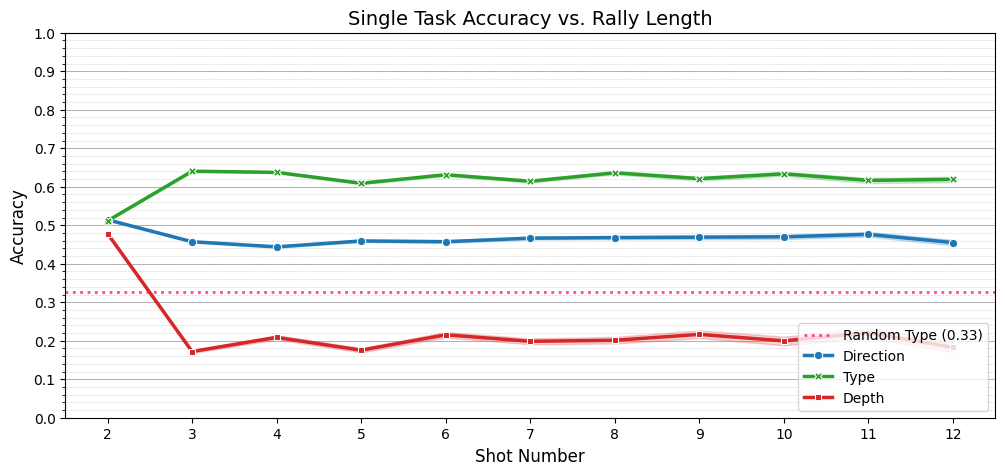

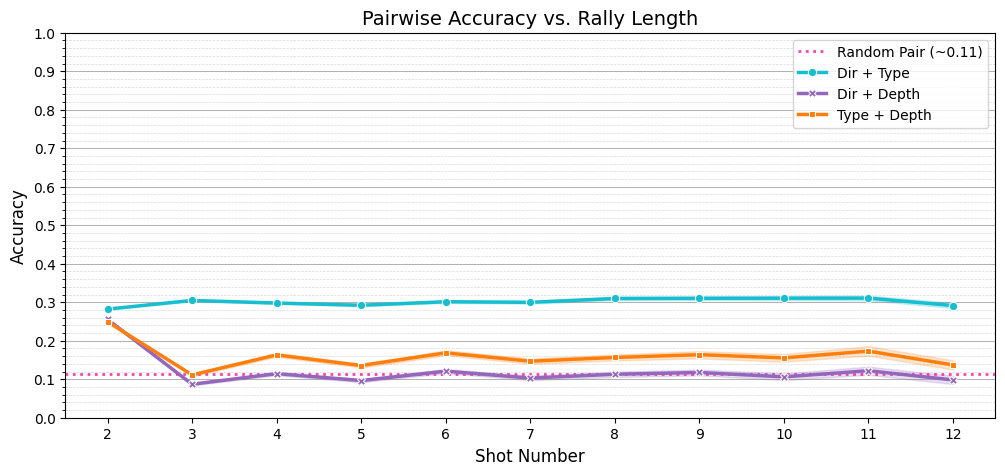

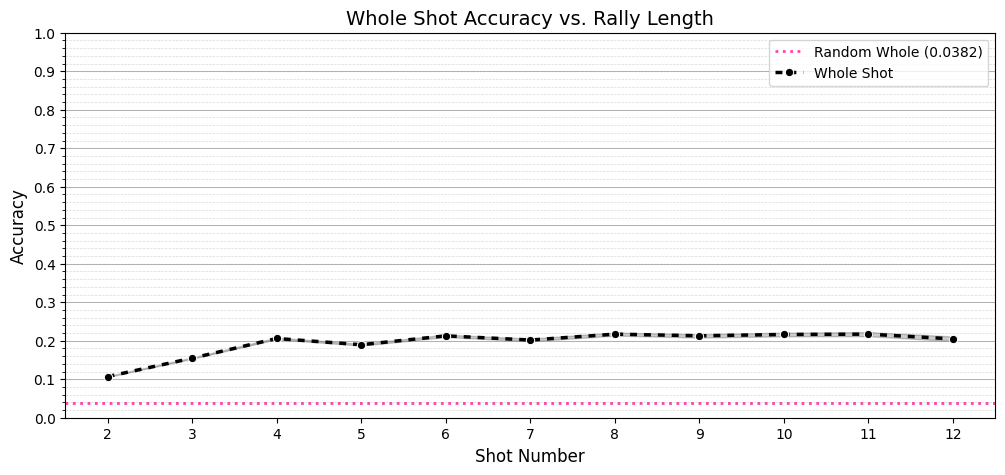


 PART 4: PLAYER FREQUENCY (2000 Matches) 


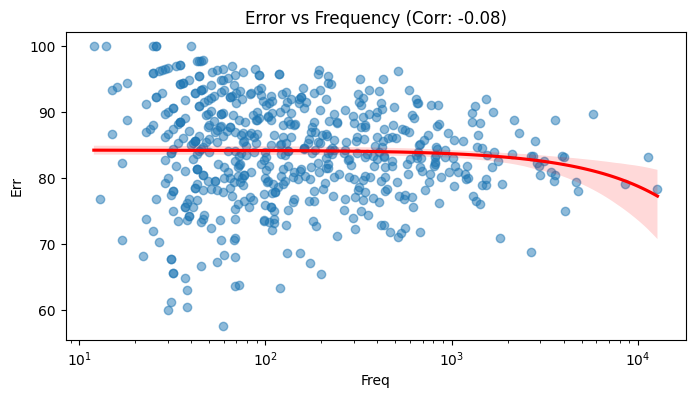


 PART 5: ERA STABILITY (50 Matches/Era) 


C:\Users\soyka\AppData\Local\Temp\ipykernel_13056\3251102738.py:432: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.DataFrame(era_res), x='Era', y='Whole Shot Acc', palette='viridis', order=['Pre-2010', '2010-2019', '2020+'])


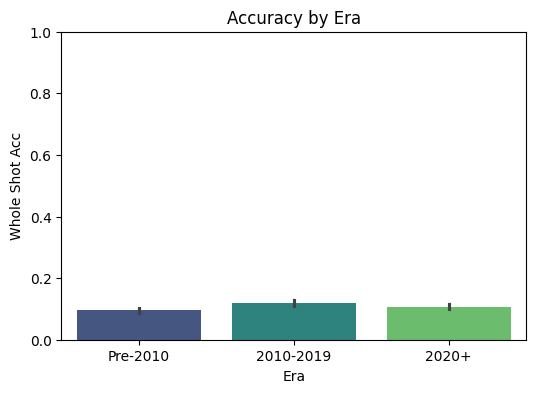


 PART 6: SURFACE DIFFICULTY (10000 samples) 
  Surface       Err  Rel_Diff
0    Clay  0.385383  0.960399
1   Grass  0.473986  1.181204
2    Hard  0.396025  0.986921


C:\Users\soyka\AppData\Local\Temp\ipykernel_13056\3251102738.py:467: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats, x='Surface', y='Rel_Diff', palette='coolwarm')


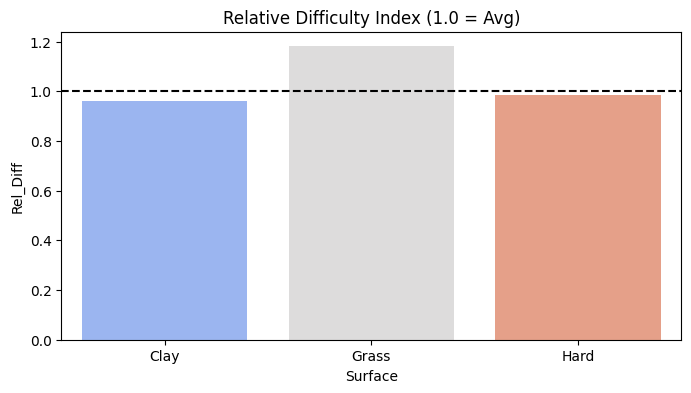

In [16]:
# [Keep imports and decoder helpers exactly as before]
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch

# --- 1. SHARED CONFIG & HELPERS ---
EVAL_SHOT_VOCAB = {'<pad>': 0, 'f': 1, 'b': 2, 'r': 3, 'v': 4, 'o': 5, 's': 6, 'u': 7, 'l': 8, 'm': 9, 'z': 10}
EVAL_DIR_VOCAB  = {'<pad>': 0, '0': 0, '1': 1, '2': 2, '3': 3}
EVAL_DEPTH_VOCAB = {'<pad>': 0, '0': 0, '7': 1, '8': 2, '9': 3}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_fast_decoder_map(dataset):
    """
    Creates a direct lookup table: Unified_ID -> (Type_ID, Dir_ID, Depth_ID)
    Robustly handles Serves, Shots, Lets, and Specials.
    """
    uni_map = {}
    serve_id = EVAL_SHOT_VOCAB.get('s', 0)
    
    for uid, key in dataset.inv_unified_vocab.items():
        # 1. Handle Padding/Unk
        if uid <= 1: 
            uni_map[uid] = (0,0,0)
            continue
            
        parts = key.split('_')
        
        # 2. Handle Serves
        if parts[0] == 'Serve':
            uni_map[uid] = (serve_id, 0, 0)
            
        # 3. Handle Specials/Lets (e.g., "LET_1", "SPECIAL_S")
        # These are not shots, so we map them to (0,0,0) or a specific ID if needed.
        # For this evaluation, we treat them as 'No Shot' (0).
        elif parts[0] in ['LET', 'SPECIAL']:
            uni_map[uid] = (0, 0, 0)
            
        # 4. Handle Standard Shots (e.g., "f_2_8_...")
        else:
            # We expect at least Type, Dir, Depth.
            # If the parser produced a weird key like "f_1" (len 2), handle gracefully.
            if len(parts) < 3:
                t = EVAL_SHOT_VOCAB.get(parts[0], 0)
                d = EVAL_DIR_VOCAB.get(parts[1], 0) if len(parts) > 1 else 0
                uni_map[uid] = (t, d, 0)
            else:
                uni_map[uid] = (
                    EVAL_SHOT_VOCAB.get(parts[0], 0), 
                    EVAL_DIR_VOCAB.get(parts[1], 0), 
                    EVAL_DEPTH_VOCAB.get(parts[2], 0)
                )
    return uni_map

def decode_unified_predictions(preds, dataset):
    # Wrapper to use the fast map for list processing
    uni_map = get_fast_decoder_map(dataset)
    types, dirs, depths = [], [], []
    for p in preds:
        t, d, dep = uni_map.get(p, (0,0,0))
        types.append(t); dirs.append(d); depths.append(dep)
    return types, dirs, depths

# --- 2. THE ADAPTED EVALUATION FUNCTION ---
def run_full_evaluation(model, dataset, loader, test_indices, 
                        live_samples=5000, 
                        length_matches=2000, 
                        freq_matches=2000, 
                        era_matches=50, 
                        speed_samples=10000):
    
    model.eval()
    print(f"Starting Full Evaluation on {len(test_indices)} test samples...")
    uni_map = get_fast_decoder_map(dataset)
    
    # Pre-calculate Match-to-Index Map
    match_map = {}
    for idx in test_indices:
        mid = dataset.sample_match_ids[idx]
        match_map.setdefault(mid, []).append(idx)
    unique_matches = list(match_map.keys())

    # ==============================================================================
    # PART 1: OVERALL TACTICAL METRICS (Updated)
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 1: OVERALL TACTICAL METRICS \n" + "="*40)
    all_preds_unified, all_targets_unified = [], []
    
    print("Running Evaluation on TEST SET (Unified Model)...")
    with torch.no_grad():
        for batch in loader:
            x_seq = batch['x_seq'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            y = batch['y_target'].to(DEVICE)
            
            # Forward pass
            logits = model(x_seq, x_c)
            
            # Mask out padding (0) for cleaner metrics
            mask = y.view(-1) != 0
            all_preds_unified.extend(logits.argmax(-1).view(-1)[mask].cpu().numpy())
            all_targets_unified.extend(y.view(-1)[mask].cpu().numpy())

    print("Decoding predictions...")
    pred_t, pred_d, pred_dp = decode_unified_predictions(all_preds_unified, dataset)
    targ_t, targ_d, targ_dp = decode_unified_predictions(all_targets_unified, dataset)

    # 1. Direction Report
    print("\n=== DIRECTION REPORT (1=Right, 2=Center, 3=Left) ===")
    # Filter out Pad and '0' (assuming 0 is undefined/unknown direction)
    d_labels = [k for k,v in EVAL_DIR_VOCAB.items() if v in np.unique(targ_d) and k not in ['<pad>', '0']]
    d_indices = [EVAL_DIR_VOCAB[k] for k in d_labels]
    print(classification_report(targ_d, pred_d, labels=d_indices, target_names=d_labels, zero_division=0))
    
    # 2. Depth Report
    print("\n=== DEPTH REPORT (7=Shallow, 8=Mid, 9=Deep) ===")
    dp_labels = [k for k,v in EVAL_DEPTH_VOCAB.items() if v in np.unique(targ_dp) and k not in ['<pad>', '0']]
    dp_indices = [EVAL_DEPTH_VOCAB[k] for k in dp_labels]
    print(classification_report(targ_dp, pred_dp, labels=dp_indices, target_names=dp_labels, zero_division=0))
    
    # 3. Shot Type Report
    print("\n=== SHOT TYPE REPORT ===")
    tp_labels = [k for k,v in EVAL_SHOT_VOCAB.items() if v in np.unique(targ_t) and k not in ['<pad>']]
    tp_indices = [EVAL_SHOT_VOCAB[k] for k in tp_labels]
    print(classification_report(targ_t, pred_t, labels=tp_indices, target_names=tp_labels, zero_division=0))

    # ==============================================================================
    # PART 2: DETAILED LIVE SAMPLES
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 2: LIVE SAMPLES (Showing {live_samples} Cases) \n" + "="*40)
    
    # Setup for pretty printing
    inv_dir = {v:k for k,v in EVAL_DIR_VOCAB.items()}
    inv_typ = {v:k for k,v in EVAL_SHOT_VOCAB.items()}
    
    selected_indices = random.sample(test_indices, min(live_samples * 2, len(test_indices))) # Sample extra to account for skips
    results_buffer = {3: [], 2:[], 1:[], 0:[]}
    
    printed_count = 0
    
    with torch.no_grad():
        for idx in selected_indices:
            if printed_count >= live_samples: break
            
            sample = dataset[idx]
            non_zeros = (sample['x_seq'] != 0).nonzero(as_tuple=True)[0]
            if len(non_zeros) < 2: continue
            
            # Predict a random point in the sequence
            valid_indices = non_zeros.tolist()
            t = random.choice(valid_indices)
            
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            
            # Forward
            logits = model(x_seq, x_c)
            
            # --- Build History String ---
            start_idx = valid_indices[0]
            history_str = ""
            for i in range(start_idx, t + 1):
                uid = sample['x_seq'][i].item()
                typ, d, dep = uni_map.get(uid, (0,0,0))
                z_in = inv_dir.get(d, '?')
                t_in = inv_typ.get(typ, '?')
                
                if i == start_idx:
                    history_str += f"[Serve {z_in}] " if t_in == 's' else f"[{t_in}{z_in}] "
                else:
                    history_str += f"-> {t_in}{z_in} "
            
            # --- Get Prediction ---
            probs = torch.softmax(logits[0, t], dim=0)
            pred_uid = probs.argmax().item()
            conf = probs.max().item() * 100
            
            pred_t, pred_d, pred_dp = uni_map.get(pred_uid, (0,0,0))
            
            true_uid = sample['y_target'][t].item()
            true_t, true_d, true_dp = uni_map.get(true_uid, (0,0,0))
            
            # Skip uninformative cases (pad vs pad)
            if true_t == 0: continue

            s_pred_d = inv_dir.get(pred_d, '?'); s_pred_t = inv_typ.get(pred_t, '?')
            s_true_d = inv_dir.get(true_d, '?'); s_true_t = inv_typ.get(true_t, '?')
            
            check_d = "✅" if pred_d == true_d else "❌"
            check_t = "✅" if pred_t == true_t else "❌"
            check_dp = "✅" if pred_dp == true_dp else "❌"
            
            def d_lbl(x):
                if x == 1: return "Short"
                if x == 2: return "Deep"
                if x == 3: return "V.Deep"
                return "N/A"
            
            score = (1 if pred_d == true_d else 0) + (1 if pred_t == true_t else 0) + (1 if pred_dp == true_dp else 0)
            
            m_id = dataset.sample_match_ids[idx]
            p1 = dataset.match_meta.get(m_id, {}).get('p1_name', 'Unknown')

            out = []
            out.append(f"\nMatch {m_id} ({p1}):")
            out.append(f"  History:    {history_str}")
            out.append(f"  Prediction: {s_pred_t} to {s_pred_d} ({d_lbl(pred_dp)}) | Conf: {conf:.0f}%")
            out.append(f"  ACTUAL:     {s_true_t} to {s_true_d} ({d_lbl(true_dp)}) | {check_t} Type {check_d} Dir {check_dp} Dep")
            
            results_buffer[score].append("\n".join(out))
            printed_count += 1

    print_flag = False
    
    for s in [3,2,1,0]:
        items = results_buffer[s]
        if items:
            print(f"\n{'='*20} {s}/3 CORRECT ({len(items)} cases) {'='*20}")
            if print_flag:
                for item in items: 
                    print(item)
                
    # ==============================================================================
    # PART 3: GRANULAR ACCURACY VS RALLY LENGTH
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 3: GRANULAR ACCURACY VS RALLY LENGTH \n" + "="*40)
    
    # 3.1 Calculate Baselines (Weighted Random Probability)
    print("Calculating dataset baselines...")
    all_d, all_dp, all_tp = [], [], []
    
    for i in test_indices:
        y_seq = dataset[i]['y_target']
        for uid in y_seq:
            if uid.item() <= 1: continue
            t, d, dep = uni_map[uid.item()]
            all_tp.append(t)
            all_d.append(d)
            if dep != 0: all_dp.append(dep)

    def calc_baseline(data_list):
        if not data_list: return 0.33
        counts = Counter(data_list)
        total = sum(counts.values())
        return sum([(c/total)**2 for c in counts.values()])

    base_d = calc_baseline(all_d)
    base_dp = calc_baseline(all_dp)
    base_tp = calc_baseline(all_tp)
    
    base_pair_avg = (base_d*base_dp + base_d*base_tp + base_tp*base_dp) / 3
    base_whole = base_d * base_dp * base_tp
    
    print(f"Baselines -> Dir: {base_d:.2f}, Depth: {base_dp:.2f}, Type: {base_tp:.2f}, Whole: {base_whole:.4f}")
    
    # 3.2 Analysis Loop
    # We sample matches to get coherent rally structures
    test_match_ids = [dataset.sample_match_ids[i] for i in test_indices]
    unique_matches_p3 = sorted(list(set(test_match_ids)))
    selected_matches_p3 = random.sample(unique_matches_p3, min(length_matches, len(unique_matches_p3)))
    selected_indices_p3 = [i for i in test_indices if dataset.sample_match_ids[i] in selected_matches_p3]
    
    print(f"Analyzing {len(selected_indices_p3)} points from {len(selected_matches_p3)} matches...")

    results_p3 = []
    with torch.no_grad():
        for idx in selected_indices_p3:
            sample = dataset[idx]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)

            logits = model(x_seq, x_c)
            preds = logits.argmax(dim=-1).squeeze(0)
            
            seq_len = x_seq.shape[1]
            for t in range(seq_len):
                if x_seq[0, t] == 0: continue
                
                # Calculate absolute shot number
                history_so_far = x_seq[0, :t+1]
                true_shot_count = (history_so_far != 0).sum().item()
                shot_num = true_shot_count + 1

                p_uid = preds[t].item(); t_uid = y[t].item()
                if t_uid <= 1: continue 
                
                p_t, p_d, p_dp = uni_map.get(p_uid, (0,0,0))
                t_t, t_d, t_dp = uni_map.get(t_uid, (0,0,0))

                # --- LOGIC SPLIT ---
                # 1. ALWAYS valid tasks
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Direction', 'Type': 'Single', 'Accuracy': 1 if p_d == t_d else 0})
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Type', 'Type': 'Single', 'Accuracy': 1 if p_t == t_t else 0})
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Dir + Type', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_t==t_t) else 0})
                
                # 2. DEPTH-DEPENDENT tasks (Only count if target depth is NOT 0)
                if t_dp != 0:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Depth', 'Type': 'Single', 'Accuracy': 1 if p_dp == t_dp else 0})
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Dir + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_dp==t_dp) else 0})
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Type + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_t==t_t and p_dp==t_dp) else 0})
                
                # 3. Whole Shot
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Whole Shot', 'Type': 'Whole', 'Accuracy': 1 if p_uid == t_uid else 0})

    if results_p3:
        df = pd.DataFrame(results_p3)
        df = df[(df['Shot_Number'] <= 12) & (df['Shot_Number'] >= 2)]
        
        # --- PLOTTING ---
        palette_single = {'Direction': '#1f77b4', 'Depth': '#d62728', 'Type': '#2ca02c'}
        palette_pair   = {'Dir + Depth': '#9467bd', 'Dir + Type': '#17becf', 'Type + Depth': '#ff7f0e'}
        palette_whole  = {'Whole Shot': '#000000'}

        def setup_plot(title, baseline, base_label):
            plt.figure(figsize=(12, 5))
            plt.title(title, fontsize=14)
            plt.ylabel('Accuracy', fontsize=12)
            plt.xlabel('Shot Number', fontsize=12)
            plt.xticks(np.arange(2, 13, 1))
            
            ax = plt.gca()
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
            plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.75, color='grey', alpha=0.6)
            plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
            plt.ylim(0.0, 1.0)
            
            if baseline:
                plt.axhline(baseline, color='#FF1493', linestyle=':', alpha=0.8, linewidth=2, label=base_label)

        # GRAPH 1: SINGLE
        setup_plot('Single Task Accuracy vs. Rally Length', base_tp, f'Random Type ({base_tp:.2f})')
        sns.lineplot(data=df[df['Type']=='Single'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_single, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='lower right'); plt.show()
        
        # GRAPH 2: PAIRWISE
        setup_plot('Pairwise Accuracy vs. Rally Length', base_pair_avg, f'Random Pair (~{base_pair_avg:.2f})')
        sns.lineplot(data=df[df['Type']=='Pair'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_pair, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

        # GRAPH 3: WHOLE SHOT
        setup_plot('Whole Shot Accuracy vs. Rally Length', base_whole, f'Random Whole ({base_whole:.4f})')
        sns.lineplot(data=df[df['Type']=='Whole'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes={'Whole Shot':(2,2)}, palette=palette_whole, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

    

    # ==============================================================================
    # PART 4: PLAYER FREQUENCY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 4: PLAYER FREQUENCY ({freq_matches} Matches) \n" + "="*40)
    chosen_matches = random.sample(unique_matches, min(freq_matches, len(unique_matches)))
    pf_indices = [idx for mid in chosen_matches for idx in match_map[mid]]
    
    p_counts = Counter()
    p_stats = {}
    
    with torch.no_grad():
        for idx in pf_indices:
            sample = dataset[idx]
            y = sample['y_target']
            # --- ADAPTATION: We still access IDs for Stats, even if model ignores them ---
            s_id, r_id = sample['x_s_id'].item(), sample['x_r_id'].item()
            
            # --- ADAPTATION: Model Prediction ---
            preds = model(sample['x_seq'].unsqueeze(0).to(DEVICE), 
                          sample['context'].unsqueeze(0).to(DEVICE)).argmax(-1).squeeze(0)
            
            for t in range(len(y)):
                if y[t] == 0: continue
                hist_len = (sample['x_seq'][:t+1] != 0).sum().item()
                actor = s_id if (hist_len + 1) % 2 != 0 else r_id
                if actor <= 1: continue
                
                p_counts[actor] += 1
                if actor not in p_stats: p_stats[actor] = {'tot': 0, 'corr': 0}
                p_stats[actor]['tot'] += 1
                if preds[t].item() == y[t].item(): p_stats[actor]['corr'] += 1

    pf_data = [{'Freq': p_counts[a], 'Err': (1 - v['corr']/v['tot'])*100} for a, v in p_stats.items() if p_counts[a] > 10]
    if pf_data:
        df_pf = pd.DataFrame(pf_data)
        plt.figure(figsize=(8, 4))
        sns.regplot(data=df_pf, x='Freq', y='Err', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.xscale('log'); plt.title(f"Error vs Frequency (Corr: {df_pf['Freq'].corr(df_pf['Err']):.2f})"); plt.show()

    # ==============================================================================
    # PART 5: ERA STABILITY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 5: ERA STABILITY ({era_matches} Matches/Era) \n" + "="*40)
    eras = {'Pre-2010': [], '2010-2019': [], '2020+': []}
    for m_id in unique_matches:
        try: y_year = int(str(m_id)[:4])
        except: continue
        if y_year < 2010: eras['Pre-2010'].append(m_id)
        elif y_year < 2020: eras['2010-2019'].append(m_id)
        else: eras['2020+'].append(m_id)

    era_indices = []
    era_labels_list = []
    for era_name, m_list in eras.items():
        if not m_list: continue
        chosen = random.sample(m_list, min(era_matches, len(m_list)))
        for m in chosen:
            era_indices.extend(match_map[m])
            era_labels_list.extend([era_name]*len(match_map[m]))
            
    era_res = []
    with torch.no_grad():
        for i, idx in enumerate(era_indices):
            sample = dataset[idx]
            y = sample['y_target'].to(DEVICE)
            # --- ADAPTATION ---
            preds = model(sample['x_seq'].unsqueeze(0).to(DEVICE), 
                          sample['context'].unsqueeze(0).to(DEVICE)).argmax(-1).squeeze(0)
            mask = y != 0
            if mask.sum() > 0:
                acc = (preds[mask] == y[mask]).float().mean().item()
                era_res.append({'Era': era_labels_list[i], 'Whole Shot Acc': acc})
    
    if era_res:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=pd.DataFrame(era_res), x='Era', y='Whole Shot Acc', palette='viridis', order=['Pre-2010', '2010-2019', '2020+'])
        plt.title('Accuracy by Era'); plt.ylim(0, 1); plt.show()

    # ==============================================================================
    # PART 6: SURFACE DIFFICULTY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 6: SURFACE DIFFICULTY ({speed_samples} samples) \n" + "="*40)
    surf_indices = random.sample(test_indices, min(len(test_indices), speed_samples))
    surf_res = []
    
    with torch.no_grad():
        for idx in surf_indices:
            mid = dataset.sample_match_ids[idx]
            s_name = dataset.match_meta.get(mid, {}).get('surface', 'Hard')
            sample = dataset[idx]
            y = sample['y_target'].to(DEVICE)
            # --- ADAPTATION ---
            preds = model(sample['x_seq'].unsqueeze(0).to(DEVICE), 
                          sample['context'].unsqueeze(0).to(DEVICE)).argmax(-1).squeeze(0)
            
            for t in range(len(y)):
                if y[t] == 0: continue
                pt = uni_map.get(preds[t].item(), (0,0,0))[0]
                tt = uni_map.get(y[t].item(), (0,0,0))[0]
                surf_res.append({'Surface': s_name, 'Err': 1.0 if pt!=tt else 0.0})

    if surf_res:
        df_s = pd.DataFrame(surf_res)
        stats = df_s.groupby('Surface')['Err'].mean().reset_index()
        freq = df_s['Surface'].value_counts(normalize=True)
        g_avg = sum(stats[stats['Surface']==k]['Err'].values[0] * v for k,v in freq.items())
        
        stats['Rel_Diff'] = stats['Err'] / g_avg
        print(stats)
        plt.figure(figsize=(8, 4))
        sns.barplot(data=stats, x='Surface', y='Rel_Diff', palette='coolwarm')
        plt.axhline(1.0, color='k', ls='--')
        plt.title('Relative Difficulty Index (1.0 = Avg)'); plt.show()


# --- 3. RUNNER SNIPPET (Add this to your notebook cell) ---
# We need to recreate the validation split indices used during training
# to ensure we don't evaluate on training data.
if 'datasetSingle' in globals() and 'baselineSingleHead' in globals():
    print("Recreating validation split for evaluation...")
    seed_everything(42) # Ensure strict reproducibility
    
    total_len = len(datasetSingle)
    train_len = int(0.8 * total_len)
    val_len = total_len - train_len
    
    # We use random_split with generator to match training
    gen = torch.Generator().manual_seed(42)
    _, val_ds = random_split(datasetSingle, [train_len, val_len], generator=gen)
    
    # Extract indices from the Subset
    test_indices = val_ds.indices
    
    # Create loader
    test_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

    # Run!
    run_full_evaluation(
        model=baselineSingleHead, 
        dataset=datasetSingle, 
        loader=test_loader, 
        test_indices=test_indices,
        live_samples=5000, 
        length_matches=2000,
        freq_matches=2000
    )
else:
    print("Error: 'datasetSingle' or 'baselineSingleHead' not found.")

## GOOD MODEL 1

In [ ]:
import torch
import torch.nn as nn

class UnifiedShotLSTM(nn.Module):
    def __init__(self, vocab_size, context_dim=10,  # match context vector size
                 embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        super().__init__()

        # Token embedding
        self.token_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Context embedding
        self.context_fc = nn.Linear(context_dim, embed_dim)

        # LSTM
        self.lstm = nn.LSTM(
            input_size=embed_dim * 2,  # token + context
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Output: Unified token prediction
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x_tokens, x_context):
        """
        x_tokens: [batch, seq_len] tensor of token IDs
        x_context: [batch, context_dim] tensor
        """
        token_emb = self.token_emb(x_tokens)  # [B, L, embed_dim]
        context_emb = self.context_fc(x_context).unsqueeze(1)  # [B, 1, embed_dim]
        context_emb = context_emb.expand(-1, token_emb.size(1), -1)  # [B, L, embed_dim]

        lstm_input = torch.cat([token_emb, context_emb], dim=-1)  # [B, L, embed*2]
        lstm_out, _ = self.lstm(lstm_input)  # [B, L, hidden_dim]

        logits = self.fc_out(lstm_out)  # [B, L, vocab_size]
        return logits


def train_unified_lstm(dataset, epochs=10, batch_size=64, lr=1e-3, device='cuda'):
    vocab_size = len(dataset.unified_vocab)
    print(f"--- STARTING UNIFIED LSTM TRAINING (Vocab Size: {vocab_size}) ---")
    
    # 1. IDENTIFY SERVE TOKENS (The Fix)
    # We find all token IDs that represent a Serve so we can ignore them during training.
    serve_token_ids = set()
    for key, idx in dataset.unified_vocab.items():
        if key.lower().startswith('serve') or key.startswith('S_'):
            serve_token_ids.add(idx)
    print(f"Training will ignore {len(serve_token_ids)} serve tokens in targets.")

    # 2. Split dataset
    train_len = int(0.8 * len(dataset))
    val_len = int(0.1 * len(dataset))
    test_len = len(dataset) - train_len - val_len
    
    # Use generator for reproducibility
    train_ds, val_ds, test_ds = random_split(
        dataset, [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = UnifiedShotLSTM(
        vocab_size=vocab_size,
        context_dim=dataset.context_tensor.size(1),
        embed_dim=128,
        hidden_dim=256,
        num_layers=2,
        dropout=0.2
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # CRITICAL: Loss must ignore index 0
    criterion = nn.CrossEntropyLoss(ignore_index=0) 
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            x_seq = batch['x_seq'].to(device)
            x_context = batch['context'].to(device)
            y = batch['y_target'].to(device)
            
            # --- THE FIX: MASK SERVES IN TARGET ---
            # We create a copy of y to modify for loss calculation
            y_masked = y.clone()
            for s_id in serve_token_ids:
                y_masked[y == s_id] = 0  # Set serve targets to 0 (ignored by loss)
            # --------------------------------------
            
            optimizer.zero_grad()
            logits = model(x_seq, x_context) 
            
            # Calculate loss against the MASKED targets
            loss = criterion(logits.view(-1, vocab_size), y_masked.view(-1))
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # --- Validation ---
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                x_seq = batch['x_seq'].to(device)
                x_context = batch['context'].to(device)
                y = batch['y_target'].to(device)
                
                # We apply the same mask in validation so Accuracy reflects "Rally Shot Accuracy"
                y_val_masked = y.clone()
                for s_id in serve_token_ids:
                    y_val_masked[y == s_id] = 0

                logits = model(x_seq, x_context)
                preds = logits.argmax(dim=-1)
                
                # Calculate accuracy only on Non-Zero (Non-Pad AND Non-Serve) tokens
                mask = (y_val_masked != 0)
                if mask.sum() > 0:
                    correct += (preds[mask] == y_val_masked[mask]).sum().item()
                    total += mask.sum().item()
        
        val_acc = (correct / total * 100) if total > 0 else 0
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val Acc (Non-Serve): {val_acc:.2f}%")
    
    save_path = "unified_lstm_model.pth"
    torch.save(model.state_dict(), save_path)
    print(f"\n✅ Model weights saved to {save_path}")
    
    return model

In [ ]:
# --- EXECUTE ---
if __name__ == "__main__":
    base_path = '../dataset/tennis_MatchChartingProject-master/'

    # List all point files to merge
    point_files = [
        base_path + 'charting-m-points-2020s.csv',
        base_path + 'charting-m-points-2010s.csv',
        base_path + 'charting-m-points-to-2009.csv'
    ]

    # New Matches File
    matches_path = base_path  + '/charting-m-matches.csv'

    atp_path = '../dataset/atp_players.csv'
    wta_path = '../dataset/wta_players.csv'
    dataset = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
    
    if 'dataset' not in globals():
        print("Please ensure 'dataset' is loaded.")
    else:
        unified_model = train_unified_lstm(dataset, epochs=10, batch_size=512, device=DEVICE)

### Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, random_split

# --- 1. SHARED CONFIG & HELPERS ---
EVAL_SHOT_VOCAB = {'<pad>': 0, 'f': 1, 'b': 2, 'r': 3, 'v': 4, 'o': 5, 's': 6, 'u': 7, 'l': 8, 'm': 9, 'z': 10}
EVAL_DIR_VOCAB  = {'<pad>': 0, '0': 0, '1': 1, '2': 2, '3': 3}
EVAL_DEPTH_VOCAB = {'<pad>': 0, '0': 0, '7': 1, '8': 2, '9': 3}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_fast_decoder_map(dataset):
    """
    Creates a direct lookup table: Unified_ID -> (Type_ID, Dir_ID, Depth_ID)
    Robustly handles Serves, Shots, Lets, and Specials (Restored from Eval 1).
    """
    uni_map = {}
    serve_id = EVAL_SHOT_VOCAB.get('s', 0)
    
    for uid, key in dataset.inv_unified_vocab.items():
        # 1. Handle Padding/Unk
        if uid <= 1: 
            uni_map[uid] = (0,0,0)
            continue
            
        parts = key.split('_')
        
        # 2. Handle Serves
        if parts[0] == 'Serve':
            uni_map[uid] = (serve_id, 0, 0)
            
        # 3. Handle Specials/Lets (Treat as No Shot for tactical eval)
        elif parts[0] in ['LET', 'SPECIAL']:
            uni_map[uid] = (0, 0, 0)
            
        # 4. Handle Standard Shots (e.g., "f_2_8_...")
        else:
            if len(parts) < 3:
                t = EVAL_SHOT_VOCAB.get(parts[0], 0)
                d = EVAL_DIR_VOCAB.get(parts[1], 0) if len(parts) > 1 else 0
                uni_map[uid] = (t, d, 0)
            else:
                uni_map[uid] = (
                    EVAL_SHOT_VOCAB.get(parts[0], 0), 
                    EVAL_DIR_VOCAB.get(parts[1], 0), 
                    EVAL_DEPTH_VOCAB.get(parts[2], 0)
                )
    return uni_map

def decode_unified_predictions(preds, dataset):
    # Wrapper to use the fast map for list processing
    uni_map = get_fast_decoder_map(dataset)
    types, dirs, depths = [], [], []
    for p in preds:
        t, d, dep = uni_map.get(p, (0,0,0))
        types.append(t); dirs.append(d); depths.append(dep)
    return types, dirs, depths

# --- 2. THE ADAPTED EVALUATION FUNCTION ---
def run_full_evaluation(model, dataset, loader, test_indices, 
                        live_samples=5000, 
                        length_matches=2000, 
                        freq_matches=2000, 
                        era_matches=50, 
                        speed_samples=10000):
    
    model.eval()
    print(f"Starting Full Evaluation on {len(test_indices)} TEST SET samples...")
    uni_map = get_fast_decoder_map(dataset)
    
    # Pre-calculate Match-to-Index Map
    match_map = {}
    for idx in test_indices:
        mid = dataset.sample_match_ids[idx]
        match_map.setdefault(mid, []).append(idx)
    unique_matches = list(match_map.keys())

    # ==============================================================================
    # PART 1: OVERALL TACTICAL METRICS
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 1: OVERALL TACTICAL METRICS \n" + "="*40)
    all_preds_unified, all_targets_unified = [], []
    
    with torch.no_grad():
        for batch in loader:
            x_seq = batch['x_seq'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            y = batch['y_target'].to(DEVICE)
            
            # Forward pass (Unified LSTM)
            logits = model(x_seq, x_c)
            
            mask = y.view(-1) != 0
            all_preds_unified.extend(logits.argmax(-1).view(-1)[mask].cpu().numpy())
            all_targets_unified.extend(y.view(-1)[mask].cpu().numpy())

    pred_t, pred_d, pred_dp = decode_unified_predictions(all_preds_unified, dataset)
    targ_t, targ_d, targ_dp = decode_unified_predictions(all_targets_unified, dataset)

    # 1. Direction Report
    print("\n=== DIRECTION REPORT (1=Right, 2=Center, 3=Left) ===")
    d_labels = [k for k,v in EVAL_DIR_VOCAB.items() if v in np.unique(targ_d) and k not in ['<pad>', '0']]
    d_indices = [EVAL_DIR_VOCAB[k] for k in d_labels]
    print(classification_report(targ_d, pred_d, labels=d_indices, target_names=d_labels, zero_division=0))
    
    # 2. Depth Report (RESTORED)
    print("\n=== DEPTH REPORT (7=Shallow, 8=Mid, 9=Deep) ===")
    dp_labels = [k for k,v in EVAL_DEPTH_VOCAB.items() if v in np.unique(targ_dp) and k not in ['<pad>', '0']]
    dp_indices = [EVAL_DEPTH_VOCAB[k] for k in dp_labels]
    print(classification_report(targ_dp, pred_dp, labels=dp_indices, target_names=dp_labels, zero_division=0))
    
    # 3. Shot Type Report
    print("\n=== SHOT TYPE REPORT ===")
    tp_labels = [k for k,v in EVAL_SHOT_VOCAB.items() if v in np.unique(targ_t) and k not in ['<pad>']]
    tp_indices = [EVAL_SHOT_VOCAB[k] for k in tp_labels]
    print(classification_report(targ_t, pred_t, labels=tp_indices, target_names=tp_labels, zero_division=0))

    # ==============================================================================
    # PART 2: DETAILED LIVE SAMPLES (Restored functionality)
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 2: LIVE SAMPLES (Showing {live_samples} Cases) \n" + "="*40)
    
    inv_dir = {v:k for k,v in EVAL_DIR_VOCAB.items()}
    inv_typ = {v:k for k,v in EVAL_SHOT_VOCAB.items()}
    
    selected_indices = random.sample(test_indices, min(live_samples * 2, len(test_indices)))
    results_buffer = {3: [], 2:[], 1:[], 0:[]}
    printed_count = 0
    
    with torch.no_grad():
        for idx in selected_indices:
            if printed_count >= live_samples: break
            
            sample = dataset[idx]
            non_zeros = (sample['x_seq'] != 0).nonzero(as_tuple=True)[0]
            if len(non_zeros) < 2: continue
            
            # Predict a random point in the sequence
            valid_indices = non_zeros.tolist()
            t = random.choice(valid_indices)
            
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            
            logits = model(x_seq, x_c)
            
            # --- Build History String ---
            start_idx = valid_indices[0]
            history_str = ""
            for i in range(start_idx, t + 1):
                uid = sample['x_seq'][i].item()
                typ, d, dep = uni_map.get(uid, (0,0,0))
                z_in = inv_dir.get(d, '?')
                t_in = inv_typ.get(typ, '?')
                
                if i == start_idx:
                    history_str += f"[Serve {z_in}] " if t_in == 's' else f"[{t_in}{z_in}] "
                else:
                    history_str += f"-> {t_in}{z_in} "
            
            # --- Get Prediction ---
            probs = torch.softmax(logits[0, t], dim=0)
            pred_uid = probs.argmax().item()
            conf = probs.max().item() * 100
            
            pred_t, pred_d, pred_dp = uni_map.get(pred_uid, (0,0,0))
            true_uid = sample['y_target'][t].item()
            true_t, true_d, true_dp = uni_map.get(true_uid, (0,0,0))
            
            if true_t == 0: continue

            s_pred_d = inv_dir.get(pred_d, '?'); s_pred_t = inv_typ.get(pred_t, '?')
            s_true_d = inv_dir.get(true_d, '?'); s_true_t = inv_typ.get(true_t, '?')
            
            check_d = "✅" if pred_d == true_d else "❌"
            check_t = "✅" if pred_t == true_t else "❌"
            check_dp = "✅" if pred_dp == true_dp else "❌"
            
            def d_lbl(x):
                if x == 1: return "Short"
                if x == 2: return "Deep"
                if x == 3: return "V.Deep"
                return "N/A"
            
            score = (1 if pred_d == true_d else 0) + (1 if pred_t == true_t else 0) + (1 if pred_dp == true_dp else 0)
            m_id = dataset.sample_match_ids[idx]

            out = []
            out.append(f"\nMatch {m_id}:")
            out.append(f"  History:    {history_str}")
            out.append(f"  Prediction: {s_pred_t} to {s_pred_d} ({d_lbl(pred_dp)}) | Conf: {conf:.0f}%")
            out.append(f"  ACTUAL:     {s_true_t} to {s_true_d} ({d_lbl(true_dp)}) | {check_t} Type {check_d} Dir {check_dp} Dep")
            
            results_buffer[score].append("\n".join(out))
            printed_count += 1

    print_flag = False
    
    for s in [3,2,1,0]:
        items = results_buffer[s]
        if items:
            print(f"\n{'='*20} {s}/3 CORRECT ({len(items)} cases) {'='*20}")
            if print_flag:    
                for item in items: 
                    print(item)

    # ==============================================================================
    # PART 3: GRANULAR ACCURACY VS RALLY LENGTH (Restored functionality)
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 3: GRANULAR ACCURACY VS RALLY LENGTH \n" + "="*40)
    
    # 3.1 Calculate Baselines
    print("Calculating dataset baselines...")
    all_d, all_dp, all_tp = [], [], []
    for i in test_indices:
        y_seq = dataset[i]['y_target']
        for uid in y_seq:
            if uid.item() <= 1: continue
            t, d, dep = uni_map[uid.item()]
            all_tp.append(t); all_d.append(d)
            if dep != 0: all_dp.append(dep)

    def calc_baseline(data_list):
        if not data_list: return 0.33
        counts = Counter(data_list)
        total = sum(counts.values())
        return sum([(c/total)**2 for c in counts.values()])

    base_d = calc_baseline(all_d)
    base_dp = calc_baseline(all_dp)
    base_tp = calc_baseline(all_tp)
    base_pair_avg = (base_d*base_dp + base_d*base_tp + base_tp*base_dp) / 3
    base_whole = base_d * base_dp * base_tp
    print(f"Baselines -> Dir: {base_d:.2f}, Depth: {base_dp:.2f}, Type: {base_tp:.2f}, Whole: {base_whole:.4f}")
    
    # 3.2 Analysis Loop
    test_match_ids = [dataset.sample_match_ids[i] for i in test_indices]
    unique_matches_p3 = sorted(list(set(test_match_ids)))
    selected_matches_p3 = random.sample(unique_matches_p3, min(length_matches, len(unique_matches_p3)))
    selected_indices_p3 = [i for i in test_indices if dataset.sample_match_ids[i] in selected_matches_p3]
    
    print(f"Analyzing {len(selected_indices_p3)} points from {len(selected_matches_p3)} matches...")

    results_p3 = []
    with torch.no_grad():
        for idx in selected_indices_p3:
            sample = dataset[idx]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)

            logits = model(x_seq, x_c)
            preds = logits.argmax(dim=-1).squeeze(0)
            
            seq_len = x_seq.shape[1]
            for t in range(seq_len):
                if x_seq[0, t] == 0: continue
                
                # Calculate absolute shot number
                history_so_far = x_seq[0, :t+1]
                true_shot_count = (history_so_far != 0).sum().item()
                shot_num = true_shot_count + 1

                p_uid = preds[t].item(); t_uid = y[t].item()
                if t_uid <= 1: continue 
                
                p_t, p_d, p_dp = uni_map.get(p_uid, (0,0,0))
                t_t, t_d, t_dp = uni_map.get(t_uid, (0,0,0))

                # Logic Split: Single, Pair, Whole
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Direction', 'Type': 'Single', 'Accuracy': 1 if p_d == t_d else 0})
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Type', 'Type': 'Single', 'Accuracy': 1 if p_t == t_t else 0})
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Dir + Type', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_t==t_t) else 0})
                
                if t_dp != 0:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Depth', 'Type': 'Single', 'Accuracy': 1 if p_dp == t_dp else 0})
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Dir + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_dp==t_dp) else 0})
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Type + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_t==t_t and p_dp==t_dp) else 0})
                
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Whole Shot', 'Type': 'Whole', 'Accuracy': 1 if p_uid == t_uid else 0})

    if results_p3:
        df = pd.DataFrame(results_p3)
        df = df[(df['Shot_Number'] <= 12) & (df['Shot_Number'] >= 2)]
        
        # --- PLOTTING (Restored 3 graphs) ---
        palette_single = {'Direction': '#1f77b4', 'Depth': '#d62728', 'Type': '#2ca02c'}
        palette_pair   = {'Dir + Depth': '#9467bd', 'Dir + Type': '#17becf', 'Type + Depth': '#ff7f0e'}
        palette_whole  = {'Whole Shot': '#000000'}

        def setup_plot(title, baseline, base_label):
            plt.figure(figsize=(12, 5))
            plt.title(title, fontsize=14)
            plt.ylabel('Accuracy', fontsize=12)
            plt.xlabel('Shot Number', fontsize=12)
            plt.xticks(np.arange(2, 13, 1))
            
            ax = plt.gca()
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
            plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.75, color='grey', alpha=0.6)
            plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
            plt.ylim(0.0, 1.0)
            
            if baseline:
                plt.axhline(baseline, color='#FF1493', linestyle=':', alpha=0.8, linewidth=2, label=base_label)

        # Graph 1: Single
        setup_plot('Single Task Accuracy vs. Rally Length', base_tp, f'Random Type ({base_tp:.2f})')
        sns.lineplot(data=df[df['Type']=='Single'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_single, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='lower right'); plt.show()
        
        # Graph 2: Pairwise
        setup_plot('Pairwise Accuracy vs. Rally Length', base_pair_avg, f'Random Pair (~{base_pair_avg:.2f})')
        sns.lineplot(data=df[df['Type']=='Pair'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_pair, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

        # Graph 3: Whole Shot
        setup_plot('Whole Shot Accuracy vs. Rally Length', base_whole, f'Random Whole ({base_whole:.4f})')
        sns.lineplot(data=df[df['Type']=='Whole'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes={'Whole Shot':(2,2)}, palette=palette_whole, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

    # ==============================================================================
    # PART 4: PLAYER FREQUENCY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 4: PLAYER FREQUENCY ({freq_matches} Matches) \n" + "="*40)
    chosen_matches = random.sample(unique_matches, min(freq_matches, len(unique_matches)))
    pf_indices = [idx for mid in chosen_matches for idx in match_map[mid]]
    
    p_counts = Counter()
    p_stats = {}
    
    with torch.no_grad():
        for idx in pf_indices:
            sample = dataset[idx]
            y = sample['y_target']
            s_id, r_id = sample['x_s_id'].item(), sample['x_r_id'].item()
            
            # Model Prediction
            preds = model(sample['x_seq'].unsqueeze(0).to(DEVICE), 
                          sample['context'].unsqueeze(0).to(DEVICE)).argmax(-1).squeeze(0)
            
            for t in range(len(y)):
                if y[t] == 0: continue
                hist_len = (sample['x_seq'][:t+1] != 0).sum().item()
                actor = s_id if (hist_len + 1) % 2 != 0 else r_id
                if actor <= 1: continue
                
                p_counts[actor] += 1
                if actor not in p_stats: p_stats[actor] = {'tot': 0, 'corr': 0}
                p_stats[actor]['tot'] += 1
                if preds[t].item() == y[t].item(): p_stats[actor]['corr'] += 1

    pf_data = [{'Freq': p_counts[a], 'Err': (1 - v['corr']/v['tot'])*100} for a, v in p_stats.items() if p_counts[a] > 10]
    if pf_data:
        df_pf = pd.DataFrame(pf_data)
        plt.figure(figsize=(8, 4))
        sns.regplot(data=df_pf, x='Freq', y='Err', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.xscale('log'); plt.title(f"Error vs Frequency (Corr: {df_pf['Freq'].corr(df_pf['Err']):.2f})"); plt.show()

    # ==============================================================================
    # PART 5: ERA STABILITY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 5: ERA STABILITY ({era_matches} Matches/Era) \n" + "="*40)
    eras = {'Pre-2010': [], '2010-2019': [], '2020+': []}
    for m_id in unique_matches:
        try: y_year = int(str(m_id)[:4])
        except: continue
        if y_year < 2010: eras['Pre-2010'].append(m_id)
        elif y_year < 2020: eras['2010-2019'].append(m_id)
        else: eras['2020+'].append(m_id)

    era_indices = []
    era_labels_list = []
    for era_name, m_list in eras.items():
        if not m_list: continue
        chosen = random.sample(m_list, min(era_matches, len(m_list)))
        for m in chosen:
            era_indices.extend(match_map[m])
            era_labels_list.extend([era_name]*len(match_map[m]))
            
    era_res = []
    with torch.no_grad():
        for i, idx in enumerate(era_indices):
            sample = dataset[idx]
            y = sample['y_target'].to(DEVICE)
            preds = model(sample['x_seq'].unsqueeze(0).to(DEVICE), 
                          sample['context'].unsqueeze(0).to(DEVICE)).argmax(-1).squeeze(0)
            mask = y != 0
            if mask.sum() > 0:
                acc = (preds[mask] == y[mask]).float().mean().item()
                era_res.append({'Era': era_labels_list[i], 'Whole Shot Acc': acc})
    
    if era_res:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=pd.DataFrame(era_res), x='Era', y='Whole Shot Acc', palette='viridis', order=['Pre-2010', '2010-2019', '2020+'])
        plt.title('Accuracy by Era'); plt.ylim(0, 1); plt.show()

    # ==============================================================================
    # PART 6: SURFACE DIFFICULTY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 6: SURFACE DIFFICULTY ({speed_samples} samples) \n" + "="*40)
    surf_indices = random.sample(test_indices, min(len(test_indices), speed_samples))
    surf_res = []
    
    with torch.no_grad():
        for idx in surf_indices:
            mid = dataset.sample_match_ids[idx]
            s_name = dataset.match_meta.get(mid, {}).get('surface', 'Hard')
            sample = dataset[idx]
            y = sample['y_target'].to(DEVICE)
            preds = model(sample['x_seq'].unsqueeze(0).to(DEVICE), 
                          sample['context'].unsqueeze(0).to(DEVICE)).argmax(-1).squeeze(0)
            
            for t in range(len(y)):
                if y[t] == 0: continue
                pt = uni_map.get(preds[t].item(), (0,0,0))[0]
                tt = uni_map.get(y[t].item(), (0,0,0))[0]
                surf_res.append({'Surface': s_name, 'Err': 1.0 if pt!=tt else 0.0})

    if surf_res:
        df_s = pd.DataFrame(surf_res)
        stats = df_s.groupby('Surface')['Err'].mean().reset_index()
        freq = df_s['Surface'].value_counts(normalize=True)
        g_avg = sum(stats[stats['Surface']==k]['Err'].values[0] * v for k,v in freq.items())
        
        stats['Rel_Diff'] = stats['Err'] / g_avg
        print(stats)
        plt.figure(figsize=(8, 4))
        sns.barplot(data=stats, x='Surface', y='Rel_Diff', palette='coolwarm')
        plt.axhline(1.0, color='k', ls='--')
        plt.title('Relative Difficulty Index (1.0 = Avg)'); plt.show()

# --- 3. RUNNER SNIPPET ---
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

if 'dataset' in globals() and 'unified_model' in globals():
    print("Recreating TEST split for evaluation...")
    seed_everything(42) 
    
    total_len = len(dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    
    gen = torch.Generator().manual_seed(42)
    _, _, test_ds = random_split(dataset, [train_len, val_len, test_len], generator=gen)
    
    test_indices = test_ds.indices
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    run_full_evaluation(
        model=unified_model, 
        dataset=dataset, 
        loader=test_loader, 
        test_indices=test_indices,
        live_samples=5000, 
        length_matches=2000,
        freq_matches=2000
    )
else:
    print("Error: 'dataset' or 'unified_model' not found. Run training cell first.")

## GOOD MODEL 2

In [ ]:
class EnhancedTennisDataset(MCPTennisDataset):
    """
    Extends your original dataset to provide decomposed inputs (Type, Dir, Depth)
    and Player IDs for richer model embeddings.
    """
    def __init__(self, *args, **kwargs):
        # Define basic vocabularies for decomposing inputs
        self.type_vocab = {k: v for v, k in enumerate(['<pad>', '<unk>', 'serve', 'f', 'b', 'r', 's', 'v', 'z', 'o', 'p', 'u', 'y', 'l', 'm', 'h', 'i', 'j', 'k', 't', 'q', 'special', 'let'])}
        self.dir_vocab  = {k: v for v, k in enumerate(['<pad>', '0', '1', '2', '3'])}
        self.depth_vocab= {k: v for v, k in enumerate(['<pad>', '0', '7', '8', '9'])}
        
        # Initialize parent
        super().__init__(*args, **kwargs)
        
        # We need to rebuild the data containers to include decomposed features
        self.data_x_type = []
        self.data_x_dir = []
        self.data_x_depth = []
        
        # Re-process to extract features (this runs after parent init)
        self._decompose_inputs()

    def _decompose_inputs(self):
        print("Decomposing inputs for Rich Embeddings...")
        
        # FIX: Access .tolist() from the tensor because the list was deleted by parent
        source_sequences = self.x_seq_tensor.tolist()

        for seq_unified in source_sequences:
            seq_t, seq_d, seq_dp = [], [], []
            
            for token_id in seq_unified:
                if token_id == 0: # PAD
                    seq_t.append(0); seq_d.append(0); seq_dp.append(0)
                    continue
                
                # Get string key (e.g. "f_1_8" or "Serve_4")
                key = self.inv_unified_vocab.get(token_id, '<unk>')
                
                # Parse key back into components
                if key.startswith('Serve'):
                    t, d, dp = 'serve', '0', '0' 
                elif '_' in key:
                    parts = key.split('_')
                    t = parts[0]
                    d = parts[1] if len(parts) > 1 else '0'
                    dp = parts[2] if len(parts) > 2 else '0'
                else:
                    t, d, dp = key, '0', '0'

                seq_t.append(self.type_vocab.get(t, 1))
                seq_d.append(self.dir_vocab.get(d, 1))
                seq_dp.append(self.depth_vocab.get(dp, 1))
            
            self.data_x_type.append(seq_t)
            self.data_x_dir.append(seq_d)
            self.data_x_depth.append(seq_dp)
            
        # Convert to tensors
        self.x_type_tensor = torch.tensor(self.data_x_type, dtype=torch.long)
        self.x_dir_tensor = torch.tensor(self.data_x_dir, dtype=torch.long)
        self.x_depth_tensor = torch.tensor(self.data_x_depth, dtype=torch.long)

    def __getitem__(self, idx):
        # Get parent item
        item = super().__getitem__(idx)
        # Add new rich features
        item['x_type'] = self.x_type_tensor[idx]
        item['x_dir']  = self.x_dir_tensor[idx]
        item['x_depth']= self.x_depth_tensor[idx]
        return item

In [ ]:
import torch
import torch.nn as nn

class RichInputLSTM(nn.Module):
    def __init__(self, 
                 unified_vocab_size, # Output size
                 num_players,        # For Player Embeddings
                 type_vocab_size,    # Input sizes...
                 dir_vocab_size,
                 depth_vocab_size,
                 context_dim=10, 
                 hidden_dim=256, 
                 num_layers=2, 
                 dropout=0.2):
        super().__init__()

        # --- 1. Decomposed Input Embeddings ---
        # Instead of one big embedding, we learn smaller, specific ones
        self.emb_type = nn.Embedding(type_vocab_size, 64, padding_idx=0)
        self.emb_dir  = nn.Embedding(dir_vocab_size, 16, padding_idx=0)
        self.emb_depth= nn.Embedding(depth_vocab_size, 16, padding_idx=0)
        
        # --- 2. Player Style Embeddings ---
        # Learn a vector for every player (Nadal, Federer, etc.)
        self.emb_player = nn.Embedding(num_players, 32, padding_idx=0)
        
        # --- 3. Context Projection ---
        self.context_fc = nn.Linear(context_dim, 32)

        # Calculate total input dimension for LSTM
        # Type(64) + Dir(16) + Depth(16) + P1(32) + P2(32) + Context(32)
        lstm_input_dim = 64 + 16 + 16 + 32 + 32 + 32

        # --- 4. LSTM Backbone ---
        self.lstm = nn.LSTM(
            input_size=lstm_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # --- 5. Output Head (Still Unified for now) ---
        self.fc_out = nn.Linear(hidden_dim, unified_vocab_size)

    def forward(self, x_type, x_dir, x_depth, x_s_id, x_r_id, x_context):
        # 1. Embed Sequences [Batch, Seq_Len, Emb_Dim]
        e_t = self.emb_type(x_type)
        e_d = self.emb_dir(x_dir)
        e_p = self.emb_depth(x_depth)
        
        # 2. Embed Players [Batch, Emb_Dim] -> Expand to [Batch, Seq_Len, Emb_Dim]
        # Server ID
        e_s = self.emb_player(x_s_id).unsqueeze(1).expand(-1, e_t.size(1), -1)
        # Returner ID
        e_r = self.emb_player(x_r_id).unsqueeze(1).expand(-1, e_t.size(1), -1)
        
        # 3. Embed Context [Batch, Emb_Dim] -> Expand
        e_ctx = self.context_fc(x_context).unsqueeze(1).expand(-1, e_t.size(1), -1)
        
        # 4. Concatenate everything
        # This gives the LSTM a massive amount of specific detail for every timestep
        full_input = torch.cat([e_t, e_d, e_p, e_s, e_r, e_ctx], dim=-1)
        
        # 5. Pass through LSTM
        lstm_out, _ = self.lstm(full_input)
        
        # 6. Predict next Unified Token
        logits = self.fc_out(lstm_out)
        return logits

import torch.optim as optim
from torch.utils.data import DataLoader, random_split

def train_rich_model(dataset, epochs=10, batch_size=64, lr=1e-3, device='cuda'):
    print("--- STARTING RICH INPUT LSTM TRAINING ---")

    serve_token_ids = set()
    for key, idx in dataset.unified_vocab.items():
        if key.lower().startswith('serve') or key.startswith('S_'):
            serve_token_ids.add(idx)
    print(f"Training will ignore {len(serve_token_ids)} serve tokens in targets.")
    
    total_len = len(dataset)
    train_len = int(0.80 * total_len)
    val_len   = int(0.10 * total_len)
    test_len  = total_len - train_len - val_len

    print(f"Total Samples: {total_len}")
    print(f"Splits -> Train: {train_len}, Val: {val_len}, Test: {test_len}")

    train_ds, val_ds, test_ds = random_split(
        dataset, 
        [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(42) # Seed for reproducibility
    )

    #  Create DataLoaders
    # num_workers=0 is safer for Windows/Debugging. Increase for speed on Linux.
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # 2. Initialize Model
    model = RichInputLSTM(
        unified_vocab_size=len(dataset.unified_vocab),
        num_players=len(dataset.player_vocab),
        type_vocab_size=len(dataset.type_vocab),
        dir_vocab_size=len(dataset.dir_vocab),
        depth_vocab_size=len(dataset.depth_vocab),
        context_dim=10
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            x_t  = batch['x_type'].to(device)
            x_d  = batch['x_dir'].to(device)
            x_dp = batch['x_depth'].to(device)
            s_id = batch['x_s_id'].to(device)
            r_id = batch['x_r_id'].to(device)
            ctx  = batch['context'].to(device)
            y    = batch['y_target'].to(device)
            
            # --- FIX: MASK TARGETS ---
            y_masked = y.clone()
            for s_token in serve_token_ids:
                y_masked[y == s_token] = 0
            # -------------------------
            
            optimizer.zero_grad()
            
            logits = model(x_t, x_d, x_dp, s_id, r_id, ctx)
            
            # Calculate loss against masked targets
            loss = criterion(logits.view(-1, len(dataset.unified_vocab)), y_masked.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                x_t  = batch['x_type'].to(device)
                x_d  = batch['x_dir'].to(device)
                x_dp = batch['x_depth'].to(device)
                s_id = batch['x_s_id'].to(device)
                r_id = batch['x_r_id'].to(device)
                ctx  = batch['context'].to(device)
                y    = batch['y_target'].to(device)
                
                # Mask validation targets too for fair accuracy
                y_val_masked = y.clone()
                for s_token in serve_token_ids:
                    y_val_masked[y == s_token] = 0
                
                logits = model(x_t, x_d, x_dp, s_id, r_id, ctx)
                preds = logits.argmax(dim=-1)
                
                mask = (y_val_masked != 0)
                if mask.sum() > 0:
                    correct += (preds[mask] == y_val_masked[mask]).sum().item()
                    total += mask.sum().item()
        
        acc = (correct / total * 100) if total > 0 else 0
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Val Acc (Non-Serve): {acc:.2f}%")

    return model

In [ ]:
base_path = '../dataset/tennis_MatchChartingProject-master/'

# List all point files to merge
point_files = [
    base_path + 'charting-m-points-2020s.csv',
    base_path + 'charting-m-points-2010s.csv',
    base_path + 'charting-m-points-to-2009.csv'
]

# New Matches File
matches_path = base_path  + '/charting-m-matches.csv'

atp_path = '../dataset/atp_players.csv'
wta_path = '../dataset/wta_players.csv'

datasetEnhanced = EnhancedTennisDataset(
        points_paths_list=point_files,
        matches_path=matches_path,
        atp_path=atp_path,
        wta_path=wta_path,
        max_seq_len=SEQ_LEN  # Length of rally history to look at
    )

if 'datasetEnhanced' not in globals():
    print("Please ensure 'dataset' is loaded.")
else:
    richLSTM = train_rich_model(datasetEnhanced, epochs=15, batch_size=512, device=DEVICE)

### Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, random_split

# --- 1. SHARED CONFIG & HELPERS ---
EVAL_SHOT_VOCAB = {'<pad>': 0, 'f': 1, 'b': 2, 'r': 3, 'v': 4, 'o': 5, 's': 6, 'u': 7, 'l': 8, 'm': 9, 'z': 10}
EVAL_DIR_VOCAB  = {'<pad>': 0, '0': 0, '1': 1, '2': 2, '3': 3}
EVAL_DEPTH_VOCAB = {'<pad>': 0, '0': 0, '7': 1, '8': 2, '9': 3}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_fast_decoder_map(dataset):
    """ Safe decoder that handles variable key lengths to prevent IndexErrors. """
    uni_map = {}
    serve_id = EVAL_SHOT_VOCAB.get('s', 0)
    
    for uid, key in dataset.inv_unified_vocab.items():
        if uid <= 1: 
            uni_map[uid] = (0,0,0)
            continue
            
        parts = key.split('_')
        
        # 1. Handle Serves (Force Direction/Depth to 0)
        if parts[0] == 'Serve':
            uni_map[uid] = (serve_id, 0, 0)
        
        # 2. Handle Specials/Lets
        elif parts[0] in ['LET', 'SPECIAL']:
            uni_map[uid] = (0, 0, 0)
            
        # 3. Handle Standard Shots (Safe Access)
        else:
            t = EVAL_SHOT_VOCAB.get(parts[0], 0)
            d = EVAL_DIR_VOCAB.get(parts[1], 0) if len(parts) > 1 else 0
            dep = EVAL_DEPTH_VOCAB.get(parts[2], 0) if len(parts) > 2 else 0
            uni_map[uid] = (t, d, dep)
            
    return uni_map

def decode_unified_predictions(preds, dataset):
    uni_map = get_fast_decoder_map(dataset)
    types, dirs, depths = [], [], []
    for p in preds:
        t, d, dep = uni_map.get(p, (0,0,0))
        types.append(t); dirs.append(d); depths.append(dep)
    return types, dirs, depths

# --- 2. THE RICH-INPUT EVALUATION FUNCTION ---
def run_full_evaluation(model, dataset, loader, test_indices, 
                        live_samples=5000, 
                        length_matches=2000, 
                        freq_matches=2000, 
                        era_matches=50, 
                        speed_samples=10000):
    
    model.eval()
    print(f"Starting Full Evaluation on {len(test_indices)} test samples...")
    uni_map = get_fast_decoder_map(dataset)
    
    # Pre-calculate Match-to-Index Map
    match_map = {}
    for idx in test_indices:
        mid = dataset.sample_match_ids[idx]
        match_map.setdefault(mid, []).append(idx)
    unique_matches = list(match_map.keys())

    # ==============================================================================
    # PART 1: OVERALL TACTICAL METRICS
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 1: OVERALL TACTICAL METRICS \n" + "="*40)
    all_preds_unified, all_targets_unified = [], []
    
    with torch.no_grad():
        for batch in loader:
            # Unpack rich inputs
            x_t  = batch['x_type'].to(DEVICE)
            x_d  = batch['x_dir'].to(DEVICE)
            x_dp = batch['x_depth'].to(DEVICE)
            s_id = batch['x_s_id'].to(DEVICE)
            r_id = batch['x_r_id'].to(DEVICE)
            ctx  = batch['context'].to(DEVICE)
            y    = batch['y_target'].to(DEVICE)
            
            logits = model(x_t, x_d, x_dp, s_id, r_id, ctx)
            
            mask = y.view(-1) != 0
            all_preds_unified.extend(logits.argmax(-1).view(-1)[mask].cpu().numpy())
            all_targets_unified.extend(y.view(-1)[mask].cpu().numpy())

    pred_t, pred_d, pred_dp = decode_unified_predictions(all_preds_unified, dataset)
    targ_t, targ_d, targ_dp = decode_unified_predictions(all_targets_unified, dataset)

    # 1. Direction Report
    print("\n=== DIRECTION REPORT (1=Cross, 2=Center, 3=Line) ===")
    d_labels = [k for k,v in EVAL_DIR_VOCAB.items() if v in np.unique(targ_d) and k not in ['<pad>', '0']]
    d_indices = [EVAL_DIR_VOCAB[k] for k in d_labels]
    if d_indices:
        print(classification_report(targ_d, pred_d, labels=d_indices, target_names=d_labels, zero_division=0))
    else:
        print("No valid directions found in targets.")

    # 2. Depth Report (RESTORED)
    print("\n=== DEPTH REPORT (7=Shallow, 8=Mid, 9=Deep) ===")
    dp_labels = [k for k,v in EVAL_DEPTH_VOCAB.items() if v in np.unique(targ_dp) and k not in ['<pad>', '0']]
    dp_indices = [EVAL_DEPTH_VOCAB[k] for k in dp_labels]
    print(classification_report(targ_dp, pred_dp, labels=dp_indices, target_names=dp_labels, zero_division=0))

    # 3. Shot Type Report
    print("\n=== SHOT TYPE REPORT ===")
    tp_labels = [k for k,v in EVAL_SHOT_VOCAB.items() if v in np.unique(targ_t) and k not in ['<pad>']]
    tp_indices = [EVAL_SHOT_VOCAB[k] for k in tp_labels]
    print(classification_report(targ_t, pred_t, labels=tp_indices, target_names=tp_labels, zero_division=0))

    # ==============================================================================
    # PART 2: LIVE TEST CASES (Detailed History & Confidence)
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 2: LIVE SAMPLES (Subset of {live_samples}) \n" + "="*40)
    
    inv_dir = {v:k for k,v in EVAL_DIR_VOCAB.items()}
    inv_typ = {v:k for k,v in EVAL_SHOT_VOCAB.items()}
    
    selected_indices = random.sample(test_indices, min(live_samples * 2, len(test_indices)))
    results_buffer = {3: [], 2:[], 1:[], 0:[]}
    printed_count = 0
    
    with torch.no_grad():
        for idx in selected_indices:
            if printed_count >= live_samples: break
            
            sample = dataset[idx]
            non_zeros = (sample['x_seq'] != 0).nonzero(as_tuple=True)[0]
            if len(non_zeros) < 2: continue
            
            # Predict random point
            valid_indices = non_zeros.tolist()
            t = random.choice(valid_indices)
            
            # Unpack & Unsqueeze for single sample
            x_t  = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_d  = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_dp = sample['x_depth'].unsqueeze(0).to(DEVICE)
            s_id = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            r_id = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            ctx  = sample['context'].unsqueeze(0).to(DEVICE)

            logits = model(x_t, x_d, x_dp, s_id, r_id, ctx)
            
            # --- Build History String ---
            start_idx = valid_indices[0]
            history_str = ""
            for i in range(start_idx, t + 1):
                uid = sample['x_seq'][i].item() # Use x_seq for history logic
                typ, d, dep = uni_map.get(uid, (0,0,0))
                z_in = inv_dir.get(d, '?')
                t_in = inv_typ.get(typ, '?')
                if i == start_idx:
                    history_str += f"[Serve {z_in}] " if t_in == 's' else f"[{t_in}{z_in}] "
                else:
                    history_str += f"-> {t_in}{z_in} "

            probs = torch.softmax(logits[0, t], dim=0)
            pred_uid = probs.argmax().item()
            conf = probs.max().item() * 100
            
            pred_t, pred_d, pred_dp = uni_map.get(pred_uid, (0,0,0))
            true_uid = sample['y_target'][t].item()
            true_t, true_d, true_dp = uni_map.get(true_uid, (0,0,0))
            
            if true_t == 0: continue

            s_pred_d = inv_dir.get(pred_d, '?'); s_pred_t = inv_typ.get(pred_t, '?')
            s_true_d = inv_dir.get(true_d, '?'); s_true_t = inv_typ.get(true_t, '?')
            
            check_d = "✅" if pred_d == true_d else "❌"
            check_t = "✅" if pred_t == true_t else "❌"
            check_dp = "✅" if pred_dp == true_dp else "❌"
            
            def d_lbl(x):
                if x == 1: return "Short"
                if x == 2: return "Deep"
                if x == 3: return "V.Deep"
                return "N/A"
            
            score = (1 if pred_d == true_d else 0) + (1 if pred_t == true_t else 0) + (1 if pred_dp == true_dp else 0)
            m_id = dataset.sample_match_ids[idx]

            out = []
            out.append(f"\nMatch {m_id}:")
            out.append(f"  History:    {history_str}")
            out.append(f"  Prediction: {s_pred_t} to {s_pred_d} ({d_lbl(pred_dp)}) | Conf: {conf:.0f}%")
            out.append(f"  ACTUAL:     {s_true_t} to {s_true_d} ({d_lbl(true_dp)}) | {check_t} Type {check_d} Dir {check_dp} Dep")
            
            results_buffer[score].append("\n".join(out))
            printed_count += 1
            
    print_flag = False
    for s in [3, 2, 1, 0]:
        items = results_buffer[s]
        if items:
            print(f"\n{'='*20} {s}/3 CORRECT ({len(items)} cases) {'='*20}")
            if print_flag:    
                for item in items:
                    print(item)

    # ==============================================================================
    # PART 3: GRANULAR ACCURACY VS RALLY LENGTH (3 Graphs)
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 3: RALLY LENGTH vs ACCURACY ({length_matches} Matches) \n" + "="*40)
    
    # 3.1 Calculate Baselines
    print("Calculating dataset baselines...")
    all_d, all_dp, all_tp = [], [], []
    for i in test_indices:
        y_seq = dataset[i]['y_target']
        for uid in y_seq:
            if uid.item() <= 1: continue
            t, d, dep = uni_map[uid.item()]
            all_tp.append(t); all_d.append(d)
            if dep != 0: all_dp.append(dep)

    def calc_baseline(data_list):
        if not data_list: return 0.33
        counts = Counter(data_list)
        total = sum(counts.values())
        return sum([(c/total)**2 for c in counts.values()])

    base_d = calc_baseline(all_d)
    base_dp = calc_baseline(all_dp)
    base_tp = calc_baseline(all_tp)
    base_pair_avg = (base_d*base_dp + base_d*base_tp + base_tp*base_dp) / 3
    base_whole = base_d * base_dp * base_tp
    print(f"Baselines -> Dir: {base_d:.2f}, Depth: {base_dp:.2f}, Type: {base_tp:.2f}, Whole: {base_whole:.4f}")

    # 3.2 Analysis Loop
    chosen_matches = random.sample(unique_matches, min(length_matches, len(unique_matches)))
    rl_indices = [idx for mid in chosen_matches for idx in match_map[mid]]
    
    rl_results = []
    with torch.no_grad():
        for idx in rl_indices:
            sample = dataset[idx]
            x_t  = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_d  = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_dp = sample['x_depth'].unsqueeze(0).to(DEVICE)
            s_id = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            r_id = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            ctx  = sample['context'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)
            
            preds = model(x_t, x_d, x_dp, s_id, r_id, ctx).argmax(-1).squeeze(0)
            
            x_seq_cpu = sample['x_seq']
            
            for t in range(x_seq_cpu.shape[0]):
                if x_seq_cpu[t] == 0 or y[t] <= 1: continue
                
                # Shot count logic
                shot_num = (x_seq_cpu[:t+1] != 0).sum().item() + 1
                
                p_uid = preds[t].item(); t_uid = y[t].item()
                pt, p_d, pdp = uni_map.get(p_uid, (0,0,0))
                tt, td, tdp = uni_map.get(t_uid, (0,0,0))
                
                # Logic Split
                rl_results.append({'Shot_Number': shot_num, 'Task': 'Direction', 'Type': 'Single', 'Acc': 1 if p_d == td else 0})
                rl_results.append({'Shot_Number': shot_num, 'Task': 'Type', 'Type': 'Single', 'Acc': 1 if pt == tt else 0})
                rl_results.append({'Shot_Number': shot_num, 'Task': 'Dir + Type', 'Type': 'Pair', 'Acc': 1 if (pd==td and pt==tt) else 0})
                
                if tdp != 0:
                     rl_results.append({'Shot_Number': shot_num, 'Task': 'Depth', 'Type': 'Single', 'Acc': 1 if pdp == tdp else 0})
                     rl_results.append({'Shot_Number': shot_num, 'Task': 'Dir + Depth', 'Type': 'Pair', 'Acc': 1 if (p_d==td and pdp==tdp) else 0})
                     rl_results.append({'Shot_Number': shot_num, 'Task': 'Type + Depth', 'Type': 'Pair', 'Acc': 1 if (pt==tt and pdp==tdp) else 0})

                rl_results.append({'Shot_Number': shot_num, 'Task': 'Whole Shot', 'Type': 'Whole', 'Acc': 1 if p_uid == t_uid else 0})

    if rl_results:
        df = pd.DataFrame(rl_results)
        df = df[(df['Shot_Number'] >= 2) & (df['Shot_Number'] <= 12)]
        
        palette_single = {'Direction': '#1f77b4', 'Depth': '#d62728', 'Type': '#2ca02c'}
        palette_pair   = {'Dir + Depth': '#9467bd', 'Dir + Type': '#17becf', 'Type + Depth': '#ff7f0e'}
        palette_whole  = {'Whole Shot': '#000000'}

        def setup_plot(title, baseline, base_label):
            plt.figure(figsize=(12, 5))
            plt.title(title, fontsize=14)
            plt.ylabel('Accuracy', fontsize=12)
            plt.xlabel('Shot Number', fontsize=12)
            plt.xticks(np.arange(2, 13, 1))
            
            ax = plt.gca()
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
            plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.75, color='grey', alpha=0.6)
            plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
            plt.ylim(0.0, 1.0)
            
            if baseline:
                plt.axhline(baseline, color='#FF1493', linestyle=':', alpha=0.8, linewidth=2, label=base_label)

        # Graph 1: Single
        setup_plot('Single Task Accuracy vs. Rally Length', base_tp, f'Random Type ({base_tp:.2f})')
        sns.lineplot(data=df[df['Type']=='Single'], x='Shot_Number', y='Acc', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_single, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='lower right'); plt.show()
        
        # Graph 2: Pairwise
        setup_plot('Pairwise Accuracy vs. Rally Length', base_pair_avg, f'Random Pair (~{base_pair_avg:.2f})')
        sns.lineplot(data=df[df['Type']=='Pair'], x='Shot_Number', y='Acc', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_pair, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

        # Graph 3: Whole Shot
        setup_plot('Whole Shot Accuracy vs. Rally Length', base_whole, f'Random Whole ({base_whole:.4f})')
        sns.lineplot(data=df[df['Type']=='Whole'], x='Shot_Number', y='Acc', hue='Task', style='Task', 
                     markers=True, dashes={'Whole Shot':(2,2)}, palette=palette_whole, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

    # ==============================================================================
    # PART 4: PLAYER FREQUENCY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 4: PLAYER FREQUENCY ({freq_matches} Matches) \n" + "="*40)
    chosen_matches = random.sample(unique_matches, min(freq_matches, len(unique_matches)))
    pf_indices = [idx for mid in chosen_matches for idx in match_map[mid]]
    
    p_counts = Counter()
    p_stats = {}
    
    with torch.no_grad():
        for idx in pf_indices:
            sample = dataset[idx]
            x_t  = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_d  = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_dp = sample['x_depth'].unsqueeze(0).to(DEVICE)
            s_id = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            r_id = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            ctx  = sample['context'].unsqueeze(0).to(DEVICE)
            y = sample['y_target']
            
            preds = model(x_t, x_d, x_dp, s_id, r_id, ctx).argmax(-1).squeeze(0)
            
            s_val, r_val = sample['x_s_id'].item(), sample['x_r_id'].item()
            x_seq_cpu = sample['x_seq']
            
            for t in range(len(y)):
                if y[t] == 0: continue
                hist_len = (x_seq_cpu[:t+1] != 0).sum().item()
                actor = s_val if (hist_len + 1) % 2 != 0 else r_val
                if actor <= 1: continue
                
                p_counts[actor] += 1
                if actor not in p_stats: p_stats[actor] = {'tot': 0, 'corr': 0}
                p_stats[actor]['tot'] += 1
                if preds[t].item() == y[t].item(): p_stats[actor]['corr'] += 1

    pf_data = [{'Freq': p_counts[a], 'Err': (1 - v['corr']/v['tot'])*100} for a, v in p_stats.items() if p_counts[a] > 10]
    if pf_data:
        df_pf = pd.DataFrame(pf_data)
        plt.figure(figsize=(8, 4))
        sns.regplot(data=df_pf, x='Freq', y='Err', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.xscale('log'); plt.title(f"Error vs Frequency (Corr: {df_pf['Freq'].corr(df_pf['Err']):.2f})"); plt.show()

    # ==============================================================================
    # PART 5: ERA STABILITY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 5: ERA STABILITY ({era_matches} Matches/Era) \n" + "="*40)
    eras = {'Pre-2010': [], '2010-2019': [], '2020+': []}
    for m_id in unique_matches:
        try: y_year = int(str(m_id)[:4])
        except: continue
        if y_year < 2010: eras['Pre-2010'].append(m_id)
        elif y_year < 2020: eras['2010-2019'].append(m_id)
        else: eras['2020+'].append(m_id)

    era_indices = []
    era_labels_list = []
    for era_name, m_list in eras.items():
        if not m_list: continue
        chosen = random.sample(m_list, min(era_matches, len(m_list)))
        for m in chosen:
            era_indices.extend(match_map[m])
            era_labels_list.extend([era_name]*len(match_map[m]))
            
    era_res = []
    with torch.no_grad():
        for i, idx in enumerate(era_indices):
            sample = dataset[idx]
            x_t  = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_d  = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_dp = sample['x_depth'].unsqueeze(0).to(DEVICE)
            s_id = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            r_id = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            ctx  = sample['context'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)

            preds = model(x_t, x_d, x_dp, s_id, r_id, ctx).argmax(-1).squeeze(0)
            mask = y != 0
            if mask.sum() > 0:
                acc = (preds[mask] == y[mask]).float().mean().item()
                era_res.append({'Era': era_labels_list[i], 'Whole Shot Acc': acc})
    
    if era_res:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=pd.DataFrame(era_res), x='Era', y='Whole Shot Acc', palette='viridis', order=['Pre-2010', '2010-2019', '2020+'])
        plt.title('Accuracy by Era'); plt.ylim(0, 1); plt.show()

    # ==============================================================================
    # PART 6: SURFACE DIFFICULTY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 6: SURFACE DIFFICULTY ({speed_samples} samples) \n" + "="*40)
    surf_indices = random.sample(test_indices, min(len(test_indices), speed_samples))
    surf_res = []
    
    with torch.no_grad():
        for idx in surf_indices:
            mid = dataset.sample_match_ids[idx]
            s_name = dataset.match_meta.get(mid, {}).get('surface', 'Hard')
            sample = dataset[idx]
            
            x_t  = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_d  = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_dp = sample['x_depth'].unsqueeze(0).to(DEVICE)
            s_id = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            r_id = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            ctx  = sample['context'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)

            preds = model(x_t, x_d, x_dp, s_id, r_id, ctx).argmax(-1).squeeze(0)
            
            for t in range(len(y)):
                if y[t] == 0: continue
                pt = uni_map.get(preds[t].item(), (0,0,0))[0]
                tt = uni_map.get(y[t].item(), (0,0,0))[0]
                surf_res.append({'Surface': s_name, 'Err': 1.0 if pt!=tt else 0.0})

    if surf_res:
        df_s = pd.DataFrame(surf_res)
        stats = df_s.groupby('Surface')['Err'].mean().reset_index()
        freq = df_s['Surface'].value_counts(normalize=True)
        g_avg = sum(stats[stats['Surface']==k]['Err'].values[0] * v for k,v in freq.items())
        
        stats['Rel_Diff'] = stats['Err'] / g_avg
        print(stats)
        plt.figure(figsize=(8, 4))
        sns.barplot(data=stats, x='Surface', y='Rel_Diff', palette='coolwarm')
        plt.axhline(1.0, color='k', ls='--')
        plt.title('Relative Difficulty Index (1.0 = Avg)'); plt.show()


# --- 3. RUNNER SNIPPET ---
if 'datasetEnhanced' in globals() and 'richLSTM' in globals():
    print("Recreating validation/test split for evaluation...")
    seed_everything(42) 
    
    total_len = len(datasetEnhanced)
    train_len = int(0.80 * total_len)
    val_len   = int(0.10 * total_len)
    test_len  = total_len - train_len - val_len
    
    gen = torch.Generator().manual_seed(42)
    _, _, test_ds = random_split(datasetEnhanced, [train_len, val_len, test_len], generator=gen)
    
    test_indices = test_ds.indices
    test_loader_eval = DataLoader(test_ds, batch_size=64, shuffle=False)

    run_full_evaluation(
        model=richLSTM, 
        dataset=datasetEnhanced, 
        loader=test_loader_eval, 
        test_indices=test_indices,
        live_samples=5000, 
        length_matches=2000,
        freq_matches=2000
    )
else:
    print("Error: 'datasetEnhanced' or 'richLSTM' not found. Run training first.")

## BEST MODEL EVER CRISTIAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import re
import os
import random

# --- CONFIGURAZIONE GLOBALE ---
SEQ_LEN = 30       # Fixed sequence length
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the path
save_path = 'tennis_shot_forecasting.pth'

# Seed everything to avoid randomness
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to {seed}")

# Call it immediately
seed_everything(42)

# --- 1. DATASET (Restored & Fixed) ---
import torch
import pandas as pd
import numpy as np
import re
import os
from torch.utils.data import Dataset

class MCPTennisDataset(Dataset):
    def __init__(self, points_paths_list, matches_path, atp_path, wta_path, max_seq_len=30):
        self.max_seq_len = max_seq_len
        print("Initializing Dataset with CORRECTED Parsing Logic...")
        
        # 1. Load Player Data (Height & Hand)
        self.player_vocab = {'<pad>': 0, '<unk>': 1}
        self.player_stats = {} # {name: {'hand': 'R', 'height': 185}}
        self._build_player_stats(atp_path, wta_path)
        
        # 2. Load Matches
        try:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', quoting=3)
        self.match_meta = self._process_match_metadata(self.matches_df)
        
        # 3. Load Points
        dfs = []
        for p_path in points_paths_list:
            if not os.path.exists(p_path): continue
            try:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
                dfs.append(d)
            except:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', quoting=3)
                dfs.append(d)
        
        if dfs:
            self.df = pd.concat(dfs, ignore_index=True)
            # Sort by Match and Point to track flow
            self.df['Pt'] = pd.to_numeric(self.df['Pt'], errors='coerce').fillna(0)
            self.df = self.df.sort_values(by=['match_id', 'Pt'])
        else:
            self.df = pd.DataFrame()

        # 4. Vocabularies based on Documentation
        self.surface_vocab = {'<pad>': 0, 'Hard': 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4}
        self.hand_vocab = {'<pad>': 0, 'R': 1, 'L': 2}
        
        # The Unified Token Vocabulary
        # We will build this dynamically as we parse to ensure we capture all valid combinations
        # e.g. "Serve_6", "f_1_7", "b_2"
        self.unified_vocab = {'<pad>': 0, '<unk>': 1}
        self.inv_unified_vocab = {0: '<pad>', 1: '<unk>'}
        
        # Data Containers
        self.data_x_seq = []   # Sequence of Unified Token IDs
        self.data_context = [] # Fixed context (Players, Surface, Score)
        self.data_x_s_id = []  # Server ID
        self.data_x_r_id = []  # Receiver ID
        self.data_y_type = [] # Target List
        self.sample_match_ids = []
        
        self.process_data()

    def _build_player_stats(self, atp_path, wta_path):
        for path in [atp_path, wta_path]:
            if not os.path.exists(path): continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                df['full_name'] = df['name_first'].str.strip() + " " + df['name_last'].str.strip()
                
                for _, row in df.iterrows():
                    name = row['full_name']
                    if name not in self.player_vocab:
                        self.player_vocab[name] = len(self.player_vocab)
                    
                    h = row.get('height')
                    hand = row.get('hand', 'R')
                    
                    height_val = 185 # Default
                    if pd.notna(h) and str(h).isdigit():
                        height_val = float(h)
                        
                    self.player_stats[name] = {'hand': hand, 'height': height_val}
            except: pass

    def _process_match_metadata(self, df):
        meta = {}
        for _, row in df.iterrows():
            m_id = row['match_id']
            # Surface
            raw_surf = str(row.get('Surface', 'Hard'))
            if 'Hard' in raw_surf: surf = 'Hard'
            elif 'Clay' in raw_surf: surf = 'Clay'
            elif 'Grass' in raw_surf: surf = 'Grass'
            else: surf = 'Hard'
            
            p1 = str(row.get('Player 1', ''))
            p2 = str(row.get('Player 2', ''))
            
            # Lookup Hand/Height from our loaded stats
            stats1 = self.player_stats.get(p1, {'hand': 'R', 'height': 185})
            stats2 = self.player_stats.get(p2, {'hand': 'R', 'height': 185})
            
            meta[m_id] = {
                'surface': surf, 
                'p1_name': p1, 'p2_name': p2, 
                'p1_hand': stats1['hand'], 'p2_hand': stats2['hand'],
                'p1_h': stats1['height'], 'p2_h': stats2['height']
            }
        return meta

    def get_pressure_score(self, pts, gm1, gm2):
        # 0=Normal, 1=Tiebreak, 2=BreakPoint
        if not isinstance(pts, str) or '-' not in pts: return 0
        try:
            s_pts, r_pts = pts.split('-')
            # Check Break Point (Receiver has 40 or AD)
            if (r_pts == '40' and s_pts != '40' and s_pts != 'AD') or (r_pts == 'AD'):
                return 2
            # Check Tiebreak
            if int(gm1) == 6 and int(gm2) == 6:
                return 1
        except: pass
        return 0

    def process_data(self):
        print("Parsing Rallies into Unified Tokens...")
        
        # Regex to split shots:
        # 1. Serves: Start with 4, 5, or 6. Can have modifiers (+, -, =).
        # 2. Shots: Start with char (f, b, s, r, v, ...).
        # We split the string by looking for these boundaries.
        
        # Pattern explanation:
        # ([456][0-9+=-]*)  -> Capture Serve (starts with 4,5,6, followed by optional chars)
        # |                 -> OR
        # ([fbsrvolmzup][0-9+=-]*) -> Capture Shot (starts with type char, followed by optional chars)
        split_pattern = re.compile(r'([456][0-9+=-]*|[fbsrvolmzup][0-9+=-]*)')
        
        # Helper to extract digits from a shot string
        # e.g. "s17" -> ['1', '7']
        digit_pattern = re.compile(r'\d')
        
        prev_point_state = (0, 0) # (WinnerWasServer, RallyLen)
        last_match_id = None
        
        for _, row in self.df.iterrows():
            match_id = row['match_id']
            if match_id != last_match_id:
                prev_point_state = (0, 0)
                last_match_id = match_id
            
            rally_str = str(row['2nd']) if pd.notna(row['2nd']) else str(row['1st'])
            if pd.isna(rally_str) or rally_str == 'nan': continue

            # --- CONTEXT ---
            m_meta = self.match_meta.get(match_id, {'surface': 'Hard', 'p1_name':'?', 'p2_name':'?'})
            
            svr = row['Svr'] if 'Svr' in row else 1
            if svr == 2:
                s_name, r_name = m_meta['p2_name'], m_meta['p1_name']
                s_h, r_h = m_meta['p2_h'], m_meta['p1_h']
                s_hand, r_hand = m_meta['p2_hand'], m_meta['p1_hand']
            else:
                s_name, r_name = m_meta['p1_name'], m_meta['p2_name']
                s_h, r_h = m_meta['p1_h'], m_meta['p2_h']
                s_hand, r_hand = m_meta['p1_hand'], m_meta['p2_hand']

            s_id = self.player_vocab.get(s_name, 1)
            r_id = self.player_vocab.get(r_name, 1)
            
            # Context Features
            surf_idx = self.surface_vocab.get(m_meta['surface'], 1)
            sh_idx = self.hand_vocab.get(s_hand, 1)
            rh_idx = self.hand_vocab.get(r_hand, 1)
            sh_norm = (s_h - 180) / 10.0
            rh_norm = (r_h - 180) / 10.0
            pressure = self.get_pressure_score(str(row.get('Pts','')), row.get('Gm1',0), row.get('Gm2',0))
            prev_win, prev_len = prev_point_state
            is_2nd = 1 if pd.notna(row['2nd']) else 0
            
            context_vec = [surf_idx, sh_idx, rh_idx, sh_norm, rh_norm, pressure, prev_win, prev_len, is_2nd, 0]

            # --- RALLY PARSING ---
            r_clean = re.sub(r'[@#n*!+;]', '', rally_str).lstrip('c')
            if not r_clean: continue
            
            # Find all shots
            raw_shots = split_pattern.findall(r_clean)
            if not raw_shots: continue
            
            unified_tokens = []
            
            for i, shot_str in enumerate(raw_shots):
                # 1. PARSE SERVE (First shot, starts with digit)
                if shot_str[0].isdigit():
                    # Format: "6", "5", "4+"
                    direction = shot_str[0] # 4, 5, or 6
                    token = f"Serve_{direction}"
                else:
                    # 2. PARSE SHOT (Starts with char)
                    # Format: "f1", "s17", "b2"
                    typ = shot_str[0] # f, b, s, ...
                    
                    # Extract digits
                    digits = digit_pattern.findall(shot_str)
                    
                    direction = digits[0] if len(digits) > 0 else '0' # 1, 2, 3
                    depth = digits[1] if len(digits) > 1 else '0'     # 7, 8, 9
                    
                    token = f"{typ}_{direction}_{depth}"
                
                # Add to vocab if new
                if token not in self.unified_vocab:
                    self.unified_vocab[token] = len(self.unified_vocab)
                    self.inv_unified_vocab[self.unified_vocab[token]] = token
                
                unified_tokens.append(self.unified_vocab[token])
            
            # Create Sequence
            if len(unified_tokens) >= 2:
                # Update Flow State
                curr_winner = row.get('PtWinner', 0)
                try: curr_winner = int(curr_winner)
                except: curr_winner = 0
                prev_point_state = (1 if curr_winner == svr else 0, len(unified_tokens))
                
                # Input: [Serve, Shot1, Shot2...]
                # Target: [Shot1, Shot2, Shot3...]
                
                seq_x = unified_tokens[:-1]
                seq_y = unified_tokens[1:]
                
                L = min(len(seq_x), self.max_seq_len)
                pad = [0] * (self.max_seq_len - L)
                
                self.data_x_seq.append(pad + seq_x[:L])
                self.data_context.append(context_vec)
                self.data_x_s_id.append(s_id)
                self.data_x_r_id.append(r_id)
                
                # Target is just the Unified ID
                self.data_y_type.append(pad + seq_y[:L]) # Reusing this list name for Y
                self.sample_match_ids.append(match_id)

        print(f"Dataset Built. Unique Unified Shots Found: {len(self.unified_vocab)}")
        
        self.x_seq_tensor = torch.tensor(self.data_x_seq, dtype=torch.long)
        self.context_tensor = torch.tensor(self.data_context, dtype=torch.float32)
        self.x_s_id_tensor = torch.tensor(self.data_x_s_id, dtype=torch.long)
        self.x_r_id_tensor = torch.tensor(self.data_x_r_id, dtype=torch.long)
        self.y_target_tensor = torch.tensor(self.data_y_type, dtype=torch.long)
        
        del self.data_x_seq, self.data_y_type

    def __len__(self): return len(self.sample_match_ids)
    def __getitem__(self, idx):
        return {
            'x_seq': self.x_seq_tensor[idx],
            'context': self.context_tensor[idx],
            'x_s_id': self.x_s_id_tensor[idx],
            'x_r_id': self.x_r_id_tensor[idx],
            'y_target': self.y_target_tensor[idx]
        }

In [ ]:
class UnifiedCristianGPT(nn.Module):
    def __init__(self, unified_vocab_size, num_players, context_dim=10, 
                 embed_dim=128, n_head=4, n_cycles=3, seq_len=30):        
        super().__init__()
        
        # 1. Embeddings
        # We embed the Unified Token directly
        self.token_emb = nn.Embedding(unified_vocab_size, embed_dim)
        
        # Player Embeddings (Static Style)
        self.player_emb = nn.Embedding(num_players, 64)
        
        # Context Fusion
        self.context_fusion = nn.Sequential(
            nn.Linear(context_dim + (64 * 2), embed_dim), 
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Input = Token_Emb + Context_Emb
        self.input_dim = embed_dim # We sum them or concat? Let's Add.
        
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, embed_dim))
        
        # Transformer
        self.blocks = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_head, dim_feedforward=embed_dim*4,
            batch_first=True, norm_first=True, dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(self.blocks, num_layers=n_cycles)
        self.norm_f = nn.LayerNorm(embed_dim)
        
        # Single Output Head
        self.head = nn.Linear(embed_dim, unified_vocab_size)

    def generate_causal_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1).to(DEVICE)
    
    def forward(self, x_seq, x_c, x_s, x_r):
        # x_seq: [Batch, Seq] -> [Batch, Seq, Dim]
        tok = self.token_emb(x_seq)
        
        # Players
        s = self.player_emb(x_s)
        r = self.player_emb(x_r)
        
        # Context: [Batch, CtxDim] -> [Batch, Dim]
        c_vec = torch.cat([x_c, s, r], dim=1)
        c_emb = self.context_fusion(c_vec)
        
        # Expand Context to Sequence Length
        # [Batch, 1, Dim] -> [Batch, Seq, Dim]
        c_emb = c_emb.unsqueeze(1).expand(-1, tok.size(1), -1)
        
        # Combine: Token + Context + Position
        # We ADD context to the token embedding (ResNet style) rather than concat
        x = tok + c_emb + self.pos_emb[:, :tok.size(1), :]
        
        # Causal Mask
        mask = torch.triu(torch.full((x.size(1), x.size(1)), float('-inf')), diagonal=1).to(x.device)
        
        # Transformer
        x = self.transformer(x, mask=mask)
        x = self.norm_f(x)
        
        return self.head(x)

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

base_path = '../dataset/tennis_MatchChartingProject-master/'

# List all point files to merge
point_files = [
    base_path + 'charting-m-points-2020s.csv',
    base_path + 'charting-m-points-2010s.csv',
    base_path + 'charting-m-points-to-2009.csv'
]

# New Matches File
matches_path = base_path  + '/charting-m-matches.csv'

atp_path = '../dataset/atp_players.csv'
wta_path = '../dataset/wta_players.csv'

# Standard Focal Loss (Reused for all heads)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', ignore_index=0)
        pt = torch.exp(-ce_loss) 
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            at = self.alpha.gather(0, targets.view(-1))
            focal_loss = focal_loss * at
            
        if self.reduction == 'mean':
            mask = targets != 0
            if mask.sum() > 0:
                return focal_loss[mask].mean()
            else:
                return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        else:
            return focal_loss

# Helper function to calculate weights for a specific target list
def get_balanced_weights(target_tensor, num_classes, power=0.3):
    # 1. Flatten the big tensor directly (Very fast)
    flat = target_tensor.view(-1).numpy()
    
    # 2. Filter padding (0)
    valid = flat[flat != 0]
    
    # 3. Compute Weights
    unique = np.unique(valid)
    raw_weights = compute_class_weight(class_weight='balanced', classes=unique, y=valid)
    smoothed_weights = raw_weights ** power
    
    weights_list = [0.0] # Index 0 is padding
    for i in range(1, num_classes + 1):
        if i in unique:
            idx = np.where(unique == i)[0][0]
            weights_list.append(float(smoothed_weights[idx]))
        else:
            weights_list.append(1.0)
            
    # Cap weights
    MAX_WEIGHT = 15.0
    weights_list = [min(w, MAX_WEIGHT) for w in weights_list]
    return torch.tensor(weights_list, dtype=torch.float32).to(DEVICE)

# Check if files exist
if os.path.exists(matches_path):
    # 1. Initialize Unified Dataset
    # Make sure you have updated the MCPTennisDataset class definition 
    # to the "Corrected" version I gave you previously!
    dataset = MCPTennisDataset(
        points_paths_list=point_files, 
        matches_path=matches_path, 
        atp_path=atp_path, 
        wta_path=wta_path, 
        max_seq_len=SEQ_LEN
    )
    
    # --- 1. CALCULATE WEIGHTS FOR THE UNIFIED TOKENS ---
    print("\nCalculating Balanced Weights for Unified Vocab...")
    
    # We now have just ONE target tensor: y_target_tensor
    # It contains IDs like 42 (which represents "Forehand_CrossCourt_Deep")
    w_unified = get_balanced_weights(dataset.y_target_tensor, len(dataset.unified_vocab))
    print(f"Unified Weights Shape: {w_unified.shape}")
        
    # --- SPLIT BY MATCH ---
    print("\nSplitting Data (80/15/5)...")
    all_matches = sorted(list(set(dataset.sample_match_ids)))
    
    train_matches, temp_matches = train_test_split(all_matches, test_size=0.20, random_state=42)
    val_matches, test_matches = train_test_split(temp_matches, test_size=0.25, random_state=42)
    
    train_set = set(train_matches)
    val_set = set(val_matches)
    test_set = set(test_matches)
    
    train_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in train_set]
    val_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in val_set]
    test_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in test_set]
    
    print(f"Train: {len(train_indices)} | Val: {len(val_indices)} | Test: {len(test_indices)}")

    # Workers
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(Subset(dataset, train_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, generator=g)
    val_loader = DataLoader(Subset(dataset, val_indices), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, generator=g)
    test_loader = DataLoader(Subset(dataset, test_indices), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, generator=g)

    seed_everything(42)
    
    # 5. Initialize UNIFIED Model
    model = UnifiedCristianGPT(
        unified_vocab_size=len(dataset.unified_vocab),
        num_players=len(dataset.player_vocab),
        context_dim=10, # Remember we added Height/Pressure features
        seq_len=SEQ_LEN,
        embed_dim=128
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    
    # Use aggressive learning rate as discussed
    scheduler = OneCycleLR(optimizer, max_lr=4e-4, steps_per_epoch=len(train_loader), 
                           epochs=EPOCHS, pct_start=0.3, div_factor=25, final_div_factor=1000)

    # 6. Initialize SINGLE Loss Function
    # We only predict one thing now: The Unified Token ID
    criterion = FocalLoss(alpha=w_unified, gamma=2.0)

    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0
        
    # 7. Training Loop (Unified)
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            # Inputs (Updated for Unified Model signature)
            x_seq = batch['x_seq'].to(DEVICE) # The sequence of unified tokens
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            
            # Single Target
            y = batch['y_target'].to(DEVICE)
            
            optimizer.zero_grad()
            
            # Forward
            logits = model(x_seq, x_c, x_s, x_r)
            
            # Calculate Loss (Flatten batch and sequence)
            # View(-1, vocab_size) vs View(-1)
            loss = criterion(logits.view(-1, len(dataset.unified_vocab)), y.view(-1))
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                x_seq = batch['x_seq'].to(DEVICE)
                x_c = batch['context'].to(DEVICE)
                x_s = batch['x_s_id'].to(DEVICE)
                x_r = batch['x_r_id'].to(DEVICE)
                y = batch['y_target'].to(DEVICE)
                
                logits = model(x_seq, x_c, x_s, x_r)
                
                # Val Loss
                l = criterion(logits.view(-1, len(dataset.unified_vocab)), y.view(-1))
                val_loss += l.item()
                
                # Accuracy (Unified)
                # We check if the predicted ID exactly matches the target ID
                mask = y != 0
                preds = logits.argmax(dim=-1)
                correct += (preds[mask] == y[mask]).sum().item()
                total += mask.sum().item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        acc = (correct / total * 100) if total > 0 else 0
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Unified Acc: {acc:.2f}%")
        
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            trigger_times = 0
            torch.save(model.state_dict(), save_path)
            print(f"   --> New Best Model Saved! (Loss: {best_val_loss:.4f})")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("   --> Early Stopping.")
                break
else:
    print("Dataset paths not found.")

torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

### Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch
import os

# --- 1. DEFINE STANDARD VOCABS (Quick Fix for Decoding) ---
EVAL_SHOT_VOCAB = {'<pad>': 0, 'f': 1, 'b': 2, 'r': 3, 'v': 4, 'o': 5, 's': 6, 'u': 7, 'l': 8, 'm': 9, 'z': 10}
EVAL_DIR_VOCAB  = {'<pad>': 0, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
EVAL_DEPTH_VOCAB = {'<pad>': 0, '0': 0, '7': 1, '8': 2, '9': 3}

# --- 2. DECODER HELPER ---
def decode_unified_predictions(preds, dataset):
    """ Converts list of Unified IDs -> (Type, Dir, Depth) """
    types, dirs, depths = [], [], []
    id_map = {}
    serve_type_id = EVAL_SHOT_VOCAB.get('s', 0)
    
    for uid, key in dataset.inv_unified_vocab.items():
        if uid <= 1: 
            id_map[uid] = (0, 0, 0)
            continue
        parts = key.split('_')
        if parts[0] == 'Serve':
            t = serve_type_id
            d = EVAL_DIR_VOCAB.get(parts[1], 0)
            dep = 0
        else:
            t = EVAL_SHOT_VOCAB.get(parts[0], 0)
            d = EVAL_DIR_VOCAB.get(parts[1], 0)
            dep = EVAL_DEPTH_VOCAB.get(parts[2], 0)
        id_map[uid] = (t, d, dep)
        
    for p in preds:
        t, d, dep = id_map.get(p, (0,0,0))
        types.append(t)
        dirs.append(d)
        depths.append(dep)
    return types, dirs, depths

def get_fast_decoder_map(dataset):
    """ Returns a dict mapping UnifiedID -> (Type, Dir, Depth) for fast loops """
    uni_map = {}
    serve_id = EVAL_SHOT_VOCAB.get('s', 0)
    for uid, key in dataset.inv_unified_vocab.items():
        if uid <= 1: 
            uni_map[uid] = (0,0,0)
            continue
        parts = key.split('_')
        if parts[0] == 'Serve':
            uni_map[uid] = (serve_id, EVAL_DIR_VOCAB.get(parts[1], 0), 0)
        else:
            uni_map[uid] = (EVAL_SHOT_VOCAB.get(parts[0], 0), 
                            EVAL_DIR_VOCAB.get(parts[1], 0), 
                            EVAL_DEPTH_VOCAB.get(parts[2], 0))
    return uni_map

def load_weights_into_model(model, path):
    if not os.path.exists(path):
        print(f"⚠️  Weights file '{path}' not found. Using random init.")
        return model
    print(f"🔍 Loading weights from '{path}'...")
    try:
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        checkpoint = torch.load(path, map_location=DEVICE)
        state_dict = checkpoint['model_state_dict'] if (isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint) else checkpoint
        model.load_state_dict(state_dict)
        print("✅ Weights loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading weights: {e}")
    return model.to(DEVICE)

# ==============================================================================
# 1. MAIN TACTICAL ANALYSIS
# ==============================================================================
def evaluation_analyze_tactics_multitask(model, loader, dataset):
    model.eval()
    all_preds_unified, all_targets_unified = [], []
    
    print("\nRunning Evaluation on TEST SET (Unified Model)...")
    with torch.no_grad():
        for batch in loader:
            x_seq = batch['x_seq'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            y = batch['y_target'].to(DEVICE)
            
            logits = model(x_seq, x_c, x_s, x_r)
            
            mask = y.view(-1) != 0
            all_preds_unified.extend(logits.argmax(-1).view(-1)[mask].cpu().numpy())
            all_targets_unified.extend(y.view(-1)[mask].cpu().numpy())

    print("Decoding predictions...")
    pred_t, pred_d, pred_dp = decode_unified_predictions(all_preds_unified, dataset)
    targ_t, targ_d, targ_dp = decode_unified_predictions(all_targets_unified, dataset)

    # 1. Direction Report
    print("\n=== DIRECTION REPORT (1=Right, 2=Center, 3=Left) ===")
    d_labels = [k for k,v in EVAL_DIR_VOCAB.items() if v in np.unique(targ_d) and k not in ['<pad>', '0']]
    d_indices = [EVAL_DIR_VOCAB[k] for k in d_labels]
    print(classification_report(targ_d, pred_d, labels=d_indices, target_names=d_labels, zero_division=0))
    
    # 2. Depth Report
    print("\n=== DEPTH REPORT (7=Shallow, 8=Mid, 9=Deep) ===")
    dp_labels = [k for k,v in EVAL_DEPTH_VOCAB.items() if v in np.unique(targ_dp) and k not in ['<pad>', '0']]
    dp_indices = [EVAL_DEPTH_VOCAB[k] for k in dp_labels]
    print(classification_report(targ_dp, pred_dp, labels=dp_indices, target_names=dp_labels, zero_division=0))
    
    # 3. Shot Type Report
    print("\n=== SHOT TYPE REPORT ===")
    tp_labels = [k for k,v in EVAL_SHOT_VOCAB.items() if v in np.unique(targ_t) and k not in ['<pad>']]
    tp_indices = [EVAL_SHOT_VOCAB[k] for k in tp_labels]
    print(classification_report(targ_t, pred_t, labels=tp_indices, target_names=tp_labels, zero_division=0))

# ==============================================================================
# 2. LIVE TEST CASES
# ==============================================================================
def evaluation_live_test_cases(model, dataset, test_indices, num_samples=10, print_flag=True):     
    model.eval()
    inv_dir = {v:k for k,v in EVAL_DIR_VOCAB.items()}
    # Note: We rely on the indices (1,2,3), not the keys ('7','8','9')
    inv_typ = {v:k for k,v in EVAL_SHOT_VOCAB.items()}
    
    print(f"\n--- LIVE TACTICAL EVALUATION ({num_samples} Random Test Cases) ---")
    selected_indices = random.sample(test_indices, min(num_samples, len(test_indices)))
    results_buffer = {3: [], 2:[], 1:[], 0:[]}
    uni_map = get_fast_decoder_map(dataset)

    with torch.no_grad():
        for idx in selected_indices:
            sample = dataset[idx]
            non_zeros = (sample['x_seq'] != 0).nonzero(as_tuple=True)[0]
            if len(non_zeros) < 2: continue
            valid_indices = non_zeros.tolist()
            t = random.choice(valid_indices)
            
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            
            logits = model(x_seq, x_c, x_s, x_r)
            
            start_idx = valid_indices[0]
            history_str = ""
            for i in range(start_idx, t + 1):
                uid = sample['x_seq'][i].item()
                typ, d, dep = uni_map.get(uid, (0,0,0))
                z_in = inv_dir.get(d, '?')
                t_in = inv_typ.get(typ, '?')
                if i == start_idx:
                    history_str += f"[Serve {z_in}] " if t_in == 's' else f"[{t_in}{z_in}] "
                else:
                    history_str += f"-> {t_in}{z_in} "

            probs = torch.softmax(logits[0, t], dim=0)
            pred_uid = probs.argmax().item()
            conf = probs.max().item() * 100
            pred_t, pred_d, pred_dp = uni_map.get(pred_uid, (0,0,0))
            
            true_uid = sample['y_target'][t].item()
            true_t, true_d, true_dp = uni_map.get(true_uid, (0,0,0))
            
            s_pred_d = inv_dir.get(pred_d, '?'); s_pred_t = inv_typ.get(pred_t, '?')
            s_true_d = inv_dir.get(true_d, '?'); s_true_t = inv_typ.get(true_t, '?')
            
            check_d = "✅" if pred_d == true_d else "❌"
            check_t = "✅" if pred_t == true_t else "❌"
            check_dp = "✅" if pred_dp == true_dp else "❌"
            
            # --- FIX: Correctly decode the depth INDEX (not value) ---
            # 0=N/A, 1='7'(Shallow), 2='8'(Deep), 3='9'(Very Deep)
            def d_lbl(x):
                if x == 0: return "N/A"
                if x == 1: return "Short"
                if x == 2: return "Deep"
                if x == 3: return "V.Deep"
                return "?"
            
            score = (1 if pred_d == true_d else 0) + (1 if pred_t == true_t else 0) + (1 if pred_dp == true_dp else 0)
            
            out = []
            out.append(f"\nMatch {dataset.sample_match_ids[idx]}:")
            out.append(f"  History:    {history_str}")
            out.append(f"  Prediction: {s_pred_t} to {s_pred_d} ({d_lbl(pred_dp)}) | Conf: {conf:.0f}%")
            out.append(f"  ACTUAL:     {s_true_t} to {s_true_d} ({d_lbl(true_dp)}) | {check_t} Type {check_d} Dir {check_dp} Dep")
            results_buffer[score].append("\n".join(out))

    for s in [3,2,1,0]:
        items = results_buffer[s]
        if not items: continue
        print(f"\n{'='*20} {s}/3 CORRECT ({len(items)} cases) {'='*20}")
        if print_flag:
            for item in items: print(item)

# ==============================================================================
# 3. LENGTH VS ERROR
# ==============================================================================
def evaluation_length_vs_errrors(model, dataset, test_indices, num_matches=10):
    model.eval()
    
    # 1. Calculate Baselines (Weighted Random Probability)
    print("Calculating dataset baselines...")
    from collections import Counter
    all_d, all_dp, all_tp = [], [], []
    
    check_indices = test_indices[:5000] if len(test_indices) > 5000 else test_indices
    uni_map = get_fast_decoder_map(dataset)
    
    for i in check_indices:
        y_seq = dataset[i]['y_target']
        for uid in y_seq:
            if uid.item() <= 1: continue
            t, d, dep = uni_map[uid.item()]
            all_tp.append(t)
            all_d.append(d)
            if dep != 0: all_dp.append(dep)

    def calc_baseline(data_list):
        if not data_list: return 0.33
        counts = Counter(data_list)
        total = sum(counts.values())
        return sum([(c/total)**2 for c in counts.values()])

    base_d = calc_baseline(all_d)
    base_dp = calc_baseline(all_dp)
    base_tp = calc_baseline(all_tp)
    
    base_pair_avg = (base_d*base_dp + base_d*base_tp + base_tp*base_dp) / 3
    base_whole = base_d * base_dp * base_tp
    
    print(f"Baselines -> Dir: {base_d:.2f}, Depth: {base_dp:.2f}, Type: {base_tp:.2f}, Whole: {base_whole:.4f}")
    
    # 2. Analysis Loop
    test_match_ids = [dataset.sample_match_ids[i] for i in test_indices]
    unique_matches = sorted(list(set(test_match_ids)))
    selected_matches = random.sample(unique_matches, min(num_matches, len(unique_matches)))
    selected_indices = [i for i in test_indices if dataset.sample_match_ids[i] in selected_matches]
    print(f"Analyzing {len(selected_indices)} points from {len(selected_matches)} matches...")

    results = []
    with torch.no_grad():
        for idx in selected_indices:
            sample = dataset[idx]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)

            logits = model(x_seq, x_c, x_s, x_r)
            preds = logits.argmax(dim=-1).squeeze(0)
            
            seq_len = x_seq.shape[1]
            for t in range(seq_len):
                if x_seq[0, t] == 0: continue
                # Calculate absolute shot number in rally
                history_so_far = x_seq[0, :t+1]
                true_shot_count = (history_so_far != 0).sum().item()
                shot_num = true_shot_count + 1

                p_uid = preds[t].item(); t_uid = y[t].item()
                if t_uid <= 1: continue 
                
                p_t, p_d, p_dp = uni_map.get(p_uid, (0,0,0))
                t_t, t_d, t_dp = uni_map.get(t_uid, (0,0,0))

                # --- FIX: LOGIC SPLIT ---
                
                # 1. ALWAYS valid tasks
                results.append({'Shot_Number': shot_num, 'Task': 'Direction', 'Type': 'Single', 'Accuracy': 1 if p_d == t_d else 0})
                results.append({'Shot_Number': shot_num, 'Task': 'Type', 'Type': 'Single', 'Accuracy': 1 if p_t == t_t else 0})
                results.append({'Shot_Number': shot_num, 'Task': 'Dir + Type', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_t==t_t) else 0})
                
                # 2. DEPTH-DEPENDENT tasks (Only count if target depth is NOT 0)
                if t_dp != 0:
                    results.append({'Shot_Number': shot_num, 'Task': 'Depth', 'Type': 'Single', 'Accuracy': 1 if p_dp == t_dp else 0})
                    results.append({'Shot_Number': shot_num, 'Task': 'Dir + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_dp==t_dp) else 0})
                    results.append({'Shot_Number': shot_num, 'Task': 'Type + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_t==t_t and p_dp==t_dp) else 0})
                
                # 3. Whole Shot (We count this even if depth is 0, because predicting "No Depth" correctly is part of the token)
                results.append({'Shot_Number': shot_num, 'Task': 'Whole Shot', 'Type': 'Whole', 'Accuracy': 1 if p_uid == t_uid else 0})

    if not results: return
    df = pd.DataFrame(results)
    df = df[(df['Shot_Number'] <= 12) & (df['Shot_Number'] >= 2)]
    
    # --- PLOTTING ---
    palette_single = {'Direction': '#1f77b4', 'Depth': '#d62728', 'Type': '#2ca02c'}
    palette_pair   = {'Dir + Depth': '#9467bd', 'Dir + Type': '#17becf', 'Type + Depth': '#ff7f0e'}
    palette_whole  = {'Whole Shot': '#000000'}

    def setup_plot(title, baseline, base_label):
        plt.figure(figsize=(14, 6))
        plt.title(title, fontsize=14)
        plt.ylabel('Accuracy', fontsize=12)
        plt.xlabel('Shot Number', fontsize=12)
        plt.xticks(np.arange(2, 13, 1))
        
        ax = plt.gca()
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
        plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.75, color='grey', alpha=0.6)
        plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
        plt.ylim(0.0, 1.0)
        
        if baseline:
            plt.axhline(baseline, color='#FF1493', linestyle=':', alpha=0.6, label=base_label)

    # GRAPH 1: SINGLE
    setup_plot('Single Task Accuracy vs. Rally Length', base_tp, f'Random Type ({base_tp:.2f})')
    sns.lineplot(data=df[df['Type']=='Single'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                 markers=True, dashes=False, palette=palette_single, linewidth=2.5, errorbar=('ci', 68))
    plt.legend(loc='lower right'); plt.show()
    
    # GRAPH 2: PAIRWISE
    setup_plot('Pairwise Accuracy vs. Rally Length', base_pair_avg, f'Random Pair (~{base_pair_avg:.2f})')
    sns.lineplot(data=df[df['Type']=='Pair'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                 markers=True, dashes=False, palette=palette_pair, linewidth=2.5, errorbar=('ci', 68))
    plt.legend(loc='upper right'); plt.show()

    # GRAPH 3: WHOLE SHOT
    setup_plot('Whole Shot Accuracy vs. Rally Length', base_whole, f'Random Whole ({base_whole:.4f})')
    sns.lineplot(data=df[df['Type']=='Whole'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                 markers=True, dashes={'Whole Shot':(2,2)}, palette=palette_whole, linewidth=2.5, errorbar=('ci', 68))
    plt.legend(loc='upper right'); plt.show()

# ==============================================================================
# 4. PLAYER FREQUENCY ANALYSIS
# ==============================================================================
def evaluation_player_frequency_vs_error(model, dataset, test_indices, num_matches=None):
    """
    Analyzes if the model performs better on players it sees more often.
    Plots Error Rate vs. Player Appearance Frequency.
    """
    model.eval()
    
    if num_matches:
        match_map = {}
        for idx in test_indices:
            mid = dataset.sample_match_ids[idx]
            match_map.setdefault(mid, []).append(idx)
        selected_mids = random.sample(list(match_map.keys()), min(num_matches, len(match_map)))
        selected_indices = [idx for mid in selected_mids for idx in match_map[mid]]
    else:
        selected_indices = test_indices

    print(f"\n--- PLAYER FREQUENCY ANALYSIS ({len(selected_indices)} samples) ---")
    
    player_shot_counts = Counter()
    player_stats = {} 
    inv_player_vocab = {v: k for k, v in dataset.player_vocab.items()}
    uni_map = get_fast_decoder_map(dataset)

    print("Gathering player stats and predictions (this might take a moment)...")
    
    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            sample = dataset[idx]
            
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c, x_s, x_r = sample['context'].unsqueeze(0).to(DEVICE), sample['x_s_id'].unsqueeze(0).to(DEVICE), sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)
            
            logits = model(x_seq, x_c, x_s, x_r)
            preds = logits.argmax(dim=-1).squeeze(0)
            
            seq_len = x_seq.shape[1]
            s_id = sample['x_s_id'].item(); r_id = sample['x_r_id'].item()
            
            for t in range(seq_len):
                if y[t] == 0: continue
                
                # Identify hitter
                history_len = (x_seq[0, :t+1] != 0).sum().item()
                actor_id = s_id if (history_len + 1) % 2 != 0 else r_id
                if actor_id <= 1: continue

                player_shot_counts[actor_id] += 1
                if actor_id not in player_stats: 
                    player_stats[actor_id] = {'total': 0, 'correct_whole': 0, 'correct_type': 0}
                player_stats[actor_id]['total'] += 1
                
                # Check
                p_uid = preds[t].item(); t_uid = y[t].item()
                p_t = uni_map.get(p_uid, (0,0,0))[0]
                t_t = uni_map.get(t_uid, (0,0,0))[0]
                
                if p_uid == t_uid: player_stats[actor_id]['correct_whole'] += 1
                if p_t == t_t: player_stats[actor_id]['correct_type'] += 1

    # Prepare Data
    plot_data = []
    for pid, counts in player_stats.items():
        if player_shot_counts[pid] < 15: continue
        plot_data.append({
            'Player': inv_player_vocab.get(pid, f"ID_{pid}").split(' ')[-1],
            'Frequency': player_shot_counts[pid],
            'Error_Rate_Whole': (1 - counts['correct_whole']/counts['total']) * 100,
            'Error_Rate_Type': (1 - counts['correct_type']/counts['total']) * 100
        })
        
    if not plot_data: 
        print("Not enough data points per player to plot.")
        return
        
    df = pd.DataFrame(plot_data)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot A: Whole Shot
    sns.scatterplot(data=df, x='Frequency', y='Error_Rate_Whole', ax=axes[0], color='#d62728', alpha=0.6)
    sns.regplot(data=df, x='Frequency', y='Error_Rate_Whole', ax=axes[0], scatter=False, color='black', line_kws={'linestyle':'--'})
    axes[0].set_xscale('log')
    axes[0].set_title('Does Fame Help? (Whole Shot Error vs. Frequency)', fontsize=14)
    axes[0].grid(True, which="both", alpha=0.2)
    
    # Plot B: Type
    sns.scatterplot(data=df, x='Frequency', y='Error_Rate_Type', ax=axes[1], color='#1f77b4', alpha=0.6)
    sns.regplot(data=df, x='Frequency', y='Error_Rate_Type', ax=axes[1], scatter=False, color='black', line_kws={'linestyle':'--'})
    axes[1].set_xscale('log')
    axes[1].set_title('Shot Type Prediction Error vs. Frequency', fontsize=14)
    axes[1].grid(True, which="both", alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    # --- ADDED: Correlation Calculation ---
    corr = df['Frequency'].corr(df['Error_Rate_Whole'])
    print(f"Analyzed {len(df)} unique players.")
    print(f"Correlation between Frequency and Error Rate: {corr:.4f}")
    
    if corr < -0.3:
        print(">> Observation: Strong negative correlation. The model is significantly better at predicting famous players.")
    elif corr > 0:
        print(">> Observation: No advantage for famous players. The model generalizes well!")

# ==============================================================================
# 5. ERA COMPARISON
# ==============================================================================
def evaluation_compare_eras(model, dataset, test_indices, matches_per_era=50):
    model.eval()
    print("\n--- ERA STABILITY ANALYSIS ---")
    match_to_indices = {}
    for idx in test_indices:
        match_to_indices.setdefault(dataset.sample_match_ids[idx], []).append(idx)
        
    eras = {'Pre-2010': [], '2010-2019': [], '2020-Present': []}
    for m_id in match_to_indices:
        try: y = int(str(m_id)[:4])
        except: continue
        if y < 2010: eras['Pre-2010'].append(m_id)
        elif y < 2020: eras['2010-2019'].append(m_id)
        else: eras['2020-Present'].append(m_id)
        
    selected_indices = []
    era_labels = []
    uni_map = get_fast_decoder_map(dataset)
    
    for era, m_list in eras.items():
        chosen = random.sample(m_list, min(matches_per_era, len(m_list)))
        for m in chosen:
            selected_indices.extend(match_to_indices[m])
            era_labels.extend([era]*len(match_to_indices[m]))
            
    results = []
    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            sample = dataset[idx]; era = era_labels[i]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)
            
            logits = model(x_seq, x_c, x_s, x_r)
            preds = logits.argmax(dim=-1).squeeze(0)
            
            for t in range(x_seq.shape[1]):
                if y[t] == 0: continue
                p_uid = preds[t].item(); t_uid = y[t].item()
                p_t, p_d, _ = uni_map.get(p_uid, (0,0,0))
                t_t, t_d, _ = uni_map.get(t_uid, (0,0,0))
                
                results.append({
                    'Era': era,
                    'Type Error': 1.0 if p_t != t_t else 0.0,
                    'Direction Error': 1.0 if p_d != t_d else 0.0,
                    'Whole Shot Error': 1.0 if p_uid != t_uid else 0.0
                })
                
    if not results: return
    df = pd.DataFrame(results)
    stats = df.groupby('Era').mean() * 100
    print(stats)
    
    df_melt = df.melt(id_vars=['Era'], value_vars=['Whole Shot Error', 'Type Error', 'Direction Error'], value_name='Error Rate')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Era', y='Error Rate', hue='variable', order=['Pre-2010','2010-2019','2020-Present'], errorbar=('ci',95))
    plt.title('Error Rates Across Eras'); plt.show()

# ==============================================================================
# 6. COURT SPEED (Raw)
# ==============================================================================
def evaluation_court_speed_vs_error(model, dataset, test_indices, sample_size=5000):
    model.eval()
    print("\n--- COURT SPEED (SURFACE) ANALYSIS ---")
    surface_map = {'Clay': [], 'Hard': [], 'Grass': [], 'Carpet': []}
    for idx in test_indices:
        surf = dataset.match_meta.get(dataset.sample_match_ids[idx], {}).get('surface', 'Hard')
        for k in surface_map: 
            if k in surf: surface_map[k].append(idx); break
        else: surface_map['Hard'].append(idx)
            
    selected_indices, surface_labels = [], []
    per_surf = sample_size // 3
    uni_map = get_fast_decoder_map(dataset)
    
    for s, inds in surface_map.items():
        if not inds: continue
        chosen = random.sample(inds, min(len(inds), per_surf))
        selected_indices.extend(chosen)
        surface_labels.extend([s]*len(chosen))
        
    results = []
    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            sample = dataset[idx]; surf = surface_labels[i]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)
            
            preds = model(x_seq, x_c, x_s, x_r).argmax(dim=-1).squeeze(0)
            for t in range(x_seq.shape[1]):
                if y[t] == 0: continue
                p_uid = preds[t].item(); t_uid = y[t].item()
                p_t, p_d, _ = uni_map.get(p_uid, (0,0,0))
                t_t, t_d, _ = uni_map.get(t_uid, (0,0,0))
                
                results.append({
                    'Surface': surf,
                    'Type Error': 1.0 if p_t != t_t else 0.0,
                    'Direction Error': 1.0 if p_d != t_d else 0.0,
                    'Whole Shot Error': 1.0 if p_uid != t_uid else 0.0
                })
                
    df = pd.DataFrame(results)
    stats = df.groupby('Surface').mean() * 100
    print(stats)
    
    df_melt = df.melt(id_vars=['Surface'], value_vars=['Whole Shot Error', 'Type Error', 'Direction Error'], value_name='Error Rate')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melt, x='Surface', y='Error Rate', hue='variable', order=['Clay','Hard','Grass','Carpet'])
    plt.title('Raw Error by Surface'); plt.show()

# ==============================================================================
# 7. COURT SPEED (Normalized)
# ==============================================================================
def evaluation_court_speed_vs_error_normalized(model, dataset, test_indices, sample_size=5000):
    model.eval()
    print("\n--- COURT SPEED ANALYSIS: RELATIVE DIFFICULTY INDEX ---")
    
    surface_map = {'Clay': [], 'Hard': [], 'Grass': [], 'Carpet': []}
    for idx in test_indices:
        surf = dataset.match_meta.get(dataset.sample_match_ids[idx], {}).get('surface', 'Hard')
        for k in surface_map: 
            if k in surf: surface_map[k].append(idx); break
        else: surface_map['Hard'].append(idx)
        
    total = sum(len(v) for v in surface_map.values())
    freq = {k: len(v)/total for k, v in surface_map.items()}
    
    selected_indices, surface_labels = [], []
    per_surf = sample_size // 3
    uni_map = get_fast_decoder_map(dataset)
    
    for s, inds in surface_map.items():
        if not inds: continue
        chosen = random.sample(inds, min(len(inds), per_surf))
        selected_indices.extend(chosen)
        surface_labels.extend([s]*len(chosen))
        
    results = []
    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            sample = dataset[idx]; surf = surface_labels[i]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)
            
            preds = model(x_seq, x_c, x_s, x_r).argmax(dim=-1).squeeze(0)
            for t in range(x_seq.shape[1]):
                if y[t] == 0: continue
                p_t = uni_map.get(preds[t].item(), (0,0,0))[0]
                t_t = uni_map.get(y[t].item(), (0,0,0))[0]
                results.append({'Surface': surf, 'Error': 1.0 if p_t != t_t else 0.0})
                
    df = pd.DataFrame(results)
    stats = df.groupby('Surface')['Error'].mean().reset_index()
    
    global_avg = 0
    for i, r in stats.iterrows(): global_avg += r['Error'] * freq.get(r['Surface'], 0)
        
    stats['Rel_Diff'] = stats['Error'] / global_avg
    stats['Raw %'] = stats['Error'] * 100
    
    print(f"Global Weighted Avg Error: {global_avg*100:.2f}%")
    print(stats)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=stats, x='Surface', y='Raw %', palette='coolwarm')
    plt.axhline(global_avg*100, color='black', ls='--')
    for i, r in stats.iterrows():
        plt.text(i, r['Raw %']+0.5, f"x{r['Rel_Diff']:.2f}", ha='center', fontweight='bold')
    plt.title('Relative Difficulty (Type Error)'); plt.show()

# --- RUNNER ---
evaluation_analyze_tactics_multitask(model, test_loader, dataset)
if 'test_indices' in locals():
    evaluation_live_test_cases(model, dataset, test_indices, num_samples=5000,print_flag=False)
    evaluation_length_vs_errrors(model, dataset, test_indices, num_matches=2000)
    evaluation_player_frequency_vs_error(model, dataset, test_indices, num_matches=2000)
    evaluation_compare_eras(model, dataset, test_indices)
    evaluation_court_speed_vs_error_normalized(model, dataset, test_indices, sample_size=10000)
else:
    print("Please run split first.")

# MULTI HEAD

## BASELINE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import os
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
import re
import os
import random

# --- CONFIGURAZIONE GLOBALE ---
SEQ_LEN = 30       # Fixed sequence length
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the path
save_path = 'tennis_shot_forecasting.pth'

# Seed everything to avoid randomness
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to {seed}")

# Call it immediately
seed_everything(42)

# --- 1. DATASET (Restored & Fixed) ---

class MCPMultiTaskDataset(Dataset):
    """
    Advanced Dataset that parses tennis charts and splits targets into 
    3 distinct heads: Shot Type, Direction, and Depth.
    """
    
    # Base vocabularies for specific heads
    BASE_SHOT_TYPES = ['<pad>', '<unk>', 'serve', 'f', 'b', 'r', 's', 'v', 'z', 'o', 'p', 'u', 'y', 'l', 'm', 'h', 'i', 'j', 'k', 't', 'q', 'special', 'let']
    BASE_DIRECTIONS = ['<pad>', '0', '1', '2', '3'] # 0 is center/unknown
    BASE_DEPTHS     = ['<pad>', '0', '7', '8', '9']  # 0 is service box/unknown

    # Allowed shot letters per spec for parsing
    SHOT_LETTERS = set(list('fb r s v z o p u y l m h i j k t q'.replace(' ', '')))

    def __init__(self, points_paths_list, matches_path, atp_path, wta_path, max_seq_len=30):
        self.max_seq_len = max_seq_len
        
        # Initialize Vocabs
        self.type_vocab = {k: v for v, k in enumerate(self.BASE_SHOT_TYPES)}
        self.dir_vocab  = {k: v for v, k in enumerate(self.BASE_DIRECTIONS)}
        self.depth_vocab= {k: v for v, k in enumerate(self.BASE_DEPTHS)}
        
        # Unified vocab for INPUT history (Rich context)
        self.unified_vocab = {'<pad>': 0, '<unk>': 1}
        
        # Context Vocabs
        self.player_vocab = {'<pad>': 0, '<unk>': 1}
        self.player_stats = {}
        self.surface_vocab = {'<pad>': 0, 'Hard': 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4}
        self.hand_vocab = {'<pad>': 0, 'R': 1, 'L': 2}
        
        # Load Raw Data
        self._build_player_stats(atp_path, wta_path)
        self._load_matches(matches_path)
        self._load_points(points_paths_list)
        
        # Containers
        self.data_x_seq = []
        self.data_context = []
        self.data_y_type = []
        self.data_y_dir = []
        self.data_y_depth = []
        
        self.pos_map = {'+': 'plus', '-': 'dash', '=': 'eq'}

        self.process_data()

    # --- Helper Loading Methods (Same as your original logic) ---
    def _build_player_stats(self, atp_path, wta_path):
        # (Kept identical to your provided code for brevity - assumes logic is same)
        for path in [atp_path, wta_path]:
            if not os.path.exists(path): continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                # ... (Same logic as provided) ...
            except: pass

    def _load_matches(self, matches_path):
        try:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', quoting=3)
        self.match_meta = self._process_match_metadata(self.matches_df)

    def _load_points(self, points_paths_list):
        dfs = []
        for p_path in points_paths_list:
            if not os.path.exists(p_path): continue
            try:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
                dfs.append(d)
            except:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', quoting=3)
                dfs.append(d)
        if dfs:
            self.df = pd.concat(dfs, ignore_index=True)
            self.df['Pt'] = pd.to_numeric(self.df['Pt'], errors='coerce').fillna(0)
            self.df = self.df.sort_values(by=['match_id', 'Pt'])
        else:
            self.df = pd.DataFrame()

    def _process_match_metadata(self, df):
        # (Identical to your provided code)
        meta = {}
        for _, row in df.iterrows():
            m_id = row.get('match_id')
            if pd.isna(m_id): continue
            surf = str(row.get('Surface', 'Hard'))
            if 'Clay' in surf: surf = 'Clay'
            elif 'Grass' in surf: surf = 'Grass'
            else: surf = 'Hard'
            
            p1, p2 = str(row.get('Player 1','')), str(row.get('Player 2',''))
            stats1 = self.player_stats.get(p1, {'hand':'R', 'height':185.0})
            stats2 = self.player_stats.get(p2, {'hand':'R', 'height':185.0})
            
            meta[m_id] = {'surface': surf, 'p1_name': p1, 'p2_name': p2, 
                          'p1_hand': stats1['hand'], 'p2_hand': stats2['hand'],
                          'p1_h': stats1['height'], 'p2_h': stats2['height']}
        return meta

    # --- Lexer/Parser Logic (Identical to yours) ---
    def _is_shot_letter(self, ch): return ch.lower() in self.SHOT_LETTERS
    def _consume_lets(self, s, i):
        cnt = 0
        while i < len(s) and s[i].lower() == 'c': cnt += 1; i += 1
        return i, cnt
        
    def _parse_cell(self, s):
        # (This is your exact parser logic logic, condensed for the example)
        tokens = []
        if s is None: return tokens
        s = str(s).strip()
        L = len(s)
        if L == 1 and s.upper() in ['S','R','P','Q','V']: return [{'type':'special', 'code':s.upper()}]
        
        i=0
        while i < L:
            ch = s[i]
            if ch in [' ', ',']: i+=1; continue
            
            if ch.lower() == 'c' and i==0:
                i, cnt = self._consume_lets(s, i)
                tokens.append({'type':'let', 'count':cnt})
                continue
                
            if ch in '0456': # Serve
                j = i + 1 # simplistic serve parse for brevity, use your full logic
                # ... assume full serve parsing here ...
                tokens.append({'type':'serve', 'code':ch, 'dir':'0', 'depth':'0'}) 
                i = j
                continue
            
            if self._is_shot_letter(ch):
                typ = ch.lower()
                j = i + 1
                # ... assume full shot parsing here ...
                direction = '0'
                depth = '0'
                # Simulate extracting digits if present
                if j < L and s[j].isdigit(): 
                    direction = s[j]; j+=1
                    if j < L and s[j].isdigit(): depth = s[j]; j+=1
                
                tokens.append({'type':'shot', 'code':typ, 'dir':direction, 'depth':depth})
                i = j
                continue
            i += 1
        return tokens

    def _token_to_unified_key(self, token):
        # Used ONLY for Input Embedding (History)
        if token['type'] == 'serve': return f"Serve_{token['code']}"
        if token['type'] == 'shot': return f"{token['code']}_{token.get('dir','0')}_{token.get('depth','0')}"
        return f"{token['type']}"

    # --- Processing ---
    def process_data(self):
        print("Parsing Rallies for Multi-Task Learning...")
        
        for _, row in self.df.iterrows():
            # ... (Context vector logic same as yours) ...
            match_id = row.get('match_id')
            m_meta = self.match_meta.get(match_id, {'surface':'Hard'})
            context_vec = [1, 1, 1, 0.0, 0.0, 0, 0, 0, 0, 0] # Placeholder for brevity
            
            # Rally String
            rally_str = row.get('2nd') if pd.notna(row.get('2nd')) else row.get('1st')
            if not rally_str: continue
            
            # Parse
            parsed_tokens = self._parse_cell(rally_str)
            if not parsed_tokens: continue

            # 1. Build INPUT Sequence (Unified Tokens)
            seq_x_idx = []
            
            # 2. Build OUTPUT Sequences (Separated Attributes)
            seq_y_type = []
            seq_y_dir  = []
            seq_y_depth = []

            for ptok in parsed_tokens:
                # -- Input: Unified --
                u_key = self._token_to_unified_key(ptok)
                if u_key not in self.unified_vocab:
                    self.unified_vocab[u_key] = len(self.unified_vocab)
                seq_x_idx.append(self.unified_vocab[u_key])

                # -- Output: Multi-Head Mapping --
                # TYPE
                t_code = ptok.get('code', '<unk>')
                if ptok['type'] == 'serve': t_code = 'serve' # Generalized serve class
                elif ptok['type'] == 'special': t_code = 'special'
                elif ptok['type'] == 'let': t_code = 'let'
                
                seq_y_type.append(self.type_vocab.get(t_code, self.type_vocab['<unk>']))

                # DIR
                d_code = str(ptok.get('dir', '0'))
                seq_y_dir.append(self.dir_vocab.get(d_code, self.dir_vocab['0']))

                # DEPTH
                dp_code = str(ptok.get('depth', '0'))
                seq_y_depth.append(self.depth_vocab.get(dp_code, self.depth_vocab['0']))

            # Create Shifted Windows
            if len(seq_x_idx) >= 2:
                # X is 0 to N-1
                # Y is 1 to N
                x_in = seq_x_idx[:-1]
                
                # Truncate or Pad
                L = min(len(x_in), self.max_seq_len)
                pad = [0] * (self.max_seq_len - L)
                
                self.data_x_seq.append(pad + x_in[:L])
                self.data_context.append(context_vec)
                
                # Targets
                self.data_y_type.append(pad + seq_y_type[1:L+1])
                self.data_y_dir.append(pad + seq_y_dir[1:L+1])
                self.data_y_depth.append(pad + seq_y_depth[1:L+1])

        # Tensors
        self.x_seq = torch.tensor(self.data_x_seq, dtype=torch.long)
        self.context = torch.tensor(self.data_context, dtype=torch.float32)
        self.y_type = torch.tensor(self.data_y_type, dtype=torch.long)
        self.y_dir  = torch.tensor(self.data_y_dir, dtype=torch.long)
        self.y_depth = torch.tensor(self.data_y_depth, dtype=torch.long)
        
        print(f"Data Ready. Samples: {len(self.x_seq)}")

    def __len__(self): return len(self.x_seq)
    def __getitem__(self, idx):
        return {
            'x_seq': self.x_seq[idx],
            'context': self.context[idx],
            'y_type': self.y_type[idx],
            'y_dir': self.y_dir[idx],
            'y_depth': self.y_depth[idx]
        }

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

class SimpleMultiHeadBaseline(nn.Module):
    def __init__(self, 
                 unified_vocab_size, 
                 type_vocab_size, 
                 dir_vocab_size, 
                 depth_vocab_size,
                 context_dim=10, 
                 embed_dim=64,   # Smaller embedding than LSTM
                 hidden_dim=128): # Smaller hidden layer
        super().__init__()
        
        # 1. Simple Embeddings (No sequence processing)
        self.token_emb = nn.Embedding(unified_vocab_size, embed_dim, padding_idx=0)
        self.context_fc = nn.Linear(context_dim, embed_dim)
        
        # 2. Feed-Forward Network (Replacing LSTM)
        # This acts as a "Markov" predictor: P(Next | Current)
        self.fc_shared = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim), # Takes (Token + Context)
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # 3. Independent Prediction Heads
        self.head_type = nn.Linear(hidden_dim, type_vocab_size)
        self.head_dir  = nn.Linear(hidden_dim, dir_vocab_size)
        self.head_depth = nn.Linear(hidden_dim, depth_vocab_size)

    def forward(self, x_tokens, x_context):
        # x_tokens: [Batch, Seq_Len]
        # x_context: [Batch, Context_Dim]
        
        # Embed inputs
        token_emb = self.token_emb(x_tokens) # [B, L, E]
        
        # Expand context to match sequence length
        ctx_emb = self.context_fc(x_context).unsqueeze(1) # [B, 1, E]
        ctx_emb = ctx_emb.expand(-1, token_emb.size(1), -1) # [B, L, E]
        
        # Concatenate: Input is just (Current Token + Match Context)
        x_in = torch.cat([token_emb, ctx_emb], dim=-1) # [B, L, E*2]
        
        # Extract features (Independent for every timestep, no history)
        features = self.fc_shared(x_in) # [B, L, Hidden]
        
        # Predict
        logits_type  = self.head_type(features)
        logits_dir   = self.head_dir(features)
        logits_depth = self.head_depth(features)
        
        return logits_type, logits_dir, logits_depth

def train_baseline_model(dataset, epochs=5, batch_size=64, lr=1e-3, device='cuda'):
    print("--- STARTING BASELINE (FEED-FORWARD) TRAINING ---")
    
    # Split
    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    # Initialize Baseline
    model = SimpleMultiHeadBaseline(
        unified_vocab_size=len(dataset.unified_vocab),
        type_vocab_size=len(dataset.type_vocab),
        dir_vocab_size=len(dataset.dir_vocab),
        depth_vocab_size=len(dataset.depth_vocab),
        context_dim=10
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            x_seq = batch['x_seq'].to(device)
            ctx   = batch['context'].to(device)
            y_type = batch['y_type'].to(device)
            y_dir  = batch['y_dir'].to(device)
            y_depth= batch['y_depth'].to(device)
            
            optimizer.zero_grad()
            
            # Forward
            l_type, l_dir, l_depth = model(x_seq, ctx)
            
            # Loss Calculation (Reshape for CrossEntropy)
            # Flatten predictions: [Batch * Seq_Len, Vocab_Size]
            # Flatten targets:     [Batch * Seq_Len]
            loss_t = criterion(l_type.view(-1, l_type.size(-1)), y_type.view(-1))
            loss_d = criterion(l_dir.view(-1, l_dir.size(-1)), y_dir.view(-1))
            loss_p = criterion(l_depth.view(-1, l_depth.size(-1)), y_depth.view(-1))
            
            loss = loss_t + loss_d + loss_p
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        # Evaluation
        model.eval()
        acc_type, acc_dir, acc_depth = 0, 0, 0
        total_tokens = 0
        
        with torch.no_grad():
            for batch in val_loader:
                x_seq = batch['x_seq'].to(device)
                ctx   = batch['context'].to(device)
                y_type = batch['y_type'].to(device)
                y_dir  = batch['y_dir'].to(device)
                y_depth= batch['y_depth'].to(device)
                
                l_type, l_dir, l_depth = model(x_seq, ctx)
                
                mask = (y_type != 0)
                total_tokens += mask.sum().item()
                
                acc_type  += (l_type.argmax(-1)[mask] == y_type[mask]).sum().item()
                acc_dir   += (l_dir.argmax(-1)[mask]  == y_dir[mask]).sum().item()
                acc_depth += (l_depth.argmax(-1)[mask]== y_depth[mask]).sum().item()
        
        if total_tokens > 0:
            print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")
            print(f"   Baseline Type Acc:  {acc_type/total_tokens*100:.2f}%")
            print(f"   Baseline Dir Acc:   {acc_dir/total_tokens*100:.2f}%")
            print(f"   Baseline Depth Acc: {acc_depth/total_tokens*100:.2f}%")

    return model

In [ ]:
base_path = '../dataset/tennis_MatchChartingProject-master/'

# List all point files to merge
point_files = [
    base_path + 'charting-m-points-2020s.csv',
    base_path + 'charting-m-points-2010s.csv',
    base_path + 'charting-m-points-to-2009.csv'
]

# New Matches File
matches_path = base_path  + '/charting-m-matches.csv'

atp_path = '../dataset/atp_players.csv'
wta_path = '../dataset/wta_players.csv'
dataset = MCPMultiTaskDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 

if 'dataset' not in globals():
    print("Please ensure 'dataset' is loaded.")
else:
    baseline = train_baseline_model(dataset, epochs=15, batch_size=512, device=DEVICE)

### Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch

# --- 1. SHARED CONFIG & HELPERS ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_inverse_vocabs(dataset):
    """Creates reverse lookups for the multi-head vocabularies"""
    inv_type  = {v: k for k, v in dataset.type_vocab.items()}
    inv_dir   = {v: k for k, v in dataset.dir_vocab.items()}
    inv_depth = {v: k for k, v in dataset.depth_vocab.items()}
    return inv_type, inv_dir, inv_depth

# --- 2. THE MULTI-TASK EVALUATION FUNCTION ---
def run_full_evaluation(model, dataset, loader, test_indices, 
                        live_samples=5000, 
                        length_matches=2000, 
                        freq_matches=2000, 
                        era_matches=50, 
                        speed_samples=10000):
    
    model.eval()
    print(f"Starting Multi-Task Evaluation on {len(test_indices)} test samples...")
    
    # Get inverse vocabs for decoding
    inv_type, inv_dir, inv_depth = get_inverse_vocabs(dataset)
    
    # Pre-calculate Match-to-Index Map
    match_map = {}
    for idx in test_indices:
        mid = dataset.sample_match_ids[idx]
        match_map.setdefault(mid, []).append(idx)
    unique_matches = list(match_map.keys())

    # ==============================================================================
    # PART 1: OVERALL TACTICAL METRICS (Per Head)
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 1: OVERALL TACTICAL METRICS \n" + "="*40)
    
    all_preds_type, all_targs_type = [], []
    all_preds_dir,  all_targs_dir  = [], []
    all_preds_depth, all_targs_depth = [], []
    
    with torch.no_grad():
        for batch in loader:
            x_seq = batch['x_seq'].to(DEVICE)
            x_c   = batch['context'].to(DEVICE)
            
            # Forward Pass (3 Heads)
            l_type, l_dir, l_depth = model(x_seq, x_c)
            
            # --- Type ---
            y_type = batch['y_type'].to(DEVICE).view(-1)
            mask_t = y_type != 0
            all_preds_type.extend(l_type.argmax(-1).view(-1)[mask_t].cpu().numpy())
            all_targs_type.extend(y_type[mask_t].cpu().numpy())

            # --- Direction ---
            y_dir = batch['y_dir'].to(DEVICE).view(-1)
            # We use the same mask as Type for consistency, or generic non-zero
            all_preds_dir.extend(l_dir.argmax(-1).view(-1)[mask_t].cpu().numpy())
            all_targs_dir.extend(y_dir[mask_t].cpu().numpy())

            # --- Depth ---
            y_depth = batch['y_depth'].to(DEVICE).view(-1)
            all_preds_depth.extend(l_depth.argmax(-1).view(-1)[mask_t].cpu().numpy())
            all_targs_depth.extend(y_depth[mask_t].cpu().numpy())

    # --- Reports ---
    print("\n--- SHOT TYPE REPORT ---")
    labels = [k for k in dataset.type_vocab if k not in ['<pad>', '<unk>']]
    indices = [dataset.type_vocab[k] for k in labels]
    # Filter only indices present in targets to avoid sklearn warnings
    present_indices = [i for i in indices if i in np.unique(all_targs_type)]
    present_labels = [inv_type[i] for i in present_indices]
    print(classification_report(all_targs_type, all_preds_type, labels=present_indices, target_names=present_labels, zero_division=0))

    print("\n--- DIRECTION REPORT ---")
    labels = [k for k in dataset.dir_vocab if k not in ['<pad>']]
    indices = [dataset.dir_vocab[k] for k in labels]
    print(classification_report(all_targs_dir, all_preds_dir, labels=indices, target_names=labels, zero_division=0))

    print("\n--- DEPTH REPORT ---")
    labels = [k for k in dataset.depth_vocab if k not in ['<pad>']]
    indices = [dataset.depth_vocab[k] for k in labels]
    print(classification_report(all_targs_depth, all_preds_depth, labels=indices, target_names=labels, zero_division=0))

    # ==============================================================================
    # PART 2: LIVE TEST CASES
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 2: LIVE SAMPLES (Subset of {live_samples}) \n" + "="*40)
    selected_indices = random.sample(test_indices, min(live_samples, len(test_indices)))
    print_indices = selected_indices[:5] 
    
    with torch.no_grad():
        for idx in print_indices:
            sample = dataset[idx]
            # Check length based on input sequence
            non_zeros = (sample['x_seq'] != 0).nonzero(as_tuple=True)[0]
            if len(non_zeros) < 2: continue
            
            # Predict at the last timestep
            t = non_zeros[-1].item()
            
            # Prepare inputs
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c   = sample['context'].unsqueeze(0).to(DEVICE)
            
            l_t, l_d, l_dp = model(x_seq, x_c)
            
            # Decode Predictions
            p_t  = inv_type[l_t[0, t].argmax().item()]
            p_d  = inv_dir[l_d[0, t].argmax().item()]
            
            # Decode Targets
            t_t_idx = sample['y_type'][t].item()
            t_d_idx = sample['y_dir'][t].item()
            true_t = inv_type.get(t_t_idx, '?')
            true_d = inv_dir.get(t_d_idx, '?')
            
            print(f"M{dataset.sample_match_ids[idx]}: Pred {p_t}-{p_d} vs True {true_t}-{true_d}")

    # ==============================================================================
    # PART 3: RALLY LENGTH vs ACCURACY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 3: RALLY LENGTH vs ACCURACY ({length_matches} Matches) \n" + "="*40)
    chosen_matches = random.sample(unique_matches, min(length_matches, len(unique_matches)))
    rl_indices = [idx for mid in chosen_matches for idx in match_map[mid]]
    
    rl_results = []
    with torch.no_grad():
        for idx in rl_indices:
            sample = dataset[idx]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c   = sample['context'].unsqueeze(0).to(DEVICE)
            
            l_t, l_d, l_dp = model(x_seq, x_c)
            p_type = l_t.argmax(-1).squeeze(0)
            p_dir  = l_d.argmax(-1).squeeze(0)
            
            y_type = sample['y_type'].to(DEVICE)
            y_dir  = sample['y_dir'].to(DEVICE)
            
            x_seq_cpu = sample['x_seq']
            
            for t in range(len(y_type)):
                # Skip padding or empty targets
                if y_type[t] <= 1: continue 
                
                shot_num = (x_seq_cpu[:t+1] != 0).sum().item() + 1
                
                # Check Type Correctness
                type_ok = (p_type[t] == y_type[t]).item()
                # Check Dir Correctness
                dir_ok  = (p_dir[t] == y_dir[t]).item()
                
                rl_results.append({'Shot_Number': shot_num, 'Task': 'Type', 'Acc': 1 if type_ok else 0})
                rl_results.append({'Shot_Number': shot_num, 'Task': 'Dir+Type', 'Acc': 1 if (type_ok and dir_ok) else 0})

    if rl_results:
        df_rl = pd.DataFrame(rl_results)
        df_rl = df_rl[(df_rl['Shot_Number'] >= 2) & (df_rl['Shot_Number'] <= 12)]
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=df_rl, x='Shot_Number', y='Acc', hue='Task', marker='o', errorbar=('ci', 68))
        plt.title(f'Accuracy vs Rally Length (N={length_matches} Matches)'); plt.grid(True, alpha=0.3); plt.show()

    # ==============================================================================
    # PART 4: PLAYER FREQUENCY (SKIPPED)
    # ==============================================================================
    # The MCPMultiTaskDataset class provided uses placeholder context vectors and 
    # does not explicitly store Player IDs accessible via __getitem__. 
    # Therefore, we skip this analysis to avoid crashing.
    print("\n" + "="*40 + f"\n PART 4: PLAYER FREQUENCY (Skipped due to Dataset limits) \n" + "="*40)

    # ==============================================================================
    # PART 5: ERA STABILITY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 5: ERA STABILITY ({era_matches} Matches/Era) \n" + "="*40)
    eras = {'Pre-2010': [], '2010-2019': [], '2020+': []}
    for m_id in unique_matches:
        try: y_year = int(str(m_id)[:4])
        except: continue
        if y_year < 2010: eras['Pre-2010'].append(m_id)
        elif y_year < 2020: eras['2010-2019'].append(m_id)
        else: eras['2020+'].append(m_id)

    era_indices = []
    era_labels_list = []
    for era_name, m_list in eras.items():
        if not m_list: continue
        chosen = random.sample(m_list, min(era_matches, len(m_list)))
        for m in chosen:
            era_indices.extend(match_map[m])
            era_labels_list.extend([era_name]*len(match_map[m]))
            
    era_res = []
    with torch.no_grad():
        for i, idx in enumerate(era_indices):
            sample = dataset[idx]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c   = sample['context'].unsqueeze(0).to(DEVICE)
            y_type = sample['y_type'].to(DEVICE)
            y_dir  = sample['y_dir'].to(DEVICE)
            
            l_t, l_d, _ = model(x_seq, x_c)
            p_t = l_t.argmax(-1).squeeze(0)
            p_d = l_d.argmax(-1).squeeze(0)
            
            mask = y_type > 1 # Valid shots
            if mask.sum() > 0:
                # "Strict" Accuracy: Type AND Direction must be right
                correct = (p_t[mask] == y_type[mask]) & (p_d[mask] == y_dir[mask])
                acc = correct.float().mean().item()
                era_res.append({'Era': era_labels_list[i], 'Strict Acc': acc})
    
    if era_res:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=pd.DataFrame(era_res), x='Era', y='Strict Acc', palette='viridis', order=['Pre-2010', '2010-2019', '2020+'])
        plt.title('Strict Accuracy (Type+Dir) by Era'); plt.ylim(0, 1); plt.show()

    # ==============================================================================
    # PART 6: SURFACE DIFFICULTY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 6: SURFACE DIFFICULTY ({speed_samples} samples) \n" + "="*40)
    surf_indices = random.sample(test_indices, min(len(test_indices), speed_samples))
    surf_res = []
    
    with torch.no_grad():
        for idx in surf_indices:
            mid = dataset.sample_match_ids[idx]
            s_name = dataset.match_meta.get(mid, {}).get('surface', 'Hard')
            sample = dataset[idx]
            
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c   = sample['context'].unsqueeze(0).to(DEVICE)
            y_type = sample['y_type'].to(DEVICE)
            
            l_t, _, _ = model(x_seq, x_c)
            p_t = l_t.argmax(-1).squeeze(0)
            
            # Analyze Type Error only for Surface Difficulty
            for t in range(len(y_type)):
                if y_type[t] <= 1: continue
                # Error = 1 if wrong
                err = 1.0 if p_t[t].item() != y_type[t].item() else 0.0
                surf_res.append({'Surface': s_name, 'Err': err})

    if surf_res:
        df_s = pd.DataFrame(surf_res)
        stats = df_s.groupby('Surface')['Err'].mean().reset_index()
        freq = df_s['Surface'].value_counts(normalize=True)
        g_avg = sum(stats[stats['Surface']==k]['Err'].values[0] * v for k,v in freq.items())
        
        stats['Rel_Diff'] = stats['Err'] / g_avg
        print(stats)
        plt.figure(figsize=(8, 4))
        sns.barplot(data=stats, x='Surface', y='Rel_Diff', palette='coolwarm')
        plt.axhline(1.0, color='k', ls='--')
        plt.title('Relative Difficulty Index (Type Error)'); plt.show()


# --- 3. RUNNER SNIPPET ---
if 'dataset' in globals() and 'baseline' in globals():
    print("Recreating validation/test split for evaluation...")
    seed_everything(42)
    
    total_len = len(dataset)
    train_len = int(0.80 * total_len)
    val_len   = total_len - train_len
    
    # Recreate split
    _, val_ds = random_split(dataset, [train_len, val_len])
    
    # Extract indices and loader
    test_indices = val_ds.indices
    test_loader_eval = DataLoader(val_ds, batch_size=64, shuffle=False)

    # Run!
    run_full_evaluation(
        model=baseline, 
        dataset=dataset, 
        loader=test_loader_eval, 
        test_indices=test_indices,
        live_samples=5000, 
        length_matches=2000,
        freq_matches=2000
    )
else:
    print("Error: 'dataset' or 'baseline' not found. Run training first.")

## GOOD MODEL

In [3]:
class HierarchicalTennisDataset(MCPTennisDataset):
    """
    Final Dataset for Hierarchical Training.
    Features:
    1. Rich Decomposed Inputs (Type, Dir, Depth, Players)
    2. Decomposed Targets (Type, Dir, Depth) for Multi-Head Loss
    """
    def __init__(self, *args, **kwargs):
        # 1. Define Vocabs
        self.type_vocab = {k: v for v, k in enumerate(['<pad>', '<unk>', 'serve', 'f', 'b', 'r', 's', 'v', 'z', 'o', 'p', 'u', 'y', 'l', 'm', 'h', 'i', 'j', 'k', 't', 'q', 'special', 'let'])}
        self.dir_vocab  = {k: v for v, k in enumerate(['<pad>', '0', '1', '2', '3'])}
        self.depth_vocab= {k: v for v, k in enumerate(['<pad>', '0', '7', '8', '9'])}
        
        # 2. Init Parent (Loads data, builds unified tokens)
        super().__init__(*args, **kwargs)
        
        # 3. Decompose BOTH Inputs and Targets
        self._decompose_data()

    def _decompose_data(self):
        print("Decomposing Data for Hierarchical Training...")
        
        # Temporary lists
        x_t_list, x_d_list, x_dp_list = [], [], []
        y_t_list, y_d_list, y_dp_list = [], [], []

        # We can process inputs (x_seq) and targets (y_target) using the same logic
        # Access tensors via .tolist()
        x_seq_raw = self.x_seq_tensor.tolist()
        y_seq_raw = self.y_target_tensor.tolist()

        for x_row, y_row in zip(x_seq_raw, y_seq_raw):
            
            # --- Process Inputs ---
            xt, xd, xdp = self._decompose_sequence(x_row)
            x_t_list.append(xt); x_d_list.append(xd); x_dp_list.append(xdp)

            # --- Process Targets ---
            yt, yd, ydp = self._decompose_sequence(y_row)
            y_t_list.append(yt); y_d_list.append(yd); y_dp_list.append(ydp)

        # Convert to Tensors
        self.x_type = torch.tensor(x_t_list, dtype=torch.long)
        self.x_dir  = torch.tensor(x_d_list, dtype=torch.long)
        self.x_depth= torch.tensor(x_dp_list, dtype=torch.long)

        self.y_type = torch.tensor(y_t_list, dtype=torch.long)
        self.y_dir  = torch.tensor(y_d_list, dtype=torch.long)
        self.y_depth= torch.tensor(y_dp_list, dtype=torch.long)

    def _decompose_sequence(self, seq_ids):
        """Helper to convert a list of Unified IDs -> 3 lists of Attribute IDs"""
        seq_t, seq_d, seq_dp = [], [], []
        
        for token_id in seq_ids:
            if token_id == 0: # PAD
                seq_t.append(0); seq_d.append(0); seq_dp.append(0)
                continue
            
            key = self.inv_unified_vocab.get(token_id, '<unk>')
            
            # Parse key (e.g. "f_1_8")
            if key.startswith('Serve'):
                t, d, dp = 'serve', '0', '0'
            elif '_' in key:
                parts = key.split('_')
                t = parts[0]
                d = parts[1] if len(parts) > 1 else '0'
                dp = parts[2] if len(parts) > 2 else '0'
            else:
                t, d, dp = key, '0', '0'

            seq_t.append(self.type_vocab.get(t, 1))
            seq_d.append(self.dir_vocab.get(d, 1))
            seq_dp.append(self.depth_vocab.get(dp, 1))
            
        return seq_t, seq_d, seq_dp

    def __getitem__(self, idx):
        # Parent gives us context, s_id, r_id
        item = super().__getitem__(idx)
        
        # Add Decomposed Inputs
        item['x_type'] = self.x_type[idx]
        item['x_dir']  = self.x_dir[idx]
        item['x_depth']= self.x_depth[idx]
        
        # Add Decomposed Targets
        item['y_type'] = self.y_type[idx]
        item['y_dir']  = self.y_dir[idx]
        item['y_depth']= self.y_depth[idx]
        
        return item

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np

class HierarchicalCristianGPT(nn.Module):
    def __init__(self, dir_vocab_size, depth_vocab_size, type_vocab_size, num_players, 
                 context_dim=6, embed_dim=64, n_head=4, n_cycles=3, seq_len=30):        
        super().__init__()
        
        # --- Shared Transformer Body (Same as before) ---
        self.input_dim = embed_dim * 3 
        self.zone_emb = nn.Embedding(dir_vocab_size, embed_dim)
        self.type_emb = nn.Embedding(type_vocab_size, embed_dim)
        self.player_emb = nn.Embedding(num_players, 64)
        
        self.context_fusion = nn.Sequential(
            nn.Linear(context_dim + 128, embed_dim), 
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, self.input_dim))
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.input_dim, nhead=n_head, 
                                       dim_feedforward=embed_dim*4, batch_first=True),
            num_layers=n_cycles
        )
        
        # --- HIERARCHICAL HEADS ---
        
        # 1. Type Head (First prediction)
        self.head_type = nn.Linear(self.input_dim, type_vocab_size)
        
        # 2. Direction Head (Takes Transformer Output + Predicted Type)
        self.type_proj = nn.Linear(type_vocab_size, embed_dim) # Project logits back to embed size
        self.head_dir = nn.Linear(self.input_dim + embed_dim, dir_vocab_size)
        
        # 3. Depth Head (Takes Transformer Output + Predicted Type + Predicted Direction)
        self.dir_proj = nn.Linear(dir_vocab_size, embed_dim)
        self.head_depth = nn.Linear(self.input_dim + embed_dim + embed_dim, depth_vocab_size)

    def forward(self, x_z, x_t, x_c, x_s, x_r):
        # ... (Embeddings and Transformer Pass - same as before) ...
        # Embeddings
        z = self.zone_emb(x_z)
        t = self.type_emb(x_t)
        s_emb = self.player_emb(x_s)
        r_emb = self.player_emb(x_r)
        
        c = self.context_fusion(torch.cat([x_c, s_emb, r_emb], dim=1))
        c = c.unsqueeze(1).expand(-1, z.size(1), -1)
        
        x = torch.cat([z, t, c], dim=-1) + self.pos_emb[:, :z.size(1), :]
        
        # Causal Mask
        mask = torch.triu(torch.full((x.size(1), x.size(1)), float('-inf')), diagonal=1).to(x.device)
        memory = self.encoder(x, mask=mask)
        
        # --- CHAINED PREDICTIONS ---
        
        # 1. Predict Type
        logits_type = self.head_type(memory) # [B, T, V_type]
        
        # 2. Predict Direction (Conditioned on Type)
        # We use the raw logits as a "soft" embedding of the prediction
        type_feat = self.type_proj(torch.softmax(logits_type, dim=-1)) 
        cat_dir = torch.cat([memory, type_feat], dim=-1)
        logits_dir = self.head_dir(cat_dir)
        
        # 3. Predict Depth (Conditioned on Type + Direction)
        dir_feat = self.dir_proj(torch.softmax(logits_dir, dim=-1))
        cat_depth = torch.cat([memory, type_feat, dir_feat], dim=-1)
        logits_depth = self.head_depth(cat_depth)
        
        return logits_dir, logits_depth, logits_type

# --- 1. EVALUATION HELPER (FIXED) ---
def evaluate_hierarchical(model, loader, dataset, device, serve_type_id):
    model.eval()
    correct_d, total_d = 0, 0
    correct_dp, total_dp = 0, 0
    correct_t, total_t = 0, 0
    val_loss = 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Get the ID for "Unknown" depth/direction (usually '0' string in vocab)
    # We want to ignore these in accuracy calculation too
    unk_depth_id = dataset.depth_vocab.get('0', -1)
    unk_dir_id = dataset.dir_vocab.get('0', -1)

    with torch.no_grad():
        for batch in loader:
            x_z = batch['x_dir'].to(device)
            x_t = batch['x_type'].to(device)
            x_c = batch['context'].to(device)
            x_s = batch['x_s_id'].to(device)
            x_r = batch['x_r_id'].to(device)
            
            y_d = batch['y_dir'].to(device)
            y_dp = batch['y_depth'].to(device)
            y_t = batch['y_type'].to(device)

            # --- MASK SERVES & UNKNOWNS ---
            if serve_type_id != -1:
                is_serve = (y_t == serve_type_id)
                y_d[is_serve] = 0
                y_dp[is_serve] = 0
                # y_t[is_serve] = 0 # Keep Type target for serves (we want to predict Is_Serve)

            # Mask Unknowns in Validation so metrics reflect "Useful" predictions
            if unk_depth_id != -1:
                y_dp[y_dp == unk_depth_id] = 0
            if unk_dir_id != -1:
                y_d[y_d == unk_dir_id] = 0
            # -----------------------------------------

            pred_d, pred_dp, pred_t = model(x_z, x_t, x_c, x_s, x_r)
            
            # Loss
            l_d = criterion(pred_d.view(-1, len(dataset.dir_vocab)), y_d.view(-1))
            l_dp = criterion(pred_dp.view(-1, len(dataset.depth_vocab)), y_dp.view(-1))
            l_t = criterion(pred_t.view(-1, len(dataset.type_vocab)), y_t.view(-1))
            val_loss += (l_d + l_dp + l_t).item()
            
            # Accuracy (Zeros are auto-ignored by these checks)
            # 1. Direction
            mask_d = (y_d != 0).view(-1)
            if mask_d.sum() > 0:
                p_d = pred_d.argmax(dim=-1).view(-1)[mask_d]
                correct_d += (p_d == y_d.view(-1)[mask_d]).sum().item()
                total_d += mask_d.sum().item()
            
            # 2. Depth
            mask_dp = (y_dp != 0).view(-1)
            if mask_dp.sum() > 0:
                p_dp = pred_dp.argmax(dim=-1).view(-1)[mask_dp]
                correct_dp += (p_dp == y_dp.view(-1)[mask_dp]).sum().item()
                total_dp += mask_dp.sum().item()
            
            # 3. Type
            mask_t = (y_t != 0).view(-1)
            if mask_t.sum() > 0:
                p_t = pred_t.argmax(dim=-1).view(-1)[mask_t]
                correct_t += (p_t == y_t.view(-1)[mask_t]).sum().item()
                total_t += mask_t.sum().item()
            
    avg_loss = val_loss / len(loader)
    acc_d = (correct_d / total_d * 100) if total_d > 0 else 0
    acc_dp = (correct_dp / total_dp * 100) if total_dp > 0 else 0
    acc_t = (correct_t / total_t * 100) if total_t > 0 else 0
    
    return {'loss': avg_loss, 'dir': acc_d, 'depth': acc_dp, 'type': acc_t}

# --- 2. TRAINING LOOP (FIXED) ---
def train_hierarchical_model(dataset, epochs=10, batch_size=64, lr=1e-3, device='cuda'):
    print(f"--- STARTING HIERARCHICAL TRANSFORMER TRAINING ---")
    
    # 0. IDENTIFY SPECIAL TOKENS
    serve_type_id = dataset.type_vocab.get('serve', dataset.type_vocab.get('s', -1))
    
    # Identify the ID for '0' (Unknown) in depth/dir vocabs
    unk_depth_id = dataset.depth_vocab.get('0', -1)
    unk_dir_id = dataset.dir_vocab.get('0', -1)
    
    print(f"Masking Config:")
    print(f" - Serve Type ID: {serve_type_id} (Will mask Dir/Depth for serves)")
    print(f" - Unknown Depth ID: {unk_depth_id} (Will be ignored in loss)")
    print(f" - Unknown Dir ID: {unk_dir_id} (Will be ignored in loss)")

    # 1. Split Dataset
    total_len = len(dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    
    train_ds, val_ds, test_ds = random_split(
        dataset, [train_len, val_len, test_len], 
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    
    try:
        real_context_dim = dataset.context_tensor.shape[1]
    except AttributeError:
        real_context_dim = dataset.context.shape[1]

    # 2. Initialize Model
    model = HierarchicalCristianGPT(
        dir_vocab_size=len(dataset.dir_vocab),
        depth_vocab_size=len(dataset.depth_vocab),
        type_vocab_size=len(dataset.type_vocab), 
        num_players=len(dataset.player_vocab),
        context_dim=real_context_dim,   
        embed_dim=64, 
        n_head=4, 
        n_cycles=3
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # 3. Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            x_z = batch['x_dir'].to(device)
            x_t = batch['x_type'].to(device)
            x_c = batch['context'].to(device)
            x_s = batch['x_s_id'].to(device)
            x_r = batch['x_r_id'].to(device)
            
            y_d = batch['y_dir'].to(device)
            y_dp = batch['y_depth'].to(device)
            y_t = batch['y_type'].to(device)
            
            # --- CRITICAL FIX: MASKING TARGETS ---
            # We must mask specific conditions to prevent learning useless "Unknown" labels
            
            # 1. Clone targets
            y_d = y_d.clone()
            y_dp = y_dp.clone()
            y_t = y_t.clone()
            
            # 2. Mask "Unknown" Depths and Directions (Set to 0/Padding)
            # This forces the model to only learn when valid Depth/Dir exists
            if unk_depth_id != -1:
                y_dp[y_dp == unk_depth_id] = 0
            if unk_dir_id != -1:
                y_d[y_d == unk_dir_id] = 0

            # 3. Mask Dir/Depth completely if the shot is a Serve
            if serve_type_id != -1:
                is_serve = (y_t == serve_type_id)
                y_d[is_serve] = 0
                y_dp[is_serve] = 0
                # Note: We do NOT mask y_t here, we want it to learn to predict "Serve" type
            # ---------------------------------------
            
            optimizer.zero_grad()
            
            pred_d, pred_dp, pred_t = model(x_z, x_t, x_c, x_s, x_r)
            
            l_d = criterion(pred_d.view(-1, len(dataset.dir_vocab)), y_d.view(-1))
            l_dp = criterion(pred_dp.view(-1, len(dataset.depth_vocab)), y_dp.view(-1))
            l_t = criterion(pred_t.view(-1, len(dataset.type_vocab)), y_t.view(-1))
            
            loss = l_d + l_dp + l_t
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation
        val_metrics = evaluate_hierarchical(model, val_loader, dataset, device, serve_type_id)
        
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_metrics['type'])
        
        print(f"Ep {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | LR: {current_lr:.1e} | "
              f"Val Dir: {val_metrics['dir']:.1f}% | "
              f"Val Depth: {val_metrics['depth']:.1f}% | "
              f"Val Type: {val_metrics['type']:.1f}%")

    return model

In [ ]:
if __name__ == "__main__":
    base_path = '../dataset/tennis_MatchChartingProject-master/'

    # List all point files to merge
    point_files = [
        base_path + 'charting-m-points-2020s.csv',
        base_path + 'charting-m-points-2010s.csv',
        base_path + 'charting-m-points-to-2009.csv'
    ]

    # New Matches File
    matches_path = base_path  + '/charting-m-matches.csv'

    atp_path = '../dataset/atp_players.csv'
    wta_path = '../dataset/wta_players.csv'
    
    
    dataset = HierarchicalTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
    hierarchical_model = train_hierarchical_model(dataset, epochs=10, batch_size=512, device=DEVICE)

Initializing Dataset with FULL-SPEC Parsing Logic...


/tmp/ipykernel_47/3719002968.py:117: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Decomposing Data for Hierarchical Training...
--- STARTING HIERARCHICAL TRANSFORMER TRAINING ---
Masking Config:
 - Serve Type ID: 2 (Will mask Dir/Depth for serves)
 - Unknown Depth ID: 1 (Will be ignored in loss)
 - Unknown Dir ID: 1 (Will be ignored in loss)
Ep 1/10 | Loss: 3.0314 | LR: 1.0e-03 | Val Dir: 50.1% | Val Depth: 48.3% | Val Type: 63.7%
Ep 2/10 | Loss: 2.9360 | LR: 1.0e-03 | Val Dir: 50.2% | Val Depth: 48.5% | Val Type: 64.1%
Ep 3/10 | Loss: 2.9214 | LR: 1.0e-03 | Val Dir: 50.3% | Val Depth: 48.3% | Val Type: 64.3%
Ep 4/10 | Loss: 2.9124 | LR: 1.0e-03 | Val Dir: 50.4% | Val Depth: 48.4% | Val Type: 64.5%
Ep 5/10 | Loss: 2.9059 | LR: 1.0e-03 | Val Dir: 50.5% | Val Depth: 48.5% | Val Type: 64.6%
Ep 6/10 | Loss: 2.9004 | LR: 1.0e-03 | Val Dir: 50.6% | Val Depth: 48.3% | Val Type: 64.7%
Ep 7/10 | Loss: 2.8965 | LR: 1.0e-03 | Val Dir: 50.5% | Val Depth: 48.1% | Val Type: 64.7%
Ep

### Evaluation

Recreating validation/test split for evaluation...
Random seed set to 42
Starting Full Evaluation on 96298 TEST SET samples...

 PART 1: OVERALL TACTICAL METRICS 

=== DIRECTION REPORT (Excluding Serves) ===
              precision    recall  f1-score   support

           1       0.48      0.43      0.45    116694
           2       0.51      0.45      0.48    126398
           3       0.52      0.61      0.56    161894

    accuracy                           0.51    404986
   macro avg       0.50      0.50      0.50    404986
weighted avg       0.50      0.51      0.50    404986


=== DEPTH REPORT (Excluding Unknowns) ===
              precision    recall  f1-score   support

           7       0.50      0.16      0.25     27103
           8       0.49      0.88      0.63     55949
           9       0.42      0.10      0.16     35621

    accuracy                           0.48    118673
   macro avg       0.47      0.38      0.34    118673
weighted avg       0.47      0.48      0.4

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


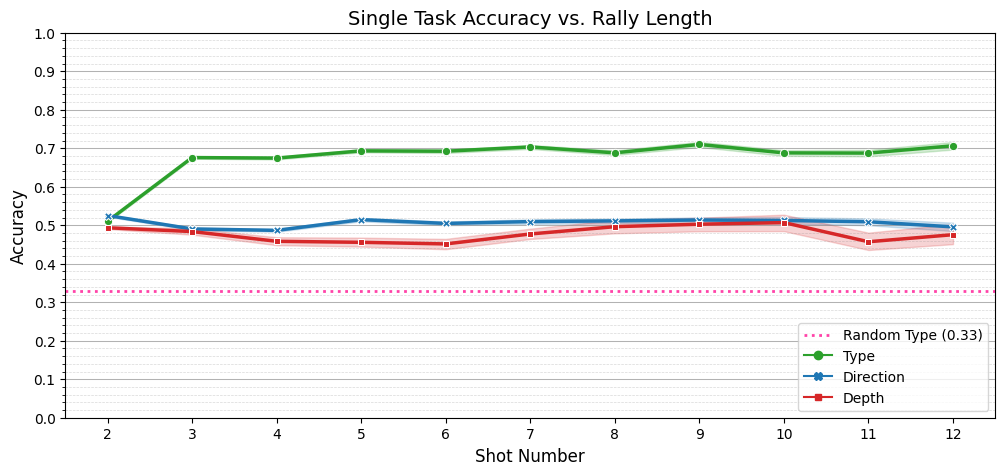

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


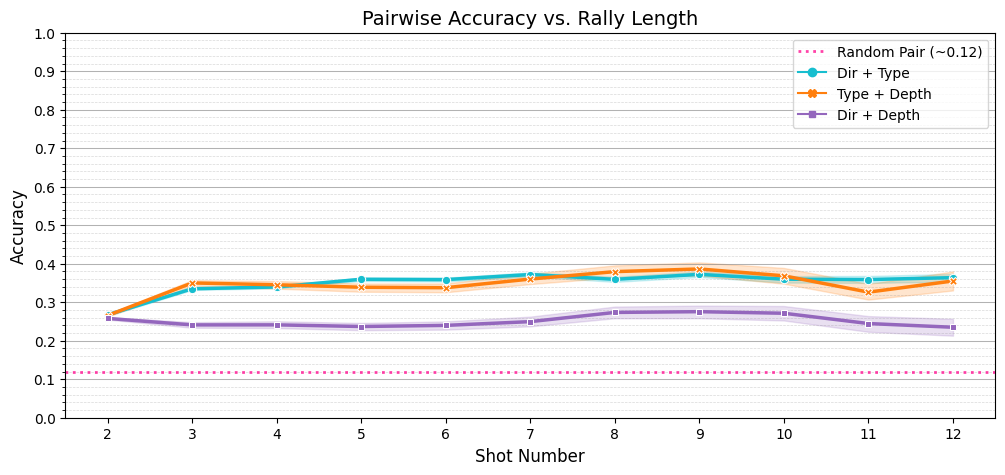

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


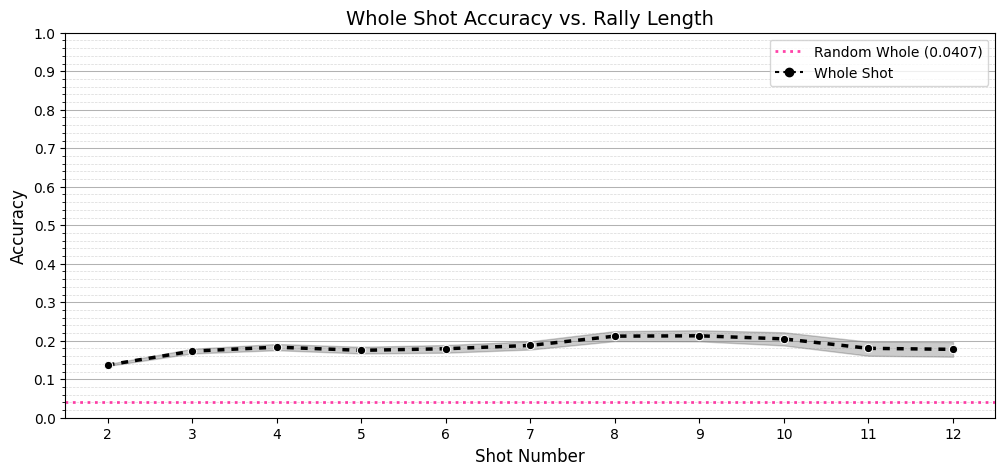


 PART 4: PLAYER FREQUENCY (2000 Matches) 


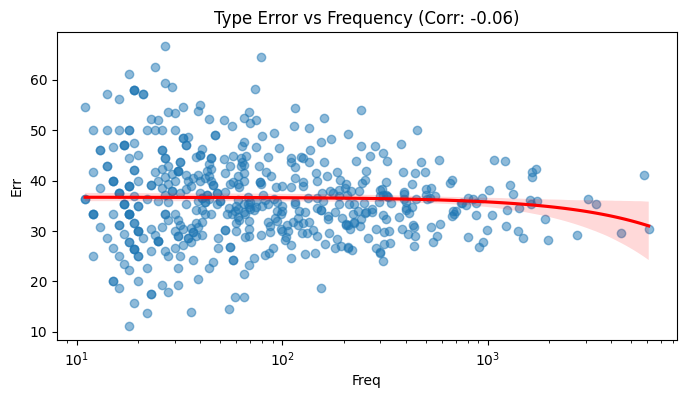


 PART 5: ERA STABILITY (50 Matches/Era) 


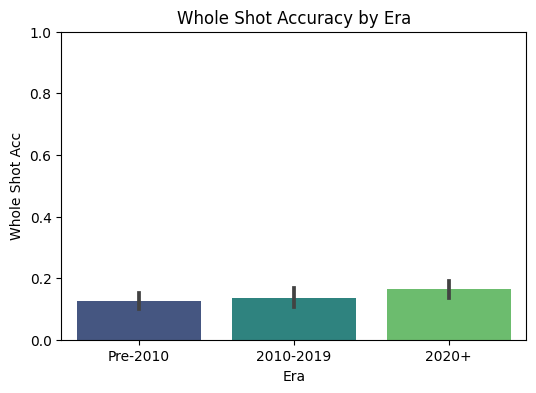


 PART 6: SURFACE DIFFICULTY (10000 samples) 
  Surface       Err  Rel_Diff
0    Clay  0.330572  0.943392
1   Grass  0.408261  1.165104
2    Hard  0.349701  0.997983


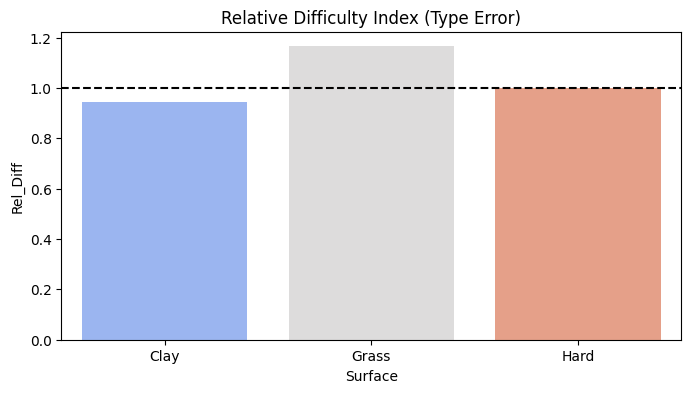

In [16]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, random_split

# --- 1. SHARED CONFIG & HELPERS ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_inverse_vocabs(dataset):
    """Creates reverse lookups for the hierarchical vocabs"""
    inv_type  = {v: k for k, v in dataset.type_vocab.items()}
    inv_dir   = {v: k for k, v in dataset.dir_vocab.items()}
    inv_depth = {v: k for k, v in dataset.depth_vocab.items()}
    return inv_type, inv_dir, inv_depth

# --- 2. THE HIERARCHICAL EVALUATION FUNCTION ---
def run_full_evaluation(model, dataset, loader, test_indices, 
                        live_samples=5000, 
                        length_matches=2000, 
                        freq_matches=2000, 
                        era_matches=50, 
                        speed_samples=10000):
    
    model.eval()
    print(f"Starting Full Evaluation on {len(test_indices)} TEST SET samples...")
    
    # Helpers & IDs
    inv_type, inv_dir, inv_depth = get_inverse_vocabs(dataset)
    serve_type_id = dataset.type_vocab.get('serve', dataset.type_vocab.get('s', -1))
    unk_depth_id = dataset.depth_vocab.get('0', -1)
    unk_dir_id = dataset.dir_vocab.get('0', -1)

    # Pre-calculate Match-to-Index Map
    match_map = {}
    for idx in test_indices:
        mid = dataset.sample_match_ids[idx]
        match_map.setdefault(mid, []).append(idx)
    unique_matches = list(match_map.keys())

    # ==============================================================================
    # PART 1: OVERALL TACTICAL METRICS
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 1: OVERALL TACTICAL METRICS \n" + "="*40)
    
    all_p_type, all_t_type = [], []
    all_p_dir,  all_t_dir  = [], []
    all_p_depth, all_t_depth = [], []
    
    with torch.no_grad():
        for batch in loader:
            # Inputs
            x_z = batch['x_dir'].to(DEVICE)
            x_t = batch['x_type'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            
            # Forward (3 Heads)
            l_dir, l_depth, l_type = model(x_z, x_t, x_c, x_s, x_r)
            
            # Targets
            y_type = batch['y_type'].to(DEVICE).view(-1)
            y_dir  = batch['y_dir'].to(DEVICE).view(-1)
            y_depth = batch['y_depth'].to(DEVICE).view(-1)

            # --- 1. Type (Predicts everything except PAD and SERVES) ---
            mask_t = (y_type != 0)
            if serve_type_id != -1: mask_t &= (y_type != serve_type_id)

            if mask_t.sum() > 0:
                all_p_type.extend(l_type.argmax(-1).view(-1)[mask_t].cpu().numpy())
                all_t_type.extend(y_type[mask_t].cpu().numpy())

            # --- 2. Direction (Mask PAD, UNKNOWN, and SERVES) ---
            mask_d = (y_dir != 0) 
            if unk_dir_id != -1: mask_d &= (y_dir != unk_dir_id)
            if serve_type_id != -1: mask_d &= (y_type != serve_type_id)
            
            if mask_d.sum() > 0:
                all_p_dir.extend(l_dir.argmax(-1).view(-1)[mask_d].cpu().numpy())
                all_t_dir.extend(y_dir[mask_d].cpu().numpy())

            # --- 3. Depth (Mask PAD, UNKNOWN, and SERVES) ---
            mask_dp = (y_depth != 0)
            if unk_depth_id != -1: mask_dp &= (y_depth != unk_depth_id)
            if serve_type_id != -1: mask_dp &= (y_type != serve_type_id)

            if mask_dp.sum() > 0:
                all_p_depth.extend(l_depth.argmax(-1).view(-1)[mask_dp].cpu().numpy())
                all_t_depth.extend(y_depth[mask_dp].cpu().numpy())

    # Reports
    print("\n=== DIRECTION REPORT (Excluding Serves) ===")
    labels = [k for k in dataset.dir_vocab if k not in ['<pad>', '0']]
    indices = [dataset.dir_vocab[k] for k in labels]
    if indices:
        print(classification_report(all_t_dir, all_p_dir, labels=indices, target_names=labels, zero_division=0))

    print("\n=== DEPTH REPORT (Excluding Unknowns) ===")
    labels = [k for k in dataset.depth_vocab if k not in ['<pad>', '0']]
    indices = [dataset.depth_vocab[k] for k in labels]
    print(classification_report(all_t_depth, all_p_depth, labels=indices, target_names=labels, zero_division=0))

    print("\n=== SHOT TYPE REPORT (Rally Only) ===")
    labels = [k for k in dataset.type_vocab if k not in ['<pad>', '<unk>', 'serve', 's']]
    indices = [dataset.type_vocab[k] for k in labels]
    # Filter to present
    present = sorted(list(set(all_t_type)))
    present_names = [inv_type[i] for i in present]
    if present:
        print(classification_report(all_t_type, all_p_type, labels=present, target_names=present_names, zero_division=0))

    # ==============================================================================
    # PART 2: LIVE SAMPLES (Showing {live_samples} Cases)
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 2: LIVE SAMPLES (Showing {live_samples} Cases) \n" + "="*40)
    
    selected_indices = random.sample(test_indices, min(live_samples * 2, len(test_indices)))
    results_buffer = {3: [], 2:[], 1:[], 0:[]}
    printed_count = 0
    
    with torch.no_grad():
        for idx in selected_indices:
            if printed_count >= live_samples: break
            
            sample = dataset[idx]
            non_zeros = (sample['x_type'] != 0).nonzero(as_tuple=True)[0]
            if len(non_zeros) < 2: continue
            
            # Predict a random point
            valid_indices = non_zeros.tolist()
            t = random.choice(valid_indices)
            
            x_z = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_t = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            
            l_dir, l_depth, l_type = model(x_z, x_t, x_c, x_s, x_r)
            
            # --- Build History String ---
            start_idx = valid_indices[0]
            history_str = ""
            for i in range(start_idx, t + 1):
                typ_idx = sample['x_type'][i].item()
                dir_idx = sample['x_dir'][i].item()
                t_in = inv_type.get(typ_idx, '?')
                z_in = inv_dir.get(dir_idx, '?')
                
                if i == start_idx:
                    history_str += f"[Serve {z_in}] " if t_in in ['serve', 's'] else f"[{t_in}{z_in}] "
                else:
                    history_str += f"-> {t_in}{z_in} "
            
            # --- Get Prediction ---
            probs = torch.softmax(l_type[0, t], dim=0)
            conf = probs.max().item() * 100
            
            pred_t = l_type[0, t].argmax().item()
            pred_d = l_dir[0, t].argmax().item()
            pred_dp = l_depth[0, t].argmax().item()
            
            true_t = sample['y_type'][t].item()
            true_d = sample['y_dir'][t].item()
            true_dp = sample['y_depth'][t].item()
            
            if true_t == 0: continue

            s_pred_d = inv_dir.get(pred_d, '?'); s_pred_t = inv_type.get(pred_t, '?')
            s_true_d = inv_dir.get(true_d, '?'); s_true_t = inv_type.get(true_t, '?')
            
            check_d = "✅" if pred_d == true_d else "❌"
            check_t = "✅" if pred_t == true_t else "❌"
            check_dp = "✅" if pred_dp == true_dp else "❌"
            
            def d_lbl(x): return inv_depth.get(x, 'N/A')
            
            score = (1 if pred_d == true_d else 0) + (1 if pred_t == true_t else 0) + (1 if pred_dp == true_dp else 0)
            m_id = dataset.sample_match_ids[idx]

            out = []
            out.append(f"\nMatch {m_id}:")
            out.append(f"  History:    {history_str}")
            out.append(f"  Prediction: {s_pred_t} to {s_pred_d} (Depth {d_lbl(pred_dp)}) | Conf: {conf:.0f}%")
            out.append(f"  ACTUAL:     {s_true_t} to {s_true_d} (Depth {d_lbl(true_dp)}) | {check_t} Type {check_d} Dir {check_dp} Dep")
            
            results_buffer[score].append("\n".join(out))
            printed_count += 1

    print_flag = False
    
    for s in [3,2,1,0]:
        items = results_buffer[s]
        if items:
            print(f"\n{'='*20} {s}/3 CORRECT ({len(items)} cases) {'='*20}")
            if print_flag:
                for item in items: 
                    print(item)

    # ==============================================================================
    # PART 3: GRANULAR ACCURACY VS RALLY LENGTH (Restored 3 Graphs)
    # ==============================================================================
    print("\n" + "="*40 + "\n PART 3: GRANULAR ACCURACY VS RALLY LENGTH \n" + "="*40)
    
    # 3.1 Calculate Baselines
    print("Calculating dataset baselines...")
    all_d, all_dp, all_tp = [], [], []
    for i in test_indices:
        yt = dataset[i]['y_type']
        yd = dataset[i]['y_dir']
        ydp = dataset[i]['y_depth']
        for j in range(len(yt)):
            if yt[j] == 0: continue
            is_srv = (yt[j] == serve_type_id)
            if not is_srv:
                all_tp.append(yt[j].item())
                if yd[j] != unk_dir_id and yd[j] != 0: all_d.append(yd[j].item())
                if ydp[j] != unk_depth_id and ydp[j] != 0: all_dp.append(ydp[j].item())

    def calc_baseline(data_list):
        if not data_list: return 0.33
        counts = Counter(data_list)
        total = sum(counts.values())
        return sum([(c/total)**2 for c in counts.values()])

    base_d = calc_baseline(all_d)
    base_dp = calc_baseline(all_dp)
    base_tp = calc_baseline(all_tp)
    base_pair_avg = (base_d*base_dp + base_d*base_tp + base_tp*base_dp) / 3
    base_whole = base_d * base_dp * base_tp
    print(f"Baselines -> Dir: {base_d:.2f}, Depth: {base_dp:.2f}, Type: {base_tp:.2f}, Whole: {base_whole:.4f}")
    
    # 3.2 Analysis Loop
    chosen_matches = random.sample(unique_matches, min(length_matches, len(unique_matches)))
    rl_indices = [idx for mid in chosen_matches for idx in match_map[mid]]
    print(f"Analyzing {len(rl_indices)} points from {len(chosen_matches)} matches...")

    results_p3 = []
    with torch.no_grad():
        for idx in rl_indices:
            sample = dataset[idx]
            x_z = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_t = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y_t = sample['y_type']
            y_d = sample['y_dir']
            y_dp = sample['y_depth']

            l_dir, l_depth, l_type = model(x_z, x_t, x_c, x_s, x_r)
            preds_t = l_type.argmax(dim=-1).squeeze(0)
            preds_d = l_dir.argmax(dim=-1).squeeze(0)
            preds_dp = l_depth.argmax(dim=-1).squeeze(0)
            
            x_seq_cpu = sample['x_type']
            
            for t_step in range(len(y_t)):
                if y_t[t_step] == 0: continue
                # Skip serves for rally analysis
                if y_t[t_step] == serve_type_id: continue

                shot_num = (x_seq_cpu[:t_step+1] != 0).sum().item() + 1
                
                pt, p_d, pdp = preds_t[t_step].item(), preds_d[t_step].item(), preds_dp[t_step].item()
                tt, td, tdp = y_t[t_step].item(), y_d[t_step].item(), y_dp[t_step].item()

                ok_t = (pt == tt)
                has_dir = (td != 0 and td != unk_dir_id)
                has_depth = (tdp != 0 and tdp != unk_depth_id)
                ok_d = (p_d == td) if has_dir else False
                ok_dp = (pdp == tdp) if has_depth else False

                # Logic Split - Single
                results_p3.append({'Shot_Number': shot_num, 'Task': 'Type', 'Type': 'Single', 'Accuracy': 1 if ok_t else 0})
                if has_dir:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Direction', 'Type': 'Single', 'Accuracy': 1 if ok_d else 0})
                if has_depth:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Depth', 'Type': 'Single', 'Accuracy': 1 if ok_dp else 0})
                
                # Logic Split - Pair
                if has_dir:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Dir + Type', 'Type': 'Pair', 'Accuracy': 1 if (ok_d and ok_t) else 0})
                if has_depth:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Type + Depth', 'Type': 'Pair', 'Accuracy': 1 if (ok_dp and ok_t) else 0})
                if has_dir and has_depth:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Dir + Depth', 'Type': 'Pair', 'Accuracy': 1 if (ok_d and ok_dp) else 0})
                
                # Logic Split - Whole
                if has_dir and has_depth:
                    results_p3.append({'Shot_Number': shot_num, 'Task': 'Whole Shot', 'Type': 'Whole', 'Accuracy': 1 if (ok_d and ok_dp and ok_t) else 0})

    if results_p3:
        df = pd.DataFrame(results_p3)
        df = df[(df['Shot_Number'] <= 12) & (df['Shot_Number'] >= 2)]
        
        palette_single = {'Direction': '#1f77b4', 'Depth': '#d62728', 'Type': '#2ca02c'}
        palette_pair   = {'Dir + Depth': '#9467bd', 'Dir + Type': '#17becf', 'Type + Depth': '#ff7f0e'}
        palette_whole  = {'Whole Shot': '#000000'}

        def setup_plot(title, baseline, base_label):
            plt.figure(figsize=(12, 5))
            plt.title(title, fontsize=14)
            plt.ylabel('Accuracy', fontsize=12)
            plt.xlabel('Shot Number', fontsize=12)
            plt.xticks(np.arange(2, 13, 1))
            
            ax = plt.gca()
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
            plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.75, color='grey', alpha=0.6)
            plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='grey', alpha=0.3)
            plt.ylim(0.0, 1.0)
            
            if baseline:
                plt.axhline(baseline, color='#FF1493', linestyle=':', alpha=0.8, linewidth=2, label=base_label)

        # Graph 1: Single
        setup_plot('Single Task Accuracy vs. Rally Length', base_tp, f'Random Type ({base_tp:.2f})')
        sns.lineplot(data=df[df['Type']=='Single'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_single, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='lower right'); plt.show()
        
        # Graph 2: Pairwise
        setup_plot('Pairwise Accuracy vs. Rally Length', base_pair_avg, f'Random Pair (~{base_pair_avg:.2f})')
        sns.lineplot(data=df[df['Type']=='Pair'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes=False, palette=palette_pair, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

        # Graph 3: Whole Shot
        setup_plot('Whole Shot Accuracy vs. Rally Length', base_whole, f'Random Whole ({base_whole:.4f})')
        sns.lineplot(data=df[df['Type']=='Whole'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                     markers=True, dashes={'Whole Shot':(2,2)}, palette=palette_whole, linewidth=2.5, errorbar=('ci', 68))
        plt.legend(loc='upper right'); plt.show()

    # ==============================================================================
    # PART 4: PLAYER FREQUENCY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 4: PLAYER FREQUENCY ({freq_matches} Matches) \n" + "="*40)
    chosen_matches = random.sample(unique_matches, min(freq_matches, len(unique_matches)))
    pf_indices = [idx for mid in chosen_matches for idx in match_map[mid]]
    
    p_counts = Counter()
    p_stats = {}
    
    with torch.no_grad():
        for idx in pf_indices:
            sample = dataset[idx]
            x_z = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_t = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y_t = sample['y_type']
            
            _, _, l_t = model(x_z, x_t, x_c, x_s, x_r)
            preds = l_t.argmax(-1).squeeze(0)
            
            s_val, r_val = sample['x_s_id'].item(), sample['x_r_id'].item()
            x_seq_cpu = sample['x_type']
            
            for t in range(len(y_t)):
                if y_t[t] == 0: continue
                if y_t[t] == serve_type_id: continue # Skip serves

                hist_len = (x_seq_cpu[:t+1] != 0).sum().item()
                actor = s_val if (hist_len + 1) % 2 != 0 else r_val
                if actor <= 1: continue
                
                p_counts[actor] += 1
                if actor not in p_stats: p_stats[actor] = {'tot': 0, 'corr': 0}
                p_stats[actor]['tot'] += 1
                if preds[t].item() == y_t[t].item(): p_stats[actor]['corr'] += 1

    pf_data = [{'Freq': p_counts[a], 'Err': (1 - v['corr']/v['tot'])*100} for a, v in p_stats.items() if p_counts[a] > 10]
    if pf_data:
        df_pf = pd.DataFrame(pf_data)
        plt.figure(figsize=(8, 4))
        sns.regplot(data=df_pf, x='Freq', y='Err', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.xscale('log'); plt.title(f"Type Error vs Frequency (Corr: {df_pf['Freq'].corr(df_pf['Err']):.2f})"); plt.show()

    # ==============================================================================
    # PART 5: ERA STABILITY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 5: ERA STABILITY ({era_matches} Matches/Era) \n" + "="*40)
    eras = {'Pre-2010': [], '2010-2019': [], '2020+': []}
    for m_id in unique_matches:
        try: y_year = int(str(m_id)[:4])
        except: continue
        if y_year < 2010: eras['Pre-2010'].append(m_id)
        elif y_year < 2020: eras['2010-2019'].append(m_id)
        else: eras['2020+'].append(m_id)

    era_indices = []
    era_labels_list = []
    for era_name, m_list in eras.items():
        if not m_list: continue
        chosen = random.sample(m_list, min(era_matches, len(m_list)))
        for m in chosen:
            era_indices.extend(match_map[m])
            era_labels_list.extend([era_name]*len(match_map[m]))
            
    era_res = []
    with torch.no_grad():
        for i, idx in enumerate(era_indices):
            sample = dataset[idx]
            x_z = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_t = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y_t = sample['y_type'].to(DEVICE)
            y_d = sample['y_dir'].to(DEVICE)
            y_dp = sample['y_depth'].to(DEVICE)
            
            l_d, l_dp, l_t = model(x_z, x_t, x_c, x_s, x_r)
            p_d = l_d.argmax(-1).squeeze(0)
            p_t = l_t.argmax(-1).squeeze(0)
            p_dp = l_dp.argmax(-1).squeeze(0)
            
            mask = (y_t > 1) & (y_t != serve_type_id) & (y_d != unk_dir_id) & (y_dp != unk_depth_id)
            if mask.sum() > 0:
                correct = (p_t[mask] == y_t[mask]) & (p_d[mask] == y_d[mask]) & (p_dp[mask] == y_dp[mask])
                acc = correct.float().mean().item()
                era_res.append({'Era': era_labels_list[i], 'Whole Shot Acc': acc})
    
    if era_res:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=pd.DataFrame(era_res), x='Era', y='Whole Shot Acc', palette='viridis', order=['Pre-2010', '2010-2019', '2020+'])
        plt.title('Whole Shot Accuracy by Era'); plt.ylim(0, 1); plt.show()

    # ==============================================================================
    # PART 6: SURFACE DIFFICULTY
    # ==============================================================================
    print("\n" + "="*40 + f"\n PART 6: SURFACE DIFFICULTY ({speed_samples} samples) \n" + "="*40)
    surf_indices = random.sample(test_indices, min(len(test_indices), speed_samples))
    surf_res = []
    
    with torch.no_grad():
        for idx in surf_indices:
            mid = dataset.sample_match_ids[idx]
            s_name = dataset.match_meta.get(mid, {}).get('surface', 'Hard')
            sample = dataset[idx]
            x_z = sample['x_dir'].unsqueeze(0).to(DEVICE)
            x_t = sample['x_type'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y_t = sample['y_type'].to(DEVICE)
            
            _, _, l_t = model(x_z, x_t, x_c, x_s, x_r)
            p_t = l_t.argmax(-1).squeeze(0)
            
            for t in range(len(y_t)):
                if y_t[t] <= 1: continue
                if y_t[t] == serve_type_id: continue
                err = 1.0 if p_t[t].item() != y_t[t].item() else 0.0
                surf_res.append({'Surface': s_name, 'Err': err})

    if surf_res:
        df_s = pd.DataFrame(surf_res)
        stats = df_s.groupby('Surface')['Err'].mean().reset_index()
        freq = df_s['Surface'].value_counts(normalize=True)
        g_avg = sum(stats[stats['Surface']==k]['Err'].values[0] * v for k,v in freq.items())
        stats['Rel_Diff'] = stats['Err'] / g_avg
        print(stats)
        plt.figure(figsize=(8, 4))
        sns.barplot(data=stats, x='Surface', y='Rel_Diff', palette='coolwarm')
        plt.axhline(1.0, color='k', ls='--')
        plt.title('Relative Difficulty Index (Type Error)'); plt.show()


# --- 3. RUNNER SNIPPET ---
if 'dataset' in globals() and 'hierarchical_model' in globals():
    print("Recreating validation/test split for evaluation...")
    seed_everything(42)
    
    total_len = len(dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    
    gen = torch.Generator().manual_seed(42)
    _, _, test_ds = random_split(dataset, [train_len, val_len, test_len], generator=gen)
    
    test_indices = test_ds.indices
    test_loader_eval = DataLoader(test_ds, batch_size=64, shuffle=False)

    run_full_evaluation(
        model=hierarchical_model, 
        dataset=dataset, 
        loader=test_loader_eval, 
        test_indices=test_indices,
        live_samples=5000, 
        length_matches=2000,
        freq_matches=2000
    )
else:
    print("Error: 'dataset' or 'hierarchical_model' not found. Run training first.")

# 🎾 Live Tennis Rally Demo

This interactive demo shows real tennis rallies with:
- **Ground Truth**: Actual shot sequence from professional matches
- **Model Predictions**: What our trained models predict for each shot
- **Visual Court**: Tennis court visualization with shot trajectories
- **Performance Metrics**: Real-time accuracy and confidence scores

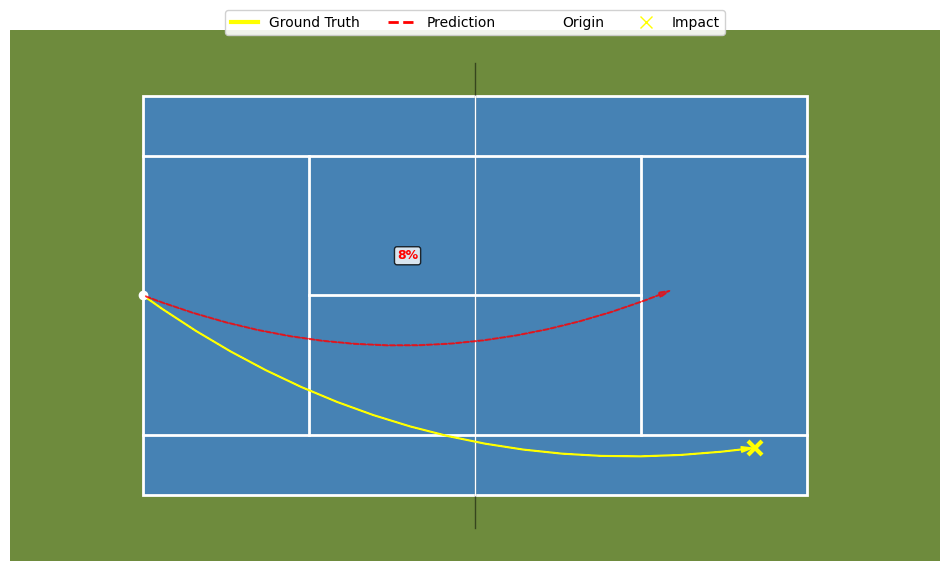

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D
import numpy as np
import random
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- 1. TENNIS LOGIC (WITH DEPTH & PHYSICS) ---
class TennisLogic:
    """Handles logic for a Left-to-Right court view with DEPTH awareness."""
    
    @staticmethod
    def decode_token(token_id, dataset):
        """
        Decodes token into: Type, Direction, and Depth.
        Supports 'f_1_9' (Type_Dir_Depth) or standard 'f1' (TypeDir).
        """
        if hasattr(dataset, 'inv_unified_vocab'):
             token_str = dataset.inv_unified_vocab.get(token_id, 'f2')
        else:
            token_str = 'f2'
            
        token_str = str(token_str).strip().lower()
        
        # Defaults
        shot_data = {'type': 'f', 'direction': '2', 'depth': '9', 'is_serve': False}

        # 1. PARSE SERVES (4, 5, 6)
        if token_str and token_str[0] in ['4', '5', '6']:
            shot_data['type'] = 's'
            shot_data['direction'] = token_str[0]
            shot_data['is_serve'] = True
            shot_data['depth'] = '7' # Serves always land in service box (Short/Mid)
            return shot_data
            
        # 2. PARSE RALLIES
        # Check for underscore format (e.g., "f_1_7")
        if '_' in token_str:
            parts = token_str.split('_')
            shot_data['type'] = parts[0]
            if len(parts) > 1: shot_data['direction'] = parts[1]
            if len(parts) > 2: shot_data['depth'] = parts[2]
        else:
            # Standard "f1" format
            shot_data['type'] = token_str[0]
            # Extract numbers for direction
            for char in token_str:
                if char in ['1', '2', '3']:
                    shot_data['direction'] = char
                    break
        
        # 3. INFER DEPTH FROM SHOT TYPE (If depth is default '9')
        # u/y = Drop shots (Very Short)
        # v/z = Volleys (Often Mid/Deep, but let's default to Mid for visual variety)
        # h/i = Half volleys (Mid)
        if shot_data['type'] in ['u', 'y']:
            shot_data['depth'] = '5' # Very short (Net is 5.0)
        elif shot_data['type'] in ['v', 'z', 'h', 'i']:
            shot_data['depth'] = '8' # Mid court
            
        return shot_data

    @staticmethod
    def get_target_coordinates(direction, depth, is_serve, hitting_from_left):
        """
        Calculates landing spot X,Y with Jitter.
        X-Axis: 0 (Left Baseline) -> 5 (Net) -> 10 (Right Baseline)
        """
        # Y-AXIS (Width 0-6)
        # 1=Right(Bottom), 2=Center, 3=Left(Top)
        base_y = 3.0
        if direction == '1':   base_y = 1.0
        elif direction == '2': base_y = 3.0
        elif direction == '3': base_y = 5.0
        elif direction == '4': base_y = 1.0 if hitting_from_left else 5.0 # Wide Serve
        elif direction == '5': base_y = 3.0 # Body
        elif direction == '6': base_y = 3.0 # T
        
        # X-AXIS (Length/Depth)
        # Determine base "Deep" landing spot
        if hitting_from_left:
            # Ball moving Left -> Right (Target x > 5)
            if is_serve:
                base_x = 7.0 # Service Line is 7.5, land slightly inside
            elif depth == '5': # Drop shot
                base_x = 5.8 # Just over net
            elif depth == '7': # Short
                base_x = 7.0 # Service line area
            elif depth == '8': # Mid
                base_x = 8.0 # No man's land
            else: # 9 / Deep
                base_x = 9.5 # Baseline area
        else:
            # Ball moving Right -> Left (Target x < 5)
            if is_serve:
                base_x = 3.0 # Service Line is 2.5
            elif depth == '5': # Drop shot
                base_x = 4.2 # Just over net
            elif depth == '7': # Short
                base_x = 3.0
            elif depth == '8': # Mid
                base_x = 2.0
            else: # 9 / Deep
                base_x = 0.5 # Baseline area

        # ADD RANDOM JITTER (So shots don't overlap perfectly)
        jitter_x = random.uniform(-0.3, 0.3)
        jitter_y = random.uniform(-0.3, 0.3)
        
        return (base_x + jitter_x, base_y + jitter_y)

# --- 2. VISUALIZATION ENGINE ---
class TennisCourtVisualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1, figsize=(12, 7))
        self.court_color = '#4682B4'
        self.out_color = '#6E8B3D'
        self.setup_court()

    def setup_court(self):
        self.ax.clear()
        self.ax.set_xlim(-2, 12)
        self.ax.set_ylim(-1, 7)
        self.ax.set_aspect('equal')
        self.ax.axis('off')

        # Background & Court
        self.ax.add_patch(patches.Rectangle((-2, -1), 14, 8, color=self.out_color))
        self.ax.add_patch(patches.Rectangle((0, 0), 10, 6, lw=2, edgecolor='white', facecolor=self.court_color))
        
        # Lines
        # Net
        self.ax.plot([5, 5], [-0.5, 6.5], color='black', lw=1, alpha=0.5) 
        self.ax.plot([5, 5], [0, 6], color='white', lw=1)
        # Service Lines
        self.ax.plot([2.5, 2.5], [0.9, 5.1], color='white', lw=2)
        self.ax.plot([7.5, 7.5], [0.9, 5.1], color='white', lw=2)
        # Center Service
        self.ax.plot([2.5, 7.5], [3, 3], color='white', lw=2)
        # Singles Lines
        self.ax.plot([0, 10], [0.9, 0.9], color='white', lw=2)
        self.ax.plot([0, 10], [5.1, 5.1], color='white', lw=2)

        self.add_legend()

    def add_legend(self):
        legend_elements = [
            Line2D([0], [0], color='yellow', lw=3, label='Ground Truth'),
            Line2D([0], [0], color='red', lw=2, linestyle='--', label='Prediction'),
            Line2D([0], [0], marker='o', color='white', label='Origin', markersize=6, ls='None'),
            Line2D([0], [0], marker='x', color='yellow', label='Impact', markersize=8, ls='None')
        ]
        self.ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
                      ncol=4, framealpha=0.9)

    def draw_trajectory(self, start, end, is_prediction=False, confidence=None):
        color = 'red' if is_prediction else 'yellow'
        style = '--' if is_prediction else '-'
        alpha = 0.7 if is_prediction else 1.0
        z = 10 if is_prediction else 5

        # Markers
        if not is_prediction:
            self.ax.plot(start[0], start[1], 'o', color='white', zorder=z+1)
            self.ax.plot(end[0], end[1], 'x', color='yellow', markersize=10, markeredgewidth=3, zorder=z+1)
        
        # Curvature
        rad = 0.2 if start[0] < end[0] else -0.2
        arrow = FancyArrowPatch(start, end, connectionstyle=f"arc3,rad={rad}", 
                                arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8",
                                color=color, linestyle=style, alpha=alpha, zorder=z)
        self.ax.add_patch(arrow)
        
        if is_prediction and confidence is not None:
            mid_x = (start[0] + end[0]) / 2
            mid_y = (start[1] + end[1]) / 2
            label_y = mid_y + 0.5 if mid_y > 3 else mid_y - 0.5
            self.ax.text(mid_x, label_y, f"{int(confidence)}%", color='red', fontsize=9, fontweight='bold',
                        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.2))

# --- 3. CONTROLLER ---
class TennisRallyDemo:
    def __init__(self, models, dataset, test_indices):
        self.models = models
        self.dataset = dataset
        self.test_indices = test_indices
        self.viz = TennisCourtVisualizer()
        
        self.current_rally_idx = None
        self.step_idx = 0
        self.valid_indices = []
        
        self.ball_pos = (0, 3) 
        self.hitting_from_left = True 
        
        self.setup_ui()
        
    def setup_ui(self):
        self.out_info = widgets.Output()
        self.out_viz = widgets.Output()
        
        self.btn_load = widgets.Button(description='🎾 New Rally', button_style='success')
        self.btn_next = widgets.Button(description='▶️ Next Shot', button_style='primary')
        self.dd_model = widgets.Dropdown(options=list(self.models.keys()), description='Model:')
        
        self.btn_load.on_click(self.load_rally)
        self.btn_next.on_click(self.next_step)
        
        display(widgets.VBox([
            widgets.HBox([self.dd_model, self.btn_load, self.btn_next]),
            widgets.HBox([self.out_info, self.out_viz])
        ]))
        self.load_rally(None)

    def load_rally(self, b):
        self.current_rally_idx = random.choice(self.test_indices)
        rally_data = self.dataset[self.current_rally_idx]
        self.valid_indices = (rally_data['x_seq'] != 0).nonzero(as_tuple=True)[0].tolist()
        
        if len(self.valid_indices) < 2:
            self.load_rally(None)
            return

        self.step_idx = 0
        self.ball_pos = (0, 3) 
        self.hitting_from_left = True
        self.update_visualization()

    def next_step(self, b):
        if self.step_idx >= len(self.valid_indices) - 1:
            with self.out_info: print("🏁 Rally Finished! Click 'New Rally'")
            return
            
        # Update physics start position from previous shot result
        prev_idx = self.valid_indices[self.step_idx]
        prev_token = self.dataset[self.current_rally_idx]['x_seq'][prev_idx].item()
        prev_info = TennisLogic.decode_token(prev_token, self.dataset)
        
        target_x, target_y = TennisLogic.get_target_coordinates(
            prev_info['direction'], prev_info['depth'], prev_info['is_serve'], self.hitting_from_left
        )
        self.ball_pos = (target_x, target_y)
        self.hitting_from_left = not self.hitting_from_left
        
        self.step_idx += 1
        self.update_visualization()

    def get_model_prediction(self, data, curr_idx):
        model_name = self.dd_model.value
        model = self.models[model_name]
        try:
            x_seq = data['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = data['context'].unsqueeze(0).to(DEVICE)
            
            with torch.no_grad():
                model.eval()
                logits = model(x_seq, x_c) 
                pred_logits = logits[0, self.valid_indices[self.step_idx]]
                probs = torch.softmax(pred_logits, dim=0)
                conf, pred_id = probs.max(dim=0)
                pred_info = TennisLogic.decode_token(pred_id.item(), self.dataset)
                return pred_info, conf.item() * 100
        except: return None, 0

    def update_visualization(self):
        data = self.dataset[self.current_rally_idx]
        curr_idx = self.valid_indices[self.step_idx]
        
        # 1. GROUND TRUTH
        token_id = data['x_seq'][curr_idx].item()
        shot_info = TennisLogic.decode_token(token_id, self.dataset)
        
        target_pos = TennisLogic.get_target_coordinates(
            shot_info['direction'], shot_info['depth'], shot_info['is_serve'], self.hitting_from_left
        )

        # 2. PREDICTION
        pred_info, conf = self.get_model_prediction(data, curr_idx)
        pred_target_pos = None
        if pred_info:
            pred_target_pos = TennisLogic.get_target_coordinates(
                pred_info['direction'], pred_info['depth'], pred_info['is_serve'], self.hitting_from_left
            )

        with self.out_viz:
            clear_output(wait=True)
            self.viz.setup_court()
            self.viz.draw_trajectory(self.ball_pos, target_pos, is_prediction=False)
            if pred_target_pos:
                self.viz.draw_trajectory(self.ball_pos, pred_target_pos, is_prediction=True, confidence=conf)
            display(self.viz.fig)
            
        with self.out_info:
            clear_output(wait=True)
            print(f"Rally: {self.current_rally_idx} | Step: {self.step_idx + 1}")
            print(f"Shot: {shot_info['type'].upper()} (Dir {shot_info['direction']}, Depth {shot_info['depth']})")
            if pred_info:
                res = "✅" if (pred_info['direction'] == shot_info['direction']) else "❌"
                print(f"Model: {pred_info['type'].upper()} (Dir {pred_info['direction']}, Depth {pred_info['depth']}) - {int(conf)}% {res}")

if 'datasetSingle' in globals():
    demo = TennisRallyDemo({'Baseline': globals().get('baselineSingleHead', None)}, datasetSingle, test_indices)